README:  
Introcuction: This script is for figure 2 in fullscope analysis(spatial DTU analysis)  
Author: Y0NEKO  
Time: 2024.03.28  

In [ ]:
#load package
library(data.table)
library(qs)
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(ggh4x)
library(ggtranscript)
library(khroma)
library(bambu)
library(ggdensity)
library(Seurat)
library(ggsignif) # Significance Brackets for 'ggplot2'
library(gghalves) # Compose Half-Half Plots Using Your Favourite Geoms
library(randomcoloR)
library(ComplexHeatmap)
library(ggvenn)

qs 0.25.5

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: I

In [ ]:
#load data
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")
MySplit = function(str,sep, n){
  return(unlist(lapply(strsplit(str,sep),"[[",n)))
}
# cellan = read.csv("ref/T44/cell_type_type20230220-macaque1-contour2_v1.csv")
# cellan = unique(cellan[,c("subclass","class")])
# areaan = read.csv("ref/area_annotation.csv")
gtf = rtracklayer::import("ref/bambu_extended_annotations_novelname.gtf")
# areaan = unique(areaan[c("L0","L3")])
# colnames(areaan) = c("lobe","area")
# areaan[areaan$area == "1/2",]$area = "1|2"
#transtls = qread("data/reads_full_anotation/read_trans_stat_list_dedup_fsrawdp_24_08_22.qs")
#fsrawdp = qread("data/reads_full_anotation/main_data_read_total_annotation_dedup_24_09_04.qs")
#srtt = qread("data/meta_cell_ngs/umap_srt_combined_24_04")
#fsrawdp = fsrawdp[fsrawdp$layer %in% paste0("l",1:6),]
# fsraw = qread("data/reads_full_anotation/main_data_read_total_annotation_24_08_22.qs")
# head(fsraw)

lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_fil_delete_multiread_25_10_09.qs")
#fsraw.cor = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),]
#longbed = import("ref/long_read_mapping_total_rawnano_pac2_24_03_29.bed", format = "BED")
#qsave(longbed,"ref/long_read_mapping_total_rawnano_pac2_24_03_29.qs")
#length(longbed)
#longbed = longbed[longbed$name %in% fsraw$readid,]
#length(longbed)
#qsave(longbed,"ref/long_read_mapping_total_rawnano_pac2_fil_24_03_29.qs")
longbed = qread("ref/long_read_mapping_total_rawnano_total_fil_24_04_20.qs")
mkls = qread("result/figure2/gene_marker_list_24_12_05.qs")
backpt = qread("longread_cell_isoform_without_subcortical_24_04_29.qs")

In [7]:
spdatals = list()

In [11]:
theme_presentation<- function(base_size = 16, base_family = "") {
  # Starts with theme_grey and then modify some parts
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      strip.background = element_blank(),
      strip.text.x = element_text(size=16,colour="white"),
      strip.text.y = element_text(size=16,colour="white"),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks =  element_blank(), 
      axis.title.x= element_blank(),
      axis.title.y= element_blank(),
      panel.background = element_rect(fill="black"), 
      panel.border =element_blank(),  
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.margin = unit(1.0, "lines"), 
      plot.background = element_rect(fill="black"), 
      plot.title =element_text(size=16,colour="white"), 
      # plot.margin = unit(c(1,  1, 1, 1), "lines"),
      legend.background=element_rect(fill='black'),
      legend.title=element_text(size=12,colour="white"),
      legend.text=element_text(size=12,colour="white"),
      legend.key = element_rect( fill = 'black'),
      # legend.key.size = unit(c(0, 0), "lines"),
      axis.line.x = element_blank(),
      axis.line.y = element_blank()
    )
}


### Case Plot function

In [ ]:
#case plot
BuildPlotBed = function(npclf,nanobed,groupname,geneex,sigtr = NULL){
    readgroup = npclf[npclf$gene_id == geneex,]
    # readgroup = readgroup[readgroup$arealayer %in% paste0("l",1:6),]
    readgroup = unique(readgroup[c("readid","transcript_id","gene_id",
                                   groupname)])
    # readgroup = readgroup %>% group_by(readid) %>% 
    #   mutate(transgroup = 
    #            paste(unique(transcript_id)[order(unique(transcript_id))],
    #                              collapse = "|"))
    readgrt = nanobed[nanobed$name %in% readgroup$readid,]
    readgrt$group = readgroup[match(readgrt$name,
                                    readgroup$readid),
                              groupname]
    # readgrt$transcript_id = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transcript_id"]
    # readgrt$transgroup = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transgroup"]
    
    grtdfl = as.data.frame(readgrt)
    colnames(grtdfl)[ncol(grtdfl)] = "group"
    colnames(grtdfl)[6] = "readid"
    grtdfl = merge(grtdfl,readgroup[c("readid",
                              "transcript_id")],
          by = "readid")
    grtdfl = grtdfl[order(grtdfl$transcript_id,
                          grtdfl$start,grtdfl$end),]
    grtdfl = grtdfl[!is.na(grtdfl$group) &
                      grtdfl$group != "",]
    grtdfl
    grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
    grtdfl = grtdfl %>% group_by(group) %>% 
      mutate(orid = as.numeric(factor(readord,
                                      levels = unique(readord)))) %>%
      mutate(oridnorm = orid/max(orid))
    grtdfl$sig = "black"
    grtdfl[grtdfl$group %in% sigtr, "sig"] = "red"
    return(grtdfl)
}

IsoformReadPlot = function(gtfp, grtdfl, geneex, onlyhub = T,mycolor = NULL){
    library(randomcoloR)
    library(ggbio)
    library(ggtranscript)
    tartrans = gtfp[which(gtfp$gene_id == geneex),]
    tartrans = as.data.frame(tartrans)
    tartrans = tartrans[tartrans$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_id),]
    tartrans$orid = as.numeric(factor(tartrans$transcript_id,levels = unique(tartrans$transcript_id)))
    tartrans$group = NA
    if(onlyhub){
      grtdfl = grtdfl %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
      grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
      grtdfl = grtdfl %>% group_by(group) %>% 
        mutate(orid = as.numeric(factor(readord,
                                        levels = unique(readord)))) %>%
        mutate(oridnorm = orid/max(orid))
      tartrans = tartrans[tartrans$transcript_id %in% grtdfl$transcript_id,]
    }
    # tartrans = merge(tartrans,unique(grtdfl[c("transcript_id",
    #                                           "transgroup")]),
    #                  by = "transcript_id")
    tartranstx = tartrans %>% group_by(transcript_id,orid) %>% 
      summarise(start = min(start),end = max(end))
    tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    
    #facetcol = list()
    #facetcoldf = unique(grtdfl[c("group","sig")])
    #facetcoldf = facetcoldf[order(facetcoldf$group,decreasing = F),]
    #for (i in 1:nrow(facetcoldf)) {
    #  facetcol[[i]] = element_text(color = facetcoldf[i,]$sig)
    #}
    #facetcol[[nrow(facetcoldf)+1]] = element_text(color = "black")
    grtdflin = to_intron(grtdfl,
                     "readord")
    no_of_colors = length(unique(grtdfl$transcript_id)) 
    colorful_palette = distinctColorPalette(no_of_colors) 
    names(colorful_palette) = unique(grtdfl$transcript_id)
    if(!is.null(mycolor)){
        colorful_palette = mycolor
    }

    
    pc = ggplot(grtdfl,aes(x = start,xend = end,
                      y = orid,
                      yend = orid,
                      fill = transcript_id,color = transcript_id)) +
      geom_segment(size = 0.5) +
      geom_segment(data = grtdflin,
                   aes(x = start,xend = end,
                       y = orid,
                       yend = orid),
                   size = 0.03,alpha = 0.5,color = "grey") +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_id,color = transcript_id),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_id"),
                  aes(xstart = start,xend = end,strand = strand),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid,
                    label = transcript_id),
                size = 3, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "top") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      # scale_color_discreterainbow() +
      theme_void() + 
      ggtitle(geneex) +
      theme(legend.position = "none",
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
           strip.placement = "outside",
           plot.title = element_text(hjust = 0.5))
    pc
    
    return(pc)
}
#fsraw.cor = fsraw[fsraw$layer %in% paste0("l",1:6),]
#
IsoformReadPlotTotal = function(fsraw,isosigi,longbed,gtf,geneex,hubtrans = NULL,onlyhub = F,mycolors =NULL){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(transname))
        names(mycolors) = transname
    }
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub,mycolors)
    pci1
    return(pci1)
}

CaseCountPlotBox = function(fsraw,geneex,transname,mycolors = NULL){
    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(unique(npcase1$transcript_id)))
    }
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }
    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      # geom_line(data = npcase1m,aes(x = areatr, y = mean,
      #                              group = transcript_id),
      #           position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + 
    theme(axis.text.x = element_text(angle = 45,vjust = 0.5)) +
    xlab("") + ylab("Isoform read ratio")
    return(pci2)
}

CasePlotTotalClass = function(fsraw,isosigi,gtf,geneex,hubtrans = NULL,markdfb,edgesdf){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    mycolors = distinctColorPalette(length(transname))
    print(mycolors)
    names(mycolors) = transname
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    print(head(grtdfl))
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F,mycolors)
    pci1
#ggexport(p0c1,filename = "processed/figures/f3/bambu_cell_case_NNvsNeuron_CDC42.pdf",
#           width = 6,height = 5)

    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }


    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
#library(ggstatsplot)

    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      geom_line(data = npcase1m,aes(x = areatr, y = mean,
                                   group = transcript_id),
                position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + xlab("") + ylab("Isoform read ratio")
    
#     pci2 = ggbarplot(npcase1,
#                     x = "areatr", y = "rate", 
#                     fill = "areatr",size = 0.5,
#                     width = 0.7,facet.by = "transcript_id",
#                     add = c("mean_se")) +
#         geom_jitter(data = npcase1,
#                 aes(x = areatr, y = rate),size = 0.3,
#                     width = 0.25) +
#         scale_fill_flatui() +
# #        scale_fill_manual(values = mycolors) +
#         stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,
#                            ref.group = ".all.") + 
#         xlab("") + ylab("Isoform ratio") + labs(fill = "") +
#         theme_pubr() + 
#     theme(axis.text.x = element_blank(),
#          axis.ticks.x = element_blank(),
#           legend.position = "bottom")
#     pci2
    pci3 = MarkerSpPlot(fsraw.cor,markdfb,geneex,hubtrans,edgesdf,200)
    #pci3 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,mycolors,hubtrans)
    
    pci = ggarrange(ggarrange(pci1,pci2,widths = c(1.5,2),ncol = 1),pci3,nrow = 1)
    return(pci)
}


In [ ]:
#case plot function
MarkerSpPlot = function(fsrawdp,markdfb,geneex,transid,edgesdf,ra){
    #ra = 200   
    markdf = fsrawdp[fsrawdp$gene_id == geneex,]
    markdf$xid = as.integer(markdf$x/(ra*2)) * ra * 2 + ra
    markdf$yid = as.integer(markdf$y/(ra*2)) * ra * 2 + ra
    markdf$blockid = paste0(markdf$xid,"_", markdf$yid)
    
    markdf = markdf %>% group_by(xid,yid,blockid) %>% 
      mutate(genecount = length(unique(readid))) %>%
      group_by(xid,yid,blockid,transcript_id) %>% 
      summarise(count = length(unique(readid)),genecount = genecount[1],
                       rate = count/genecount)


    pmkptls = list()
    for(i in 1:length(transid)){
        transi = transid[i]
        markdfi = markdf[markdf$transcript_id == transi,]
        markdfb = markdfb[!markdfb$blockid %in% markdfi$blockid,]
        markdfb$transcript_id = transi
        markdfb$rate = 0
        edgesdf$transcript_id = unique(markdfi$transcript_id)
        cml = intersect(colnames(markdfb),colnames(markdfi))
        markdfi = rbind(markdfb[,cml],markdfi[,cml])
        pmkpti = ggplot() +
          geom_tile(data = markdfi,
                 aes(xid,yid,fill = rate)) + 
        geom_segment(data = edgesdf, 
                   aes(x = x1, y = y1, xend = x2, yend = y2),
                   size = 0.1,
                   color = "grey") + theme_void() +
      #scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~transcript_id,nrow = 2) +
          theme_void() + 
          ggtitle(transi) +
      #scale_color_manual(values = mycolor) +
      #scale_fill_gradient(low = "blue", high = "red")+
          scale_fill_viridis() +
          theme_presentation() + 
          theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
          guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
          scale_y_reverse() + scale_x_reverse()
        pmkptls[[i]] = pmkpti
    }
    pmkpt = ggarrange(plotlist = pmkptls,nrow = 1,common.legend = T)
    return(pmkpt)

}

In [ ]:
#spatial point plot
MarkerSpPlotBin1 = function(fsraw,backpt,geneex,mycolor = NULL,hubtrans = NULL,ptsize = 0.5){
    markdfb = backpt
    markdf = fsraw[fsraw$gene_id == geneex,]
    if(!is.null(hubtrans)){
        markdf = markdf[markdf$transcript_id %in% hubtrans,]
    }else{
        transt = markdf
        transt$genecount = length(unique(transt$readid))
        transt = transt %>% group_by(transcript_id) %>% 
          summarise(count = length(unique(readid)),genecount = genecount[1],
                       rate = count/genecount)
        transtf = transt[transt$rate > 0.05,]
        markdf = markdf[markdf$transcript_id %in% transtf$transcript_id,]
    }

    
    markdf = markdf %>% group_by(x,y) %>% 
      mutate(genecount = length(unique(readid))) %>%
      group_by(x,y,transcript_id) %>% 
      summarise(count = length(unique(readid)),genecount = genecount[1],
                       rate = count/genecount)
    markdf = markdf %>% group_by(x,y) %>% filter(rate == max(rate))


    if(is.null(mycolor)){
        mycolor = distinctColorPalette(length(unique(markdf$transcript_id)))
    }
    if(length(mycolor) == 1) mycolor = "#C894B6"
   
    
    pmkpti = ggplot() +
      scattermore::geom_scattermore(
        data = markdfb,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = 0.1
      ) +
      geom_point(data = markdf,
                 aes(x,y,color = transcript_id),
                 size = ptsize) + 
      # facet_wrap(~gene_id,nrow = 2) +
      theme_void() + 
      scale_color_manual(values = mycolor) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
      guides(color = guide_legend(override.aes = list(size=8),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse()
    pmkpti
    return(pmkpti)
}

MarkerSpPlotCell = function(npclfdp.cell,npclfdp.cellb,geneex,mycolor = NULL,hubtrans = NULL){
    markdf = npclfdp.cell[npclfdp.cell$gene_id %in% geneex,]
    if(!is.null(hubtrans)){
        markdf = markdf[markdf$transcript_id %in% hubtrans,]
    }
    markdfb = npclfdp.cellb[!npclfdp.cellb$cell_id %in% markdf$cell_id,]
    markdf = markdf %>% group_by(cell_id,gene_id) %>% mutate(readrate = readnum/sum(readnum))
    markdf = markdf[markdf$readrate > 0.5,]
    markdfst = markdf %>% group_by(transcript_id) %>% summarise(cellnum = length(cell_id))
    markdfst$cellpop = markdfst$cellnum/sum(markdfst$cellnum)
    markdfst = markdfst[markdfst$cellpop > 0.01,]
    markdf = markdf[markdf$transcript_id %in% markdfst$transcript_id,]

    if(is.null(mycolor)){
        mycolor = distinctColorPalette(length(unique(markdf$transcript_id)))
    }
    
    pmkpti = ggplot() +
      scattermore::geom_scattermore(
        data = markdfb,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = 0.05
      ) +
      geom_point(data = markdf,
                 aes(x,y,color = transcript_id,size = readnum)) + 
      scale_size(range = c(0.05,0.1)) +
      # facet_wrap(~gene_id,nrow = 2) +
      theme_void() + 
      scale_color_manual(values = mycolor) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 6)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse()
    pmkpti
    return(pmkpti)
}
  # selectedhub  = c("APOE","CALB1","NEFM","SCN1B","SMYD2","PLP1")
MarkerSpPlotDensity = function(fsrawdp,markdfb,geneex,transid,edgesdf,ra){
    #ra = 200   
    markdf = fsrawdp[fsrawdp$gene_id == geneex,]
    markdf$xid = as.integer(markdf$x/(ra*2)) * ra * 2 + ra
    markdf$yid = as.integer(markdf$y/(ra*2)) * ra * 2 + ra
    markdf$blockid = paste0(markdf$xid,"_", markdf$yid)
    
    markdf = markdf %>% 
      group_by(xid,yid,blockid,transcript_id) %>% 
      summarise(count = length(unique(readid)))

    pmkptls = list()
    for(i in 1:length(transid)){
        transi = transid[i]
        markdfi = markdf[markdf$transcript_id == transi,]
        markdfb = markdfb[!markdfb$blockid %in% markdfi$blockid,]
        markdfb$transcript_id = transi
        markdfb$count = 0
        edgesdf$transcript_id = unique(markdfi$transcript_id)
        cml = intersect(colnames(markdfb),colnames(markdfi))
        markdfi = rbind(markdfb[,cml],markdfi[,cml])
        pmkpti = ggplot() +
          geom_tile(data = markdfi,
                 aes(xid,yid,fill = log(count+1))) + 
        geom_segment(data = edgesdf, 
                   aes(x = x1, y = y1, xend = x2, yend = y2),
                   size = 0.1,
                   color = "grey") + theme_void() +
      #scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~transcript_id,nrow = 2) +
          theme_void() + 
          ggtitle(transi) +
      #scale_color_manual(values = mycolor) +
      #scale_fill_gradient(low = "blue", high = "red")+
          scale_fill_viridis() +
          theme_presentation() + 
          theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
          guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
          scale_y_reverse() + scale_x_reverse()
        pmkptls[[i]] = pmkpti
    }
    pmkpt = ggarrange(plotlist = pmkptls,nrow = 1,common.legend = T)
    return(pmkpt)

}

### Calculate spatial marker gene

In [7]:
ngscount = fread("/cluster/home/xiliyuan/T44_info/total_gene_T44_macaque_f001_2D_macaque1-20230306.txt")
head(ngscount)
regionan = read.csv("/cluster/home/liuhengxin/P1_brain_nanopore/ref/regions-macaque1-20230306.csv")
regionan = regionan[,c("global_region_id","origin_name")]

gene    x     y     umi_count cell_label gene_area rx    ry   
1 SPARCL1 10204 26115 2         0          0         56131 12632
2 DNAH7   10204 26115 1         0          0         56131 12632
3 ANAPC15 10204 26115 1         0          0         56131 12632
4 MOB4    10205 26115 1         0          0         56130 12632
5 OPCML   10205 26115 1         0          0         56130 12632
6 NGEF    10206 26116 2         0          0         56129 12633

In [8]:
ra = 200
ngscount$xid = as.integer(ngscount$x/(ra*2)) * ra * 2 + ra
ngscount$yid = as.integer(ngscount$y/(ra*2)) * ra * 2 + ra
ngscount$blockid = paste0(ngscount$xid,"_",ngscount$yid)
#ngscount.st = ngscount %>% group_by(blockid) %>% summarise(count = sum(umi_count))

In [13]:
ngscount = ngscount[ngscount$gene_area != 0, ] %>% group_by(gene_area,gene,blockid) %>% summarise(genecount = sum(umi_count))
ngscount = merge(ngscount,regionan,by.x = "gene_area",by.y = "global_region_id")

ngscount$layer = MySplit(ngscount$origin_name,'-',3)
ngscount$region = MySplit(ngscount$origin_name,'-',2)

gene_area gene blockid     genecount origin_name
1 102       A2M  10200_26200 3         L-1|2-l1   
2 102       A2M  10200_26600 7         L-1|2-l1   
3 102       A2M  10200_41000 9         L-1|2-l1   
4 102       A2M  10600_26200 1         L-1|2-l1   
5 102       A2M  10600_26600 1         L-1|2-l1   
6 102       A2M  10600_41000 5         L-1|2-l1

In [15]:
groupan = data.frame("abv" = c("cb","cortex","HC","mb","p","str","v"),
                       "ano" = c("Cerebellum","Cortex","Hippocampus","Midbrain",
                                 "Pons","Striatum","Ventricle"))
ngscount$subcortical = ngscount$layer
ngscount[ngscount$subcortical %in% paste0("l",1:6),]$subcortical = "cortex"
ngscount = ngscount[ngscount$subcortical != "c",]
ngscount$subcortical = groupan[match(ngscount$subcortical,groupan$abv),]$ano
head(ngscount)
qsave(ngscount,file = "data/spatial_genecount_ngs_bin200_fs_total_25_04_14.qs")

gene_area gene blockid     genecount origin_name layer region subcortical
1 102       A2M  10200_26200 3         L-1|2-l1    l1    1|2    Cortex     
2 102       A2M  10200_26600 7         L-1|2-l1    l1    1|2    Cortex     
3 102       A2M  10200_41000 9         L-1|2-l1    l1    1|2    Cortex     
4 102       A2M  10600_26200 1         L-1|2-l1    l1    1|2    Cortex     
5 102       A2M  10600_26600 1         L-1|2-l1    l1    1|2    Cortex     
6 102       A2M  10600_41000 5         L-1|2-l1    l1    1|2    Cortex

In [17]:
nrow(ngscount)
ngscount = merge(ngscount,areaan,by.x = "region",by.y = "area",all = TRUE)
nrow(ngscount)
qsave(ngscount,file = "data/spatial_genecount_ngs_bin200_fs_25_01_03.qs")

[1] 128343848

[1] 128343961

In [22]:
fsraw.cor$xid = as.integer(fsraw.cor$x/(ra*2)) * ra * 2 + ra
fsraw.cor$yid = as.integer(fsraw.cor$y/(ra*2)) * ra * 2 + ra
fsraw.cor$blockid = paste0(fsraw.cor$xid,"_",fsraw.cor$yid)
fscount = fsraw.cor %>% group_by(layer,lobe,region,blockid,subcortical,gene_id) %>% summarise(genecount = length(unique(readid))) 
ngscount = ngscount[,c("gene","layer","region","lobe","subcortical","blockid","genecount")]
colnames(ngscount)[1] = "gene_id"
gcount = rbind(fscount,ngscount)
head(gcount)
qsave(gcount,file = "data/spatial_genecount_ngs_combine_bin200_fs_25_04_14.qs")

`summarise()` has grouped output by 'layer', 'lobe', 'region', 'blockid',
'subcortical'. You can override using the `.groups` argument.


layer lobe region blockid     subcortical gene_id genecount
1 HC    NA   CA1    26600_82600 Hippocampus AARSD1  1        
2 HC    NA   CA1    26600_82600 Hippocampus ACAA1   1        
3 HC    NA   CA1    26600_82600 Hippocampus ACHE    1        
4 HC    NA   CA1    26600_82600 Hippocampus ACP1    1        
5 HC    NA   CA1    26600_82600 Hippocampus ACP6    1        
6 HC    NA   CA1    26600_82600 Hippocampus ACTB    2

In [23]:
gcount$metacell = paste0(gcount$layer,"-",gcount$region,"-",gcount$lobe,"-",gcount$subcortical,"-",gcount$blockid)
head(gcount)

layer lobe region blockid     subcortical gene_id genecount
1 HC    NA   CA1    26600_82600 Hippocampus AARSD1  1        
2 HC    NA   CA1    26600_82600 Hippocampus ACAA1   1        
3 HC    NA   CA1    26600_82600 Hippocampus ACHE    1        
4 HC    NA   CA1    26600_82600 Hippocampus ACP1    1        
5 HC    NA   CA1    26600_82600 Hippocampus ACP6    1        
6 HC    NA   CA1    26600_82600 Hippocampus ACTB    2        
  metacell                         
1 HC-CA1-NA-Hippocampus-26600_82600
2 HC-CA1-NA-Hippocampus-26600_82600
3 HC-CA1-NA-Hippocampus-26600_82600
4 HC-CA1-NA-Hippocampus-26600_82600
5 HC-CA1-NA-Hippocampus-26600_82600
6 HC-CA1-NA-Hippocampus-26600_82600

In [26]:
#gcount$metacell = paste0(gcount$layer,"-",gcount$region,"-",gcount$lobe,"-",gcount$blockid)
gcount = gcount %>% group_by(layer,lobe,region,subcortical,gene_id,blockid,metacell)%>% summarise(genecount = sum(genecount)) 
qsave(gcount,file = "data/spatial_genecount_ngs_combine_fs_25_04_14.qs")

`summarise()` has grouped output by 'layer', 'lobe', 'region', 'subcortical',
'gene_id', 'blockid'. You can override using the `.groups` argument.


In [43]:
dim(gcountmx)
gcountmx = gcountmx[,colnames(gcountmx)!= "NA"]
dim(gcountmx)

[1] 26543 18685

[1] 26543 18684

In [44]:
# gcountf = gcount[substr(gcount$gene_id,1,5) != "Bambu",]
# gcountmx = dcast(gcountf,gene_id~metacell,
#                    value.var = "genecount",fun.aggregate = sum)
# dim(gcountmx)
# gcountmx = gcountmx[!is.na(gcountmx$gene_id),]
# dim(gcountmx)
#rownames(gcountmx) = gcountmx$gene_id;gcountmx = gcountmx[-1]
#length(unique(transt.sp[transt.sp$gene_id %in% genemk,]$transcript_id))
#gcountmx = gcountmx[,colnames(gcountmx)!= "NA"]

SrtBuild = function(gcountmx){
    srtt = CreateSeuratObject(gcountmx)
    srtt = NormalizeData(srtt)
    srtt = ScaleData(srtt)
    srtt <- FindVariableFeatures(srtt, selection.method = "vst",
                                 nfeatures = 2000)
    srtt <- RunPCA(srtt,
                   features = VariableFeatures(object = srtt))
    srtt <- FindNeighbors(srtt, dims = 1:20)
    srtt <- FindClusters(srtt, resolution = 0.5)
    srtt <- RunUMAP(srtt, dims = 1:10)
    return(srtt)
}
srt.sp = SrtBuild(gcountmx)



Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Data is of class data.frame. Coercing to dgCMatrix."
Normalizing layer: counts

Centering and scaling data matrix

Finding variable features for layer counts

PC_ 1 
Positive:  CCR9, SPATA8, LOC102141360, LOC107130656, OR5P2, LOC107130108, LOC102124856, OR12D3, SLC25A52, LOC107127908 
	   LOC102117884, CAPNS2, LOC107131089, FAM218A, LOC102129369, HOXD9, LOC107130322, LOC107127629, LOC107127396, LOC102121356 
	   LOC102143453, LOC107126726, GUCA2B, LOC102139821, LOC107128308, LOC102142738, LOC107130238, LOC107129298, LOC107126546, LOC102144343 
Negative:  GRID2, CBLN1, ZIC1, GABRA6, NBEA, ITM2B, FGF14, CBLN3, SYNE1, KCND2 
	   NRXN3, PRDX5, CHGB, ZIC4, TRPM3, DPP6, TIAM1, PCP2, GRM4, EN2 
	   MRLN, RBFOX1, NREP, WWOX, SNRPN, RPL3, PCP4, CDR1, GRIK2, NDUFB4 
PC_ 2 
Positive:  PRLR, FOLR1, KCNJ13, TGFBI, CCDC153, C13H2orf40, F5, GSTA5, FOXJ1, CP 
	   MSX1, KL, CAPSL, PIFO, SLC13A4

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18684
Number of edges: 731077

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9117
Number of communities: 15
Elapsed time: 2 seconds


21:23:47 UMAP embedding parameters a = 0.9922 b = 1.112

21:23:47 Read 18684 rows and found 10 numeric columns

21:23:47 Using Annoy for neighbor search, n_neighbors = 30

21:23:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:23:50 Writing NN index file to temp file /tmp/Rtmp0ihbZZ/file688a5c7dc1ed

21:23:50 Searching Annoy index using 1 thread, search_k = 3000

21:23:57 Annoy recall = 99.29%

21:24:37 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:24:37 166 smooth knn distance failures

21:25:39 Initializing from normalized Laplacian + noise (using RSpectra)

21:25:40 Commencing optimization for 200 epochs, with 801244 positive edges

21:25:40 Using rng type: pcg

21:26:48 Optimization finished



In [45]:
ansubcor = MySplit(colnames(srt.sp),"-",4)
names(ansubcor) = colnames(srt.sp)
srt.sp$subcortical = ansubcor
Idents(srt.sp) = srt.sp$subcortical
qsave(srt.sp,file = "data/spatial_genecount_ngs_combine_fs_srt_25_04_14.qs")

ERROR: Error in substr(srt.sp, idents = "Cortex"): unused argument (idents = "Cortex")


In [47]:
srt.sp.sub = subset(srt.sp,idents = "Cortex")

In [48]:
anlayer = MySplit(colnames(srt.sp.sub),"-",1)
anarea = MySplit(colnames(srt.sp.sub),"-",2)
anlobe = MySplit(colnames(srt.sp.sub),"-",3)
ansubcor = MySplit(colnames(srt.sp.sub),"-",4)
names(anlayer) = names(anarea) = names(anlobe) = colnames(srt.sp.sub)
srt.sp.sub$layer = anlayer
srt.sp.sub$region = anarea
srt.sp.sub$lobe = anlobe
Idents(srt.sp.sub) = srt.sp.sub$layer

In [49]:
Idents(srt.sp) = srt.sp$subcortical
mk.subcor =  FindAllMarkers(srt.sp)

Idents(srt.sp.sub) = srt.sp.sub$layer
mk.layer =  FindAllMarkers(srt.sp.sub)
#region markers
Idents(srt.sp.sub) = srt.sp.sub$lobe
mk.lobe =  FindAllMarkers(srt.sp.sub)

Idents(srt.sp.sub) = srt.sp.sub$region
mk.region =  FindAllMarkers(srt.sp.sub)

mkls = list("layer" = mk.layer,"lobe" = mk.lobe,"region" = mk.region,"subcortical" = mk.subcor)
qsave(mkls,file = "result/figure2/gene_marker_list_25_04_14.qs")


Calculating cluster Cerebellum

Calculating cluster Hippocampus

Calculating cluster Cortex

Calculating cluster Midbrain

Calculating cluster Pons

Calculating cluster Striatum

Calculating cluster Ventricle

Calculating cluster l1

Calculating cluster l2

Calculating cluster l3

Calculating cluster l4

Calculating cluster l5

Calculating cluster l6

Calculating cluster somatosensory

Calculating cluster cingulate

Calculating cluster parietal

Calculating cluster auditory

Calculating cluster temporal

Calculating cluster occipital

Calculating cluster 1|2

Calculating cluster 23a

Calculating cluster 23b

Calculating cluster 23c

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 7op

Calculating cluster AI

Calculating cluster CL

Calculating cluster CM

Calculating cluster CPB

Calculating cluster FST

Calculating cluster LIPd

Calculating cluster LIPv

Calculating cluster PE

Calculating cluster PEa

Calculating cluster PG

Calculating clu

In [111]:
tranrate = fsraw.cor %>% group_by(gene_id,transcript_id) %>% 
    summarise(count = length(readid)) %>% group_by(gene_id) %>% 
    mutate(genecount = sum(count),rate = count/genecount)
tranrate = tranrate[tranrate$rate > 0.05,]
tranrate = tranrate[tranrate$genecount > 20,]
trannumst = tranrate %>% group_by(gene_id) %>% summarise(transnum = length(unique(transcript_id)))

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


In [112]:
mkgenet = NULL
for(i in 1:length(mkls)){
    mklsi = mkls[[i]]
    colnames(mklsi)[6:7] = c("areaid","gene_id")
    mklsi = mklsi[mklsi$avg_log2FC > 1 & mklsi$p_val_adj < 0.05 & mklsi$pct.1 > 0.1, ]
    mkgenet = c(mkgenet,unique(mklsi$gene_id))
}
mkgenet = unique(mkgenet)
length(mkgenet)

[1] 3331

In [113]:
mkls.layer.st = trannumst[trannumst$gene_id %in% mkgenet,] %>% group_by(transnum) %>% summarise(genenum = length(unique(gene_id)))
mkls.layer.st$transnum = as.character(mkls.layer.st$transnum)
mkls.layer.st$prop = mkls.layer.st$genenum / sum(mkls.layer.st$genenum)

In [114]:
mkls.layer = mkls$layer
colnames(mkls.layer)[6:7] = c("layer","gene_id")
mkls.layer = mkls.layer[mkls.layer$avg_log2FC > 1 & mkls.layer$p_val_adj < 0.05 & mkls.layer$pct.1 > 0.1, ]
length(unique(mkls.layer$gene_id))

mkls.lobe = mkls$lobe
colnames(mkls.lobe)[6:7] = c("lobe","gene_id")
mkls.lobe = mkls.lobe[mkls.lobe$avg_log2FC > 0.5 & mkls.lobe$p_val_adj < 0.05 & mkls.lobe$pct.1 > 0.1, ]
length(unique(mkls.lobe$gene_id))

mkls.region = mkls$region
colnames(mkls.region)[6:7] = c("region","gene_id")
mkls.region = mkls.region[mkls.region$avg_log2FC > 0.5 & mkls.region$p_val_adj < 0.05 & mkls.region$pct.1 > 0.1, ]
length(unique(mkls.region$gene_id))

[1] 1950

[1] 126

[1] 1378

transnum genenum prop        proplabel group 
1  1        1070    0.616359447 61.6%     layer 
2  2         457    0.263248848 26.3%     layer 
3  3         144    0.082949309 8.3%      layer 
4  4          41    0.023617512 2.4%      layer 
5  5          19    0.010944700 1.1%      layer 
6  6           3    0.001728111 0.2%      layer 
7  7           2    0.001152074 0.1%      layer 
8  1          20    0.645161290 64.5%     lobe  
9  2           9    0.290322581 29%       lobe  
10 4           1    0.032258065 3.2%      lobe  
11 5           1    0.032258065 3.2%      lobe  
12 1          10    0.769230769 76.9%     region
13 2           2    0.153846154 15.4%     region
14 4           1    0.076923077 7.7%      region

file saved to result/figure2/gene_marker_isoform_heterogeneity_stat_pie_24_12_05.pdf



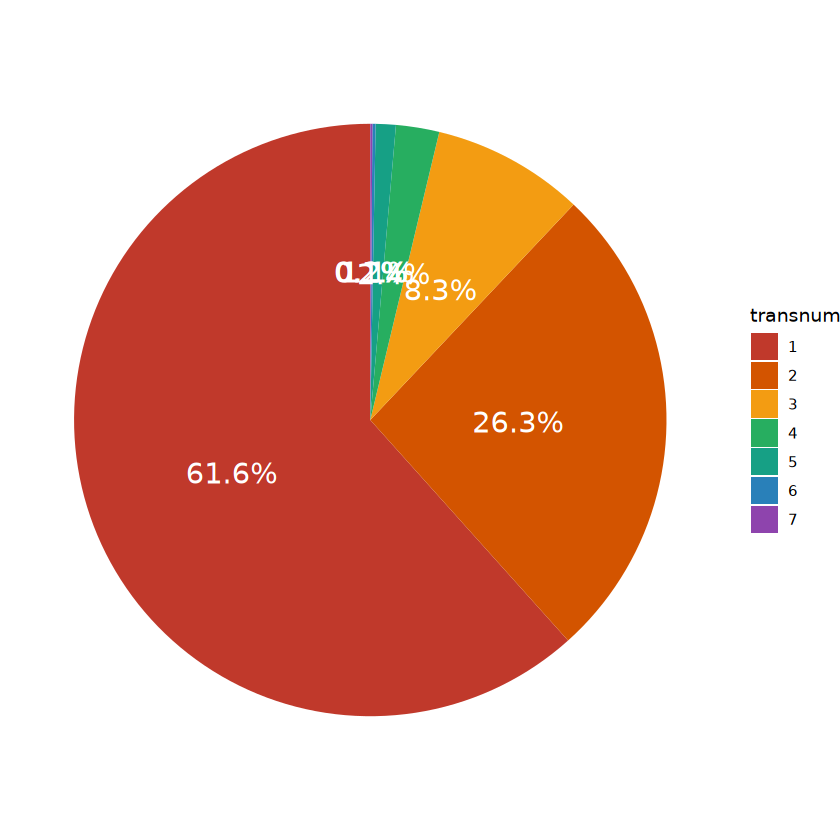

In [93]:
#pie plot
mkls.layer = merge(mkls.layer,trannumst,by = "gene_id")
mkls.layer.st = mkls.layer %>% group_by(transnum) %>% summarise(genenum = length(unique(gene_id)))
mkls.layer.st$transnum = as.character(mkls.layer.st$transnum)
mkls.layer.st$prop = mkls.layer.st$genenum / sum(mkls.layer.st$genenum)
mkls.layer.st$proplabel = paste0(round(mkls.layer.st$prop*100,1),"%")
mkls.layer.st$group = "layer"

mkls.lobe = merge(mkls.lobe,trannumst,by = "gene_id")
mkls.lobe.st = mkls.lobe %>% group_by(transnum) %>% summarise(genenum = length(unique(gene_id)))
mkls.lobe.st$transnum = as.character(mkls.lobe.st$transnum)
mkls.lobe.st$prop = mkls.lobe.st$genenum / sum(mkls.lobe.st$genenum)
mkls.lobe.st$proplabel = paste0(round(mkls.lobe.st$prop*100,1),"%")
mkls.lobe.st$group = "lobe"

mkls.region = merge(mkls.region,trannumst,by = "gene_id")
mkls.region.st = mkls.region %>% group_by(transnum) %>% summarise(genenum = length(unique(gene_id)))
mkls.region.st$transnum = as.character(mkls.region.st$transnum)
mkls.region.st$prop = mkls.region.st$genenum / sum(mkls.region.st$genenum)
mkls.region.st$proplabel = paste0(round(mkls.region.st$prop*100,1),"%")
mkls.region.st$group = "region"

mkls.transt = rbind(mkls.layer.st,mkls.lobe.st,mkls.region.st)
mkls.transt
p1.4 = ggplot(mkls.transt[mkls.transt$group == "layer",], aes(x=group, y=prop, fill=transnum)) +
  geom_bar(stat="identity", width = 0.5, color= NA) +
  coord_polar("y", start=0) +
  geom_text(aes(label = proplabel),position = position_stack(0.5), color = "white", size=6) +
  scale_fill_flatui() + theme_void()
p1.4
write.csv(mkls.transt,file = "result/figure2/gene_marker_isoform_heterogeneity_stat_pie_25_10_13.csv")
ggexport(p1.4,filename = "result/figure2/gene_marker_isoform_heterogeneity_stat_pie_25_10_13.pdf",width = 4,height = 5)


### Marker Case plot

##### multiple isoform gene marker case plot

In [10]:
transt.sp = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),] %>% group_by(layer, region, gene_id,transcript_id) %>% 
    summarise(transcount = length(unique(readid)))
transt.sp$transgroup = paste0(transt.sp$gene_id,"-",transt.sp$transcript_id)
transt.sp$cellname = paste0(transt.sp$layer,"-",transt.sp$region)

`summarise()` has grouped output by 'layer', 'region', 'gene_id'. You can
override using the `.groups` argument.


In [117]:
transnumst = fsraw.cor %>% group_by(gene_id) %>% summarise(trannum = length(unique(transcript_id)))
transnumst = transnumst[transnumst$trannum > 1,]
mkly = mkls$layer[mkls$layer$gene %in% transnumst$gene_id,]
mkly = mkly[mkly$p_val_adj < 0.05 & mkly$avg_log2FC>1,]
mkly = mkly %>% group_by(gene) %>% filter(length(unique(cluster)) == 1)
#write.csv(mkly,file = "result/figure2/layer_markergene_multiple_isoform_list_24_11_29.csv")

In [11]:
#build case plot srt object
transtmx = dcast(transt.sp,transgroup~cellname,
                   value.var = "transcount",fun.aggregate = sum)
rownames(transtmx) = transtmx$transgroup;transtmx = transtmx[-1]
#length(unique(transt.sp[transt.sp$gene_id %in% genemk,]$transcript_id))
  
SrtBuild = function(transtmx){
    srtt = CreateSeuratObject(transtmx)
    srtt = NormalizeData(srtt)
    srtt = ScaleData(srtt)
    srtt <- FindVariableFeatures(srtt, selection.method = "vst",
                                 nfeatures = 2000)
    srtt <- RunPCA(srtt,
                   features = VariableFeatures(object = srtt))
    # srtt <- FindNeighbors(srtt, dims = 1:20)
    # srtt <- FindClusters(srtt, resolution = 0.5)
    # srtt <- RunUMAP(srtt, dims = 1:10)
    return(srtt)
}
srt.sp = SrtBuild(transtmx)
anlayer = MySplit(colnames(srt.sp),"-",1)
anarea = MySplit(colnames(srt.sp),"-",2)
names(anlayer) = names(anarea) = colnames(srt.sp)
srt.sp$layer = anlayer
srt.sp$area = anarea
Idents(srt.sp) = srt.sp$layer

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Data is of class data.frame. Coercing to dgCMatrix."
Normalizing layer: counts

Centering and scaling data matrix

Finding variable features for layer counts

PC_ 1 
Positive:  MSX1-XM-005554460.2, FEZF2-XM-015446131.1, APLNR-XM-005577873.2, MSX2-XM-005558555.2, KRT17-XM-005584188.2, SLC6A20-XM-005546881.2, KLK6-XM-005590058.2, CPLX3-XM-005560096.2, BMP5-XM-005552690.2, SLC13A4-XM-005550863.2 
	   NXPH4-XM-005571295.1, COL1A1-XM-005583658.2, DSP-XM-005554092.2, HTR2C-XM-005594406.1, MOBP-XM-015445335.1, SLC22A6-XM-005577529.2, IL33-XM-005581767.2, SEPT4-NM-001283908.1, MICALL1-XM-015457221.1, ISLR-XM-005560050.2 
	   LOC102146810-XM-005576098.2, LOC102124392-XR-001487935.1, CRYGN-XM-005551215.2, CRABP2-XM-005541420.1, CCL19-NM-001287694.1, OLFML2B-XM-005541143.2, LOC107129209-LOC107129209-FS-1, NXPH3-XM-005583618.2, LOC102143976-XR-273868.2, LOC102145490-LOC102145490-FS-2 
Nega

In [12]:
#multiple isoform gene marker case plot
#case plot
modify_vlnplot <- function(srt.sp.sub, selectedhub) {
    features = rownames(srt.sp.sub)
    features = features[MySplit(features,"-",1) %in% selectedhub]
    
    objp = as.data.frame(srt.sp.sub[["RNA"]]$scale.data)
    objp = objp[features,]
    objp$transid = rownames(objp)
    objp = melt(objp)
    objp$geneid = MySplit(objp$transid,"-",1)
    objp$areatr = MySplit(as.character(objp$variable),"-",1)
    objp$geneid = factor(objp$geneid,levels = unique(selectedhub))
    
    objp = objp[!is.na(objp$geneid),]
    objp = objp[order(objp$geneid),]
    objp = objp %>% group_by(geneid, areatr) %>% filter(length(variable) > 2)
#    objp$areatr = gsub("l","L",objp$areatr)

    ylabedf = objp %>% group_by(geneid) %>% summarise(ymin = min(value),ymax = max(value))
    
    ylabels = list()
    for(i in 1:nrow(ylabedf)){
       ylabels[[i]] = scale_y_continuous(breaks = c(round(ylabedf$ymax[i],2) - 0.1),
                                         limits = c(round(ylabedf$ymin[i],2), round(ylabedf$ymax[i],2) - 0.1))
    }
    objprect = data.frame("areatr" = unique(objp$areatr),value = 1)

    if(nrow(objprect) > 10){
        mycolors = viridis_pal(option = "D")(nrow(objprect))
    }else{
        mycolors = pal_flatui("default")(nrow(objprect))
    }
    mycolors = c(mycolors,mycolors)
    names(mycolors) = c(levels(objp$geneid),unique(objp$areatr))
#    print(mycolors)
    vertical.lines = seq(1.5,nrow(objprect)-0.5,1)
    pi = ggplot(objp) +
      geom_rect(data = objprect,
                aes(xmin = as.numeric(as.factor(areatr))-0.5,xmax = as.numeric(as.factor(areatr))+0.5,ymin = -Inf,ymax = Inf,fill = areatr),
                alpha = 0.2) +
      geom_violin(aes(x = areatr,y = value,fill = geneid,color = transid),size = 0.3,drop = FALSE) +
      geom_boxplot(aes(x = areatr,y = value,color = transid),size = 0.3,fill = "white",width=0.1,cex=0.8,outlier.size = 0.3,drop = FALSE,
                   position = position_dodge(0.9)) +
      geom_vline(xintercept = vertical.lines,lty="dashed", color = "black", linewidth = 0.5) +
      #geom_vline(xintercept = 1.5, lty="dashed", color = "black", linewidth = 0.5)+
      #geom_vline(xintercept = 2.5, lty="dashed", color = "black", linewidth = 0.5)+
      #geom_vline(xintercept = 3.5, lty="dashed", color = "black", linewidth = 0.5)+
      #geom_vline(xintercept = 4.5, lty="dashed", color = "black", linewidth = 0.5)+
      #geom_vline(xintercept = 5.5, lty="dashed", color = "black", linewidth = 0.5)+
      #geom_boxplot(fill = "white",color = "black") +
      # geom_jitter(size = 0.1) +
      facet_grid(geneid~.,scales = "free") + 
      facetted_pos_scales(y = ylabels)+
      scale_color_manual(values = rep("black",length(unique(objp$transid)))) +
      scale_fill_manual(values = mycolors) +
      xlab("") + ylab("") +
      scale_x_discrete(
      expand = c(0,0)
      ) +
      # scale_y_continuous(breaks = custom_breaks) +
      theme_pubr() +
      theme(strip.background = element_blank(), 
            strip.text.x = element_blank(), 
            legend.position = "none",
            panel.spacing = unit(0,'lines'),
            panel.border = element_rect(fill = NA),
            strip.text.y = element_text(angle = 0,size = 12),
            axis.text.x = element_text(size = 12))
    pi
    return(pi)
}

[1] "FABP7-NM_001283638.1"  "FABP7-XM_005551710.2"  "FBXO15-FBXO15-FS-1"   
 [4] "FBXO15-XM_005586451.2" "HPCAL1-NM_001283164.1" "HPCAL1-XM_005576572.2"
 [7] "MAL-MAL-FS-1"          "MAL-NM_001284558.1"    "NTNG1-XM_005542544.2" 
[10] "SMYD2-SMYD2-FS-1"      "SMYD2-XM_005540829.2"  "NTNG1-XM_005542550.2"

Using transid as id variables

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"Duplicated aesthetics after name standardisation: size"
Warning message in geom_boxplot(aes(x = areatr, y = value, color = transid), size = 0.3, :
"Ignoring unknown parameters: `drop`"
Warning message:
"`is.ggproto()` was deprecated in ggplot2 3.5.2.
ℹ Please use `is_ggproto()` instead."


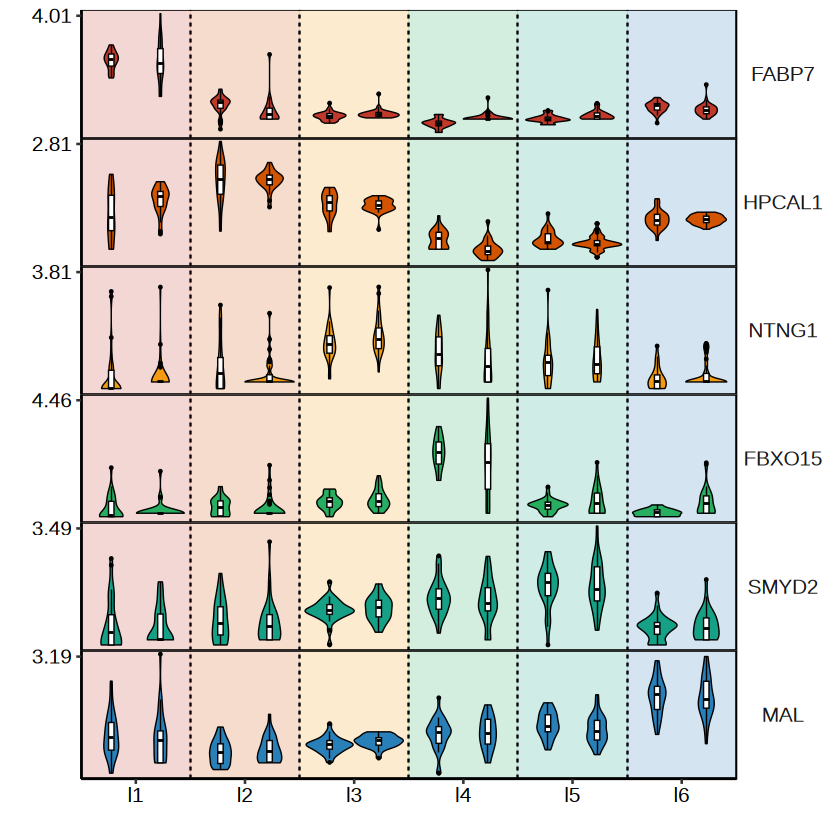

In [14]:
#selectedhub = c("FABP7","CALB1","SNCG","CXXC4","SMYD2","PLP1")
selectedhub = c("FABP7","HPCAL1","NTNG1","FBXO15","SMYD2","MAL")
#"SEMA3B","HPCAL1","NTNG1","FBXO15"
#selectedhub = c("FABP7","C1QL2","ADCYAP1","IL1RAPL2","HTR2C","KRT17")
#selectedhub = c("FABP7","CALB1","SNCG","FBXO15","SMYD2","CNP")
  # selectedhub = c("APOE","CALB1","NEFM","SCN1B","SMYD2","PLP1")
transt.sp.hub = transt.sp[transt.sp$gene_id %in% selectedhub,]
transt.sp.hub = transt.sp.hub %>% group_by(gene_id,transcript_id) %>% 
            mutate(totalt = sum(transcount)) %>% 
            group_by(gene_id) %>% mutate(totalg = sum(transcount),rate = totalt/totalg)
transt.sp.hub = transt.sp.hub[transt.sp.hub$rate > 0.05,]
#transt.sp.hub
transidsub = unique(transt.sp.hub$transgroup)
transidsub
transidsub = gsub(transidsub,pattern = "_",replacement = "-")
srt.sp.sub = subset(srt.sp,features = transidsub)

pc.box = modify_vlnplot(srt.sp.sub, selectedhub)
pc.box
#ggexport(pc.box,filename = "processed/figures/f2/multiple_isoform_marker_case_24_01_28.pdf",width = 6,height = 5)


In [15]:
nrow(fsraw.cor[fsraw.cor$gene_id == "NTNG1",])
transid = unique(fsraw.cor[fsraw.cor$gene_id == "NTNG1",]$transcript_id)
transid
transid = c('XM_005542544.2','XM_005542550.2')
pci = SpCasePlot(fsraw.cor,"NTNG1",transid,backpt,1,0.2)
ggexport(pci,
        filename = "result/figure2/marker_gene_molecular_spatial_point_NTNG1_24_12_12.pdf",
        width = 4,height = 6)

[1] 2314

[1] "XM_005542544.2" "XM_005542550.2" "XM_015431969.1" "XM_005542553.2"

file saved to result/figure2/marker_gene_molecular_spatial_point_24_11_29.pdf



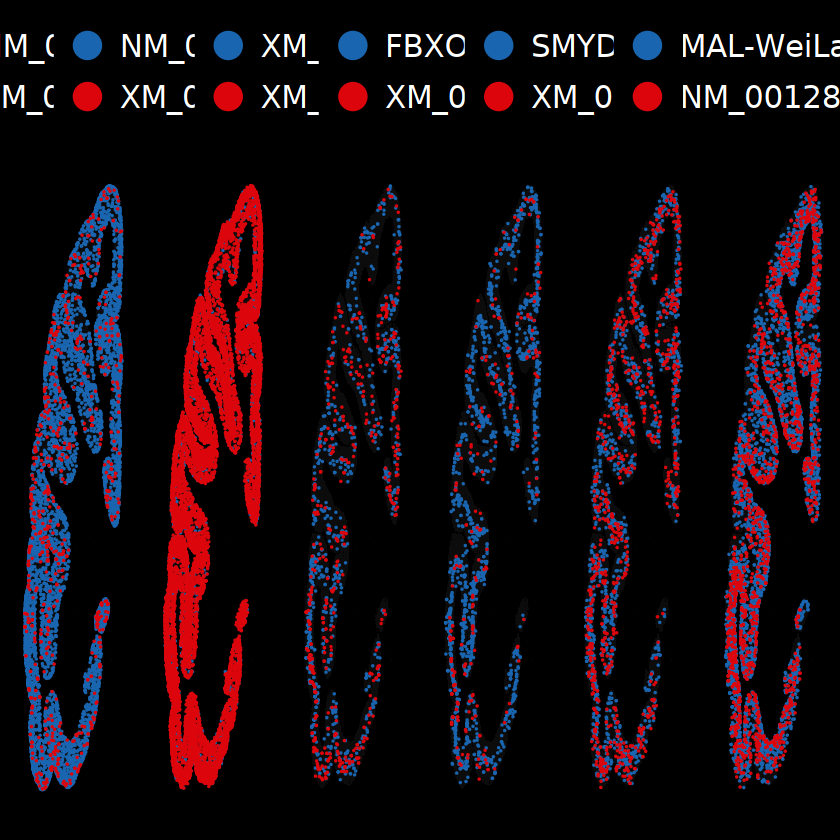

In [313]:
selectedhub = c("FABP7","HPCAL1","NTNG1","FBXO15","SMYD2","MAL")
transid = unique(transt.sp.hub$transcript_id)
plmkt.sp = list()
for (i in 1:length(selectedhub)) {
    plmkt.sp[[i]] = SpCasePlot(fsraw.cor,selectedhub[i],transid,backpt,0.7)
    #plmkt.sp[[i]] = MarkerSpPlot(fsrawdp.cellf,fsrawdp.cellb,selectedhub[i],NULL,NULL)
}
plmkt.spt = ggarrange(plotlist = plmkt.sp,nrow = 1)
plmkt.spt
ggexport(plmkt.spt,
        filename = "result/figure2/marker_gene_molecular_spatial_point_24_11_29.pdf",
        width = 24,height = 6)

In [13]:
ggexport(pc.box,filename = "result/figure2/multiple_isoform_marker_case_24_10_17.pdf",width = 6,height = 5)

file saved to result/figure2/multiple_isoform_marker_case_24_10_17.pdf



#### Calculate marker gene

In [ ]:
ra = 200
fsraw.cor$xid = as.integer(fsraw.cor$x/(ra*2)) * ra * 2 + ra
fsraw.cor$yid = as.integer(fsraw.cor$y/(ra*2)) * ra * 2 + ra
fsraw.cor$blockid = paste0(fsraw.cor$xid,"_", fsraw.cor$yid)
fsraw.cor$metacell = paste0(fsraw.cor$layer,"-",fsraw.cor$region,"-",fsraw.cor$blockid)
fsraw.corf = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),] 
genect = fsraw.corf %>% group_by(metacell,gene_id) %>% 
    summarise(count = length(readid))
transct = fsraw.corf %>% group_by(metacell,transcript_id) %>% 
    summarise(count = length(readid))
head(transct)

In [6]:
isomx = dcast.data.table(setDT(transct), transcript_id~metacell,  value.var = "count",fill = 0)
isomx = as.data.frame(isomx)
rownames(isomx) = isomx$transcript_id;isomx = isomx[-1]

genemx = dcast.data.table(setDT(genect), gene_id~metacell,  value.var = "count",fill = 0)
genemx = as.data.frame(genemx)
rownames(genemx) = genemx$gene_id;genemx = genemx[-1]


In [7]:
cellidan = data.frame(cell_id = colnames(genemx))
cellidan$layer = MySplit(cellidan$cell_id,"-",1)
cellidan$region = MySplit(cellidan$cell_id,"-",2)
head(cellidan)

cell_id            layer region
1 l1-1|2-10200_26200 l1    1|2   
2 l1-1|2-10200_26600 l1    1|2   
3 l1-1|2-10200_41000 l1    1|2   
4 l1-1|2-10600_26200 l1    1|2   
5 l1-1|2-10600_26600 l1    1|2   
6 l1-1|2-10600_41000 l1    1|2

In [8]:
ProcessSrtUmapSingle = function(genemx,cellidan){
    srtt = CreateSeuratObject(genemx)
    srtt = NormalizeData(srtt)
    # srtt = SCTransform(srtt,new.assay.name = "SCT_GENE")
    srtt = ScaleData(srtt)
    areaan = cellidan$region
    names(areaan) = cellidan$cell_id
    layeran = cellidan$layer
    names(layeran) = cellidan$cell_id
    
    srtt$layer = layeran
    srtt$region = areaan
    # srtt$region = MySplit(colnames(srtt),"-",1)
    # names(srtt$region) = colnames(srtt)
    # srtt$layer = MySplit(colnames(srtt),"-",2)
    # names(srtt$layer) = colnames(srtt)
    # srtt$class = MySplit(colnames(srtt),"-",3)
    # names(srtt$class) = colnames(srtt)
    # srtt$subclass = MySplit(colnames(srtt),"-",4)
    # names(srtt$subclass) = colnames(srtt)
    
    # VariableFeatures(srtt) = c(VariableFeatures(srtg),sigtrangroup)
    srtt <- FindVariableFeatures(srtt, selection.method = "vst",
                                 nfeatures = 2000)
    VariableFeatures(srtt) = c(VariableFeatures(srtt))
    srtt <- RunPCA(srtt,
                   # assay =  "SCT_GENE",
                   features = VariableFeatures(object = srtt))
    srtt <- FindNeighbors(srtt, dims = 1:20)
    srtt <- FindClusters(srtt, resolution = 0.5)
    srtt <- RunUMAP(srtt, dims = 1:10)
    DimPlot(srtt)
    
    return(srtt)
}
library(Seurat)
srtg = ProcessSrtUmapSingle(genemx,cellidan)
srti = ProcessSrtUmapSingle(isomx,cellidan)

#layer markers
Idents(srtg) = srtg$layer
mk.layer =  FindAllMarkers(srtg)
#region markers
Idents(srtg) = srtg$region
mk.area =  FindAllMarkers(srtg)

#layer markers
Idents(srti) = srti$layer
mk.layer.iso =  FindAllMarkers(srti)
#region markers
Idents(srti) = srti$region
mk.area.iso =  FindAllMarkers(srti)
mkls = list("layer" = mk.layer,"area" = mk.area,"layer.iso" = mk.layer.iso,"area.iso" = mk.area.iso)
qsave(mkls,file = "result/figure2/gene_marker_list_24_08_25.qs")
mkls.layer = mkls$layer
colnames(mkls.layer)[6:7] = c("layer","gene_id")
mkls.layer = mkls.layer[mkls.layer$avg_log2FC > 0.5 & mkls.layer$p_val_adj < 0.05 & mkls.layer$pct.1 > 0.1, ]
length(unique(mkls.layer$gene))

mkls.layer.iso = mkls$layer.iso
colnames(mkls.layer.iso)[6:7] = c("layer","transcript_id")
mkls.layer.iso = mkls.layer.iso[mkls.layer.iso$avg_log2FC > 0.5 & mkls.layer.iso$p_val_adj < 0.05 & mkls.layer.iso$pct.1 > 0.1, ]
length(unique(mkls.layer.iso$transcript_id))


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Data is of class data.frame. Coercing to dgCMatrix."
Normalizing layer: counts

Centering and scaling data matrix

Finding variable features for layer counts

PC_ 1 
Positive:  CALM1, MIF, ENC1, SNCG, RPS7, SST, LOC102124736, LOC102138191, PCP4, HPCAL1 
	   LOC102135846, NPY, NUDT3, LOC101925898, UBQLN1, MBP, WFDC2, TSR2, GPS2, RALBP1 
	   CPLX2, VIMP, LOC102122634, APOC1, KRT17, PENK, TPM4, C1H1orf35, NSRP1, ATXN7L3B 
Negative:  APLNR, SEMA3B, MYOC, COL1A2, LOC102115399, BambuGene74767, LOC107129559, BambuGene53464, LOC107130656, LRRC74B 
	   LOC102118389, BambuGene39231, ELN, LOC107131004, BambuGene144816, SPATA8, BambuGene97800, BambuGene134272, EGF, BambuGene106636 
	   BambuGene70340, LOC102143571, BambuGene42651, LOC102143453, BambuGene29388, LOC107130112, BambuGene17979, BambuGene100790, BambuGene91263, BambuGene81471 
PC_ 2 
Positive:  KRT17, MBP, PCP4, LOC102135846, DR

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15228
Number of edges: 694226

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6167
Number of communities: 5
Elapsed time: 2 seconds


1 singletons identified. 4 final clusters.

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
21:53:04 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

21:53:04 Read 15228 rows and found 10 numeric columns

21:53:04 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

21:53:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15228
Number of edges: 675173

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6251
Number of communities: 5
Elapsed time: 2 seconds


21:59:57 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

21:59:57 Read 15228 rows and found 10 numeric columns

21:59:57 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

21:59:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:59:59 Writing NN index file to temp file /tmp/RtmpgkdXb7/file8e5d32a4a5b9

21:59:59 Searching Annoy index using 1 thread, search_k = 3000

22:00:06 Annoy recall = 95.19%

22:00:32 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:00:33 799 smooth knn distance failures

22:01

In [14]:
#compare gene marker and isoform marker
mkls.layer = mkls$layer
colnames(mkls.layer)[6:7] = c("layer","gene_id")
mkls.layer = mkls.layer[mkls.layer$avg_log2FC > 0.5 & mkls.layer$p_val_adj < 0.05 & mkls.layer$pct.1 > 0.1, ]
length(unique(mkls.layer$gene))

mkls.layer.iso = mkls$layer.iso
colnames(mkls.layer.iso)[6:7] = c("layer","transcript_id")
mkls.layer.iso = mkls.layer.iso[mkls.layer.iso$avg_log2FC > 0.5 & mkls.layer.iso$p_val_adj < 0.05 & mkls.layer.iso$pct.1 > 0.1, ]
length(unique(mkls.layer.iso$transcript_id))



[1] 1159

[1] 1169

In [177]:
#Calculate Marker gene
#known marker genes:
#srtt = qread(file = "data/meta_cell_ngs/umap_srt_combined_24_03_28.qs")
DefaultAssay(srtt) = "RNA"
#layer markers
Idents(srtt) = srtt$layer
mk.layer =  FindAllMarkers(srtt)

#region markers
Idents(srtt) = srtt$area
mk.area =  FindAllMarkers(srtt)

#class
Idents(srtt) = srtt$class
mk.class =  FindAllMarkers(srtt)

#subclass
Idents(srtt) = srtt$subclass
mk.subclass =  FindAllMarkers(srtt)
mkls = list("layer" = mk.layer,"area" = mk.area,"class" = mk.class,"subclass" = mk.subclass)

qsave(mkls,file = "result/figure2/gene_marker_list_24_03_28.qs")
#mkls = qread("result/figure2/gene_marker_list_24_01_14.qs")


Calculating cluster l1

Calculating cluster l2

Calculating cluster l3

Calculating cluster l4

Calculating cluster l5

Calculating cluster l6

Calculating cluster 1|2

Calculating cluster 7op

Calculating cluster CPB

Calculating cluster V3v

Calculating cluster FST

Calculating cluster PE

Calculating cluster PEa

Calculating cluster TEO

Calculating cluster TEpv

Calculating cluster TFO

Calculating cluster TPO

Calculating cluster V4

Calculating cluster v23b

Calculating cluster 23a

Calculating cluster 23b

Calculating cluster 23c

Calculating cluster 31

Calculating cluster AI

Calculating cluster CL

Calculating cluster CM

Calculating cluster LIPd

Calculating cluster PG

Calculating cluster PGa

Calculating cluster TEpd

Calculating cluster V2

Calculating cluster V4t

Calculating cluster VIP

Calculating cluster LIPv

Calculating cluster 29

Calculating cluster 30

Calculating cluster GABA

Calculating cluster GLU

Calculating cluster NonNeuron

Calculating cluster LAMP5

Ca

In [80]:
srtt = qread("data/meta_cell_ngs/umap_srt_combined_24_03_28.qs")
srtt

An object of class Seurat 
56746 features across 18558 samples within 1 assay 
Active assay: RNA (56746 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [83]:
Idents(srtt) = srtt$lobe
mk.lobe =  FindAllMarkers(srtt)
mkls$lobe = mk.lobe
qsave(mkls,file = "result/figure2/gene_marker_list_24_03_28.qs")

Calculating cluster somatosensory

Calculating cluster parietal

Calculating cluster auditory

Calculating cluster occipital

Calculating cluster temporal

Calculating cluster cingulate



### DTU analysis

#### DTU number statistic 

In [16]:

isosigi = isosigls$layer
thred = c(0.05,0.1,0.2,0.3,0.4,0.5)
QutileDTUst = function(isosigi,thred){
    isostdf = NULL
    genenum = length(unique(isosigi$gene_id))
    for(i in thred){
        genesign = isosigi[abs(isosigi$dr) > i & isosigi$padj < 0.05,]
        isostdfi = genesign %>% group_by(areatr) %>% summarise(sign = length(unique(gene_id)))
        isostdfi$thred = i
        isostdf = rbind(isostdf,isostdfi)
    }
    isostdf$total = genenum
    isostdf$ratio = isostdf$sign/isostdf$total
    return(isostdf)
}
isostdf.l = QutileDTUst(isosigls$layer,thred)
isostdf.l$group = "layer"

isostdf.b = QutileDTUst(isosigls$lobe,thred)
isostdf.b$group = "lobe"
isostdf = rbind(isostdf.l,isostdf.b)
isostdf

areatr        sign thred total ratio        group
1  l1            587  0.05  4492  0.1306767587 layer
2  l2            491  0.05  4492  0.1093054319 layer
3  l3            428  0.05  4492  0.0952804987 layer
4  l4            461  0.05  4492  0.1026268923 layer
5  l5            433  0.05  4492  0.0963935886 layer
6  l6            439  0.05  4492  0.0977292965 layer
7  l1            313  0.10  4492  0.0696794301 layer
8  l2            192  0.10  4492  0.0427426536 layer
9  l3            156  0.10  4492  0.0347284061 layer
10 l4            191  0.10  4492  0.0425200356 layer
11 l5            180  0.10  4492  0.0400712378 layer
12 l6            191  0.10  4492  0.0425200356 layer
13 l1             84  0.20  4492  0.0186999110 layer
14 l2             39  0.20  4492  0.0086821015 layer
15 l3             45  0.20  4492  0.0100178094 layer
16 l4             35  0.20  4492  0.0077916296 layer
17 l5             43  0.20  4492  0.0095725735 layer
18 l6             49  0.20  4492  0.0109082814 layer
19 l1             23  0.30  4492  0.0051202137 layer
20 l2              6  0.30  4492  0.0013357079 layer
21 l3             15  0.30  4492  0.0033392698 layer
22 l4              5  0.30  4492  0.0011130899 layer
23 l5             13  0.30  4492  0.0028940338 layer
24 l6             16  0.30  4492  0.0035618878 layer
25 l1              3  0.40  4492  0.0006678540 layer
26 l2              2  0.40  4492  0.0004452360 layer
27 l3              6  0.40  4492  0.0013357079 layer
28 l5              3  0.40  4492  0.0006678540 layer
29 l6              4  0.40  4492  0.0008904720 layer
30 l1              1  0.50  4492  0.0002226180 layer
31 l3              2  0.50  4492  0.0004452360 layer
32 l5              1  0.50  4492  0.0002226180 layer
33 l6              1  0.50  4492  0.0002226180 layer
34 auditory      371  0.05  4533  0.0818442533 lobe 
35 cingulate     316  0.05  4533  0.0697110082 lobe 
36 occipital     349  0.05  4533  0.0769909552 lobe 
37 parietal      326  0.05  4533  0.0719170527 lobe 
38 somatosensory 408  0.05  4533  0.0900066181 lobe 
39 temporal      231  0.05  4533  0.0509596294 lobe 
40 auditory      159  0.10  4533  0.0350761085 lobe 
41 cingulate     135  0.10  4533  0.0297816016 lobe 
42 occipital     139  0.10  4533  0.0306640194 lobe 
43 parietal      112  0.10  4533  0.0247076991 lobe 
44 somatosensory 167  0.10  4533  0.0368409442 lobe 
45 temporal       88  0.10  4533  0.0194131921 lobe 
46 auditory       36  0.20  4533  0.0079417604 lobe 
47 cingulate      33  0.20  4533  0.0072799471 lobe 
48 occipital      28  0.20  4533  0.0061769248 lobe 
49 parietal       25  0.20  4533  0.0055151114 lobe 
50 somatosensory  30  0.20  4533  0.0066181337 lobe 
51 temporal       24  0.20  4533  0.0052945069 lobe 
52 auditory        9  0.30  4533  0.0019854401 lobe 
53 cingulate       4  0.30  4533  0.0008824178 lobe 
54 occipital       6  0.30  4533  0.0013236267 lobe 
55 parietal        5  0.30  4533  0.0011030223 lobe 
56 somatosensory   7  0.30  4533  0.0015442312 lobe 
57 temporal        7  0.30  4533  0.0015442312 lobe 
58 cingulate       1  0.40  4533  0.0002206045 lobe 
59 parietal        2  0.40  4533  0.0004412089 lobe 
60 temporal        2  0.40  4533  0.0004412089 lobe

file saved to result/figure2/sigiso_number_stat_lobe_layer_proportion_25_10_11.pdf



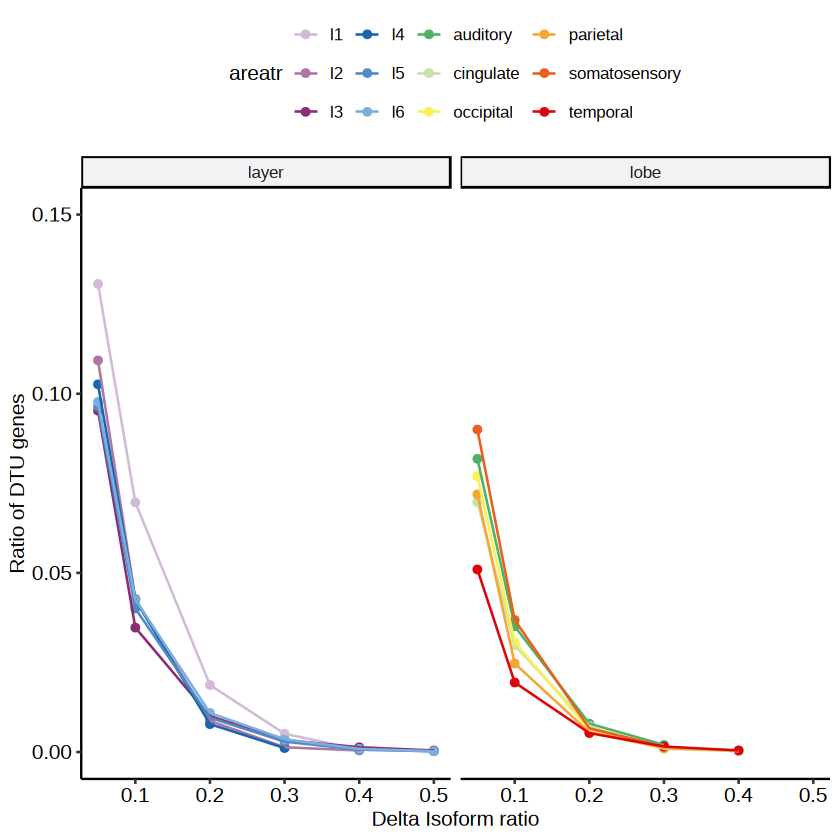

In [17]:
isostdf = isostdf[order(isostdf$group,isostdf$areatr),]
isostdf$areatr = factor(isostdf$areatr,levels = unique(isostdf$areatr))
p2.1 = ggplot(isostdf,aes(x = thred,y = ratio,color = areatr,group = areatr)) + geom_point() + geom_line() +
scale_y_continuous(limits = c(0,0.15)) + 
facet_wrap(~group,nrow = 1) + scale_color_discreterainbow() + theme_pubr() +
xlab("Delta Isoform ratio") + ylab("Ratio of DTU genes")
p2.1
ggexport(p2.1,filename = "result/figure2/sigiso_number_stat_lobe_layer_proportion_25_10_11.pdf",width = 5,height = 4)

In [238]:
genetrst = fsraw.cor %>% group_by(gene_id) %>% 
    mutate(readnumt = length(unique(readid))) %>% 
    group_by(gene_id,transcript_id)  %>% 
    summarise(readnum = length(unique(readid)),
              readnumt = readnumt[1],
              readrate = readnum/readnumt)
fsgenest = fsraw.cor %>% group_by(layer, gene_id) %>% summarise(readnum = length(unique(readid)))
summary(genetrst$readrate)
genetrstf = genetrst[genetrst$readrate > 0.05,]

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'layer'. You can override using the
`.groups` argument.


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000005 0.0282954 0.5714286 0.5276932 1.0000000 1.0000000 

[1] 117

[1] 981

[1] 864

file saved to result/figure2/sigiso_number_stat_lobe_layer_25_10_11.pdf



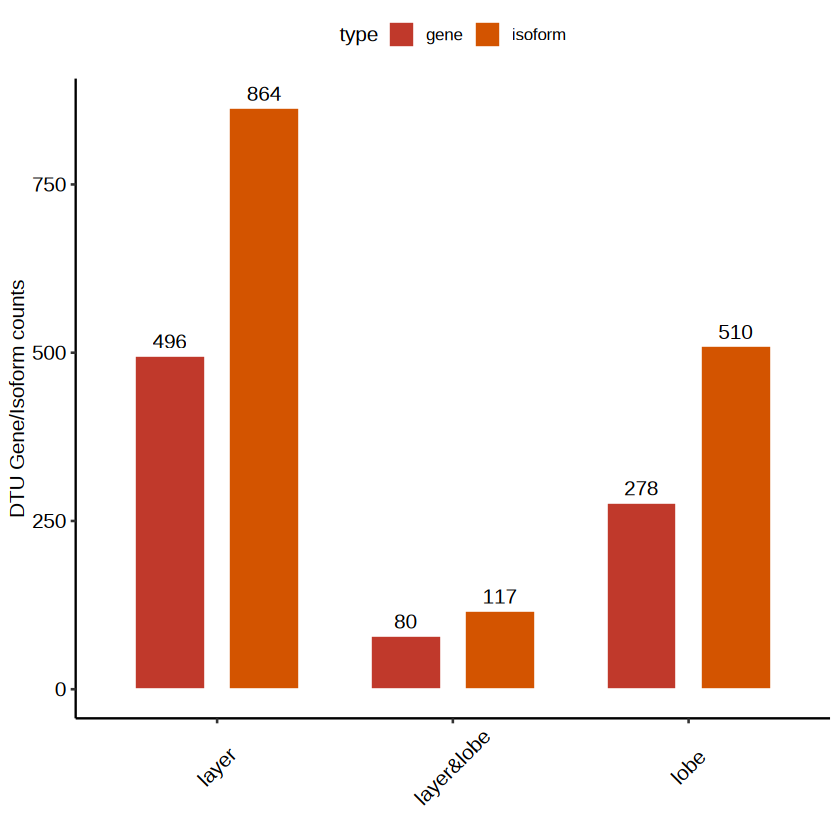

In [18]:
dtustdf = NULL
for(i in c(1,3)){
    isosigi = isosigls[[i]]
    isosigi = isosigi[isosigi$sig != "N",]
    dtugn = length(unique(isosigi$gene_id))
    dtutn = length(unique(isosigi$transcript_id[isosigi$transcript_id %in% fsraw.cor$transcript_id]))
    dtustdf = rbind(dtustdf,data.frame("count" = c(dtugn,dtutn),"type" = c("gene","isoform"),"group" = names(isosigls)[i]))
}

library(ggvenn)
#get layer dtu
isosigi = isosigls$layer
isosigi = isosigi[!isosigi$sig %in% c("N"), ]
dtugn.layer = unique(isosigi$gene_id)
dtutn.layer = unique(isosigi$transcript_id)

#get layer marker
# mkgene.layer = mkls$layer
# colnames(mkgene.layer)[7] = "gene_id"
# mkgene.layer = mkgene.layer[mkgene.layer$avg_log2FC > 0.5 & mkgene.layer$p_val_adj < 0.05 & mkgene.layer$pct.1 > 0.25, ]
# mkgene.layer = unique(mkgene.layer$gene_id)
# mkiso.layer = unique(fsraw.cor[fsraw.cor$gene_id %in% mkgene.layer,]$transcript_id)

#get lobe dtu
isosigi = isosigls$lobe
isosigi = isosigi[!isosigi$sig %in% c("N"), ]
dtugn.lobe = unique(isosigi$gene_id)
dtutn.lobe = unique(isosigi$transcript_id)

#get lobe marker
# mkgene.lobe = mkls$lobe
# colnames(mkgene.lobe)[7] = "gene_id"
# mkgene.lobe = mkgene.lobe[mkgene.lobe$avg_log2FC > 0.5 & mkgene.lobe$p_val_adj < 0.05 & mkgene.lobe$pct.1 > 0.25, ]
# mkgene.lobe = unique(mkgene.lobe$gene_id)
# mkiso.lobe = unique(fsraw.cor[fsraw.cor$gene_id %in% mkgene.lobe,]$transcript_id)

#get common dtu
dtugn.com = intersect(dtugn.lobe,dtugn.layer)
dtutn.com = intersect(dtutn.lobe,dtutn.layer)
length(dtutn.com)
#mkgene.com = c(mkgene.lobe,mkgene.layer)
#mkiso.com = c(mkiso.layer,mkiso.lobe)

#delet common dtu
dtugn.layer = dtugn.layer[!dtugn.layer %in% dtugn.com]
length(dtutn.layer)
dtutn.layer = dtutn.layer[!dtutn.layer %in% dtutn.com]
length(dtutn.layer)
dtugn.lobe = dtugn.lobe[!dtugn.lobe %in% dtugn.com]
dtutn.lobe = dtutn.lobe[!dtutn.lobe %in% dtutn.com]

dtustdf = data.frame("count" = c(length(dtugn.layer),
                       length(dtugn.lobe),
                       length(dtugn.com),
                       length(dtutn.layer),
                       length(dtutn.lobe),
                       length(dtutn.com)),
           "type" = c(rep("gene",3),rep("isoform",3)),
           "group" = c("layer","lobe","layer&lobe","layer","lobe","layer&lobe"))

# dtustdf = data.frame("count" = c(length(dtugn.layer[!dtugn.layer %in% mkgene.layer]),
#                        length(dtugn.layer[dtugn.layer %in% mkgene.layer]),
#                        length(dtugn.lobe[!dtugn.lobe %in% mkgene.lobe]),
#                        length(dtugn.lobe[dtugn.lobe %in% mkgene.lobe]),
#                        length(dtugn.com[!dtugn.com %in% mkgene.com]),
#                        length(dtugn.com[dtugn.com %in% mkgene.com]),
#                        length(dtutn.layer[!dtutn.layer %in% mkiso.layer]),
#                        length(dtutn.layer[dtutn.layer %in% mkiso.layer]),
#                        length(dtutn.lobe[!dtutn.lobe %in% mkiso.lobe]),
#                        length(dtutn.lobe[dtutn.lobe %in% mkiso.lobe]),
#                        length(dtutn.com[!dtutn.com %in% mkiso.com]),
#                        length(dtutn.com[dtutn.com %in% mkiso.com])),
#            "type" = c(rep("gene",6),rep("isoform",6)),
#            "group" = c(rep("layer",2),rep("lobe",2),rep("layer&lobe",2),rep("layer",2),rep("lobe",2),rep("layer&lobe",2)),
#            "MarkerGene" = c(rep(c("No","Yes"),6))
#           )

p2.1 = ggplot(dtustdf,aes(x = group,fill = type,y = count)) + 
geom_bar(stat = "identity",position = position_dodge(0.8),color = "white",width = 0.6) + 
geom_text(aes(label = count),position = position_dodge(0.8),vjust = -0.5) + 
#facet_grid(~type,scales = "free") +
theme_pubr() + theme(axis.text.x = element_text(angle = 45,vjust = 0.5)) +
labs(x = "",y = "DTU Gene/Isoform counts") + scale_fill_flatui()
p2.1
ggexport(p2.1,filename = "result/figure2/sigiso_number_stat_lobe_layer_25_10_11.pdf",width = 4,height = 4)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
file saved to result/figure2/dtu_deg_venn_stat_region_layer_25_10_11.pdf



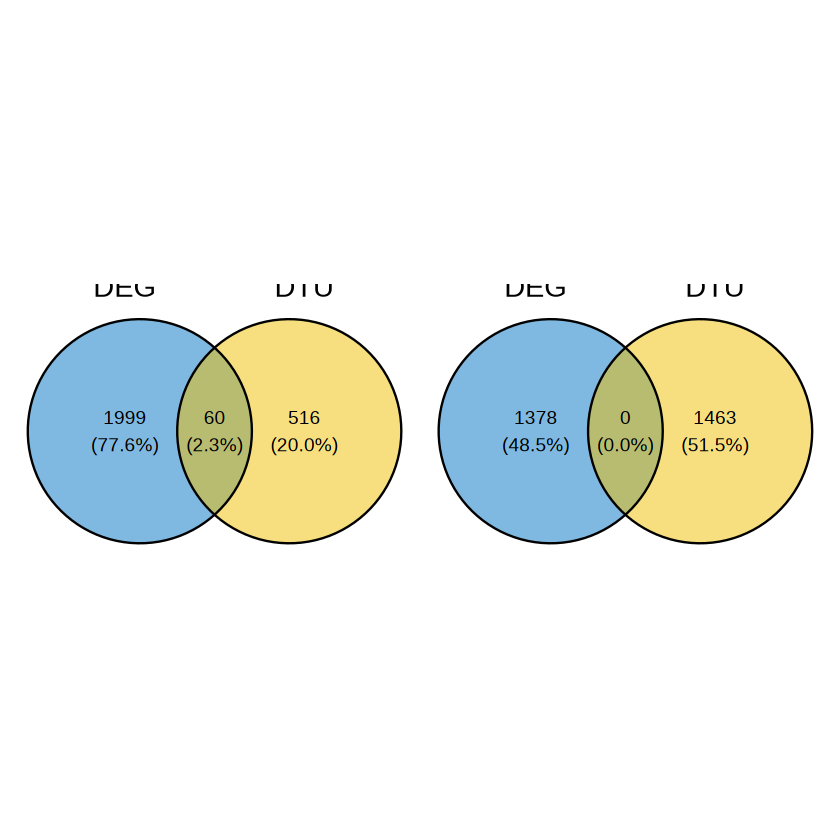

In [19]:
isosigi = isosigls$layer
isosigi = isosigi[!isosigi$sig %in% c("N"), ]
dtu.layer = unique(isosigi$gene_id)
mkly = mkls$layer
mkly = mkly[mkly$p_val_adj < 0.05 & abs(mkly$avg_log2FC) > 1  & mkly$pct.1 > 0.1, ]
deg.layer = mkly$gene
pst1.1 = ggvenn(list("DEG" = deg.layer, "DTU" = dtu.layer),stroke_size = 0.5) + scale_fill_jco()

# isosigi = isosigls$lobe
# isosigi = isosigi[!isosigi$sig %in% c("N"), ]
# dtu.lobe = unique(isosigi$gene_id)
# mklb = mkls$lobe
# mklb = mklb[mklb$p_val_adj < 0.05 & mklb$avg_log2FC > 1  & mklb$pct.1 > 0.1, ]
# deg.lobe = mklb$gene
# pst1.2 = ggvenn(list("DEG" = deg.lobe, "DTU" = dtu.lobe),stroke_size = 0.5)  + scale_fill_jco()
isosigi = isosigls$region
isosigi = isosigi[!isosigi$sig %in% c("N"), ]
dtu.region = unique(isosigi$gene_id)
mkly = mkls$region
mkly = mkly[mkly$p_val_adj < 0.05 & abs(mkly$avg_log2FC) > 1  & mkly$pct.1 > 0.1, ]
deg.region = unique(mkly$gene)
# isosigi = isosigls$lobe
# isosigi = isosigi[!isosigi$sig %in% c("N"), ]
# dtu.lobe = unique(isosigi$gene_id)
pst1.2 = ggvenn(list("DEG" = deg.region, "DTU" = dtu.region),stroke_size = 0.5) + scale_fill_jco()
pst1.1 + pst1.2
ggexport(pst1.1 + pst1.2,filename = "result/figure2/dtu_deg_venn_stat_region_layer_25_10_11.pdf",width = 6,height = 4)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


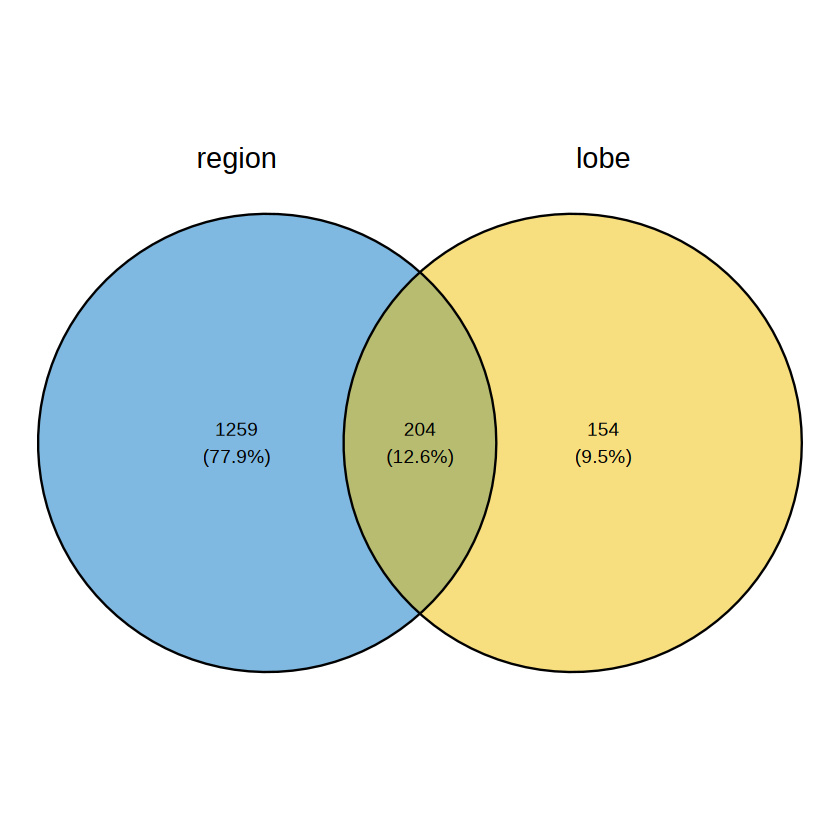

In [21]:
isosigi = isosigls$region
isosigi = isosigi[!isosigi$sig %in% c("N"), ]
dtu.region= unique(isosigi$gene_id)

isosigi = isosigls$lobe
isosigi = isosigi[!isosigi$sig %in% c("N"), ]
dtu.lobe = unique(isosigi$gene_id)
ggvenn(list("region" = dtu.region, "lobe" = dtu.lobe),stroke_size = 0.5) + scale_fill_jco()

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
file saved to result/figure2/sigiso_stat_basic_dtun_layer&lobe_25_10_11.pdf



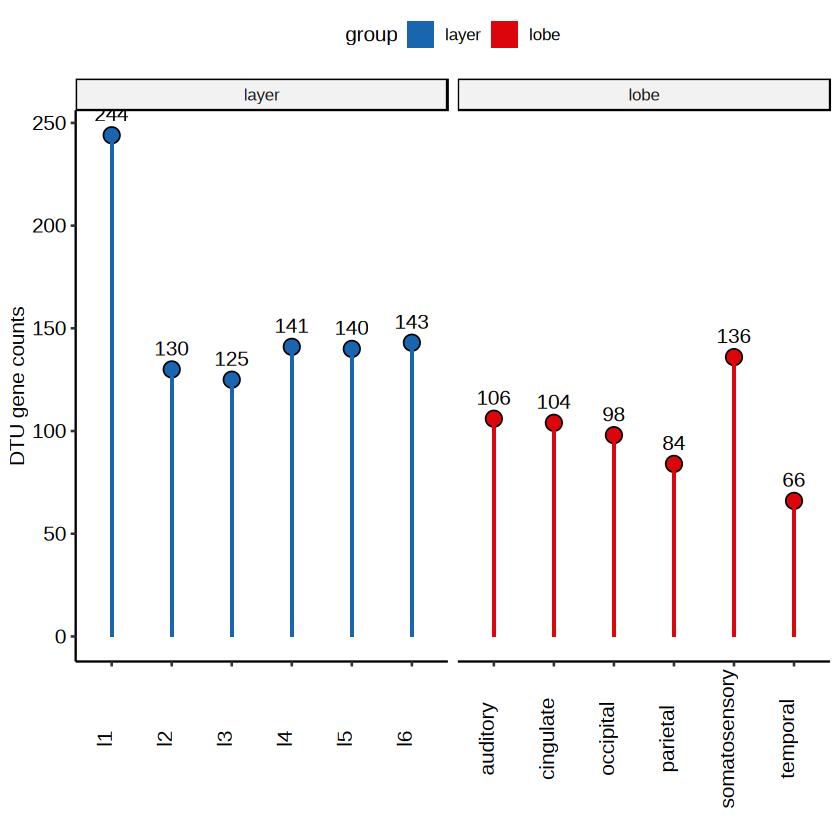

In [24]:
dtustdf = NULL
for(i in c(1,3)){
    isosigi = isosigls[[i]]
    isosigi = isosigi[isosigi$sig == "Up",]
    isosigi$group = names(isosigls)[i]
    dtustdf = rbind(dtustdf,isosigi)
}
#isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_24_04_30.qs")
# dtustdf$genetype = "Known"
# dtustdf[substr(dtustdf$gene_id,1,5) == "Bambu",]$genetype = "Novel"
# length(unique(dtustdf[substr(dtustdf$gene_id,1,5) == "Bambu",]$gene_id))
dtustdf.st = dtustdf %>% group_by(group,areatr) %>% summarise(dtun = length(unique(gene_id)))
pison1 = ggplot(dtustdf.st,aes(x = areatr,y = dtun,fill = group)) + 
    geom_point(position = position_dodge(0.5),shape = 21,size = 4) + 
    geom_bar(position = position_dodge(0.5),stat = "identity",width = 0.05) +
    facet_grid(~group,space = "free",scale = "free") +
    geom_text(position = position_dodge(0.5),aes(label=dtun),vjust = -1) + 
    scale_fill_discreterainbow() +
    scale_color_discreterainbow() +
    theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0)) + 
    xlab("") + ylab("DTU gene counts")
pison1

ggexport(pison1,filename = "result/figure2/sigiso_stat_basic_dtun_layer&lobe_25_10_11.pdf",width = 5,height = 5)

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
file saved to result/figure2/sigiso_stat_basic_dtun_region_25_10_11.pdf



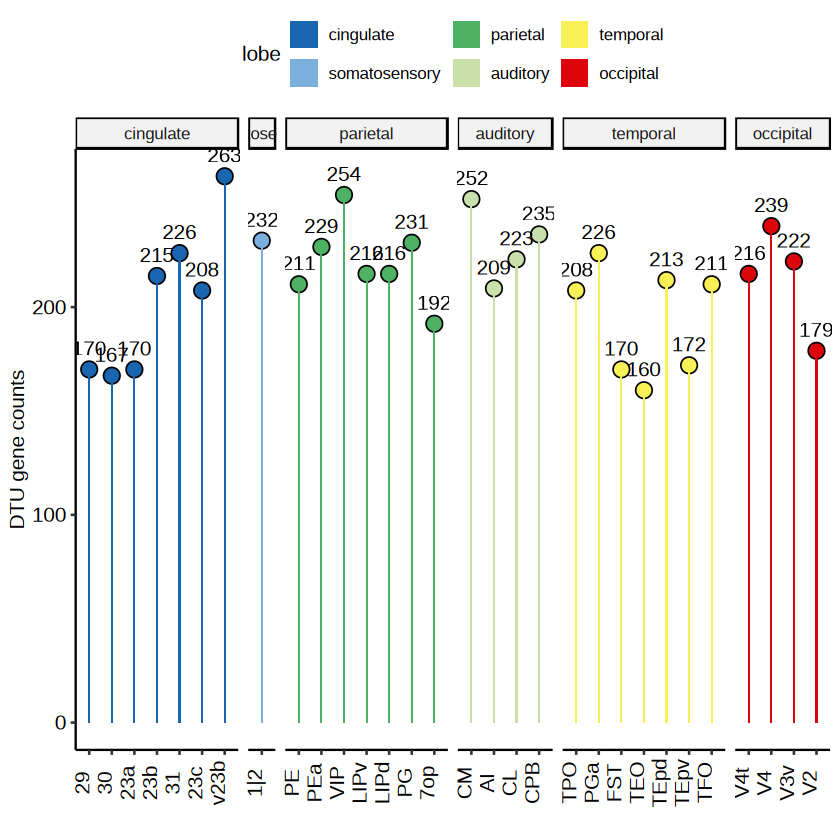

In [25]:
regionorder = c("29","30","23a","23b","31","23c","1|2","PE","PEa","VIP","LIPv","LIPd","PG","7op","CM","AI","CL","CPB","TPO",
               "PGa","FST","V4t","V4","TEO","TEpd","TEpv","TFO","V3v","V2","v23b")
lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
isosigi = isosigls$region
isosigi = isosigi[isosigi$sig != "N",]
isosigi$group = "region"
dtustdf.st = isosigi %>% group_by(group,areatr) %>% summarise(dtun = length(unique(gene_id)))
dtustdf.st = merge(dtustdf.st,areaan,by.x = "areatr",by.y = "area")
dtustdf.st$areatr = factor(dtustdf.st$areatr,levels = regionorder)
dtustdf.st$lobe = factor(dtustdf.st$lobe,levels = lobeorder)
pison1 = ggplot(dtustdf.st,aes(x = areatr,y = dtun,fill = lobe)) + 
    geom_point(position = position_dodge(0.5),shape = 21,size = 4) + 
    geom_bar(position = position_dodge(0.5),stat = "identity",width = 0.05) +
    facet_grid(~lobe,space = "free",scale = "free") +
    geom_text(position = position_dodge(0.5),aes(label=dtun),vjust = -1) + 
    scale_fill_discreterainbow() +
    scale_color_discreterainbow() +
    theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0)) + 
    xlab("") + ylab("DTU gene counts")
pison1
ggexport(pison1,filename = "result/figure2/sigiso_stat_basic_dtun_region_25_10_11.pdf",width = 6,height = 4)

In [26]:
isosigi = isosigls$region
isosigi = isosigi[isosigi$sig != "N",]
length(unique(isosigi$gene_id))

[1] 1463

Warning message:
"package 'ggupset' was built under R version 4.3.3"
file saved to result/figure2/sigiso_stat_basic_dtun_layer&lobe&region_upset_25_10_11.pdf



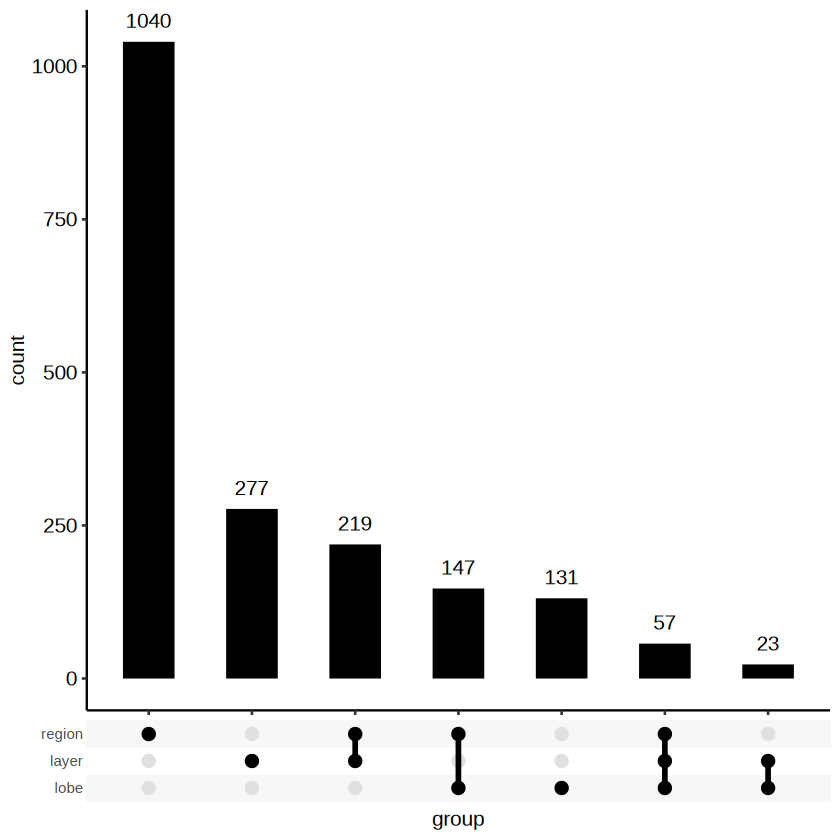

In [27]:
#upset plot
#install.packages("ggupset")
isosigr = isosigls$region
isosigr = isosigr[isosigr$sig != "N",]
isosigr$group = "region"

isosigl = isosigls$layer
isosigl = isosigl[isosigl$sig != "N",]
isosigl$group = "layer"

isosigb = isosigls$lobe
isosigb = isosigb[isosigb$sig != "N",]
isosigb$group = "lobe"
dtustdf = rbind(isosigr,isosigl,isosigb)
library(ggupset)
dtustdfup = unique(dtustdf[,c("gene_id","group")])
dtustdfup = dtustdfup %>%
  group_by(gene_id) %>%
  summarize(group = list(group))
# pisonup1 = ggplot(data = dtustdfup[dtustdfup$group == "layer",],
#             aes(x = areatr)) +
#   scale_x_upset(sets = paste0("l",1:6)) + geom_bar(fill = "black",width = 0.5) + theme_pubr()
# pisonup1

pisonup2 = ggplot(data = dtustdfup,
            aes(x = group)) +
  scale_x_upset() + 
 geom_bar(fill = "black",width = 0.5) + 
 geom_text(stat = "count",aes(label=after_stat(count)),vjust = -1) + 
    theme_pubr()
pisonup2
library(ggpubr)
library(ggplot2)
ggexport(pisonup2,filename = "result/figure2/sigiso_stat_basic_dtun_layer&lobe&region_upset_25_10_11.pdf",width = 4,height = 4)

#### DTU Case count pie plot

In [16]:
caseg = c("CD47",'NTRK2',"DDRGK1","ARPP19","DBNDD2","TPM3")
#"ARPP21"
isosigi = isosigls$layer
transsig = c("XM_015452432.1","XM_005541217.2","XR_001492897.1", "XM_005541701.2","XM_005541710.2",
             'XM_005570477.2','XM_005570483.2',' NM_001284070.1','XM_005541713.2',"XM_005548232.2","XM_005548234.2",
             unique(isosigi[isosigi$sig != "N" & isosigi$gene_id %in% caseg,]$transcript_id))
transsig
fsraw.cor.hub = fsraw.cor[fsraw.cor$gene_id %in% caseg & fsraw.cor$layer %in% paste0("l",1:6),]
isosigi = isosigls$layer
casect = fsraw.cor.hub %>% group_by(layer,lobe,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(layer,lobe,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)


[1] "XM_015452432.1"  "XM_005541217.2"  "XR_001492897.1"  "XM_005541701.2" 
 [5] "XM_005541710.2"  "XM_005570477.2"  "XM_005570483.2"  " NM_001284070.1"
 [9] "XM_005541713.2"  "XM_005548232.2"  "XM_005548234.2"  "NM_001283415.1" 
[13] "XM_005548232.2"  "XM_005548234.2"  "XM_005569136.2"  "XM_015429879.1" 
[17] "DDRGK1-FS-1"     "XM_005568473.2"  "XM_005582047.2"  "XM_005582051.2" 
[21] "XM_005541710.2"

`summarise()` has grouped output by 'layer', 'lobe', 'gene_id'. You can
override using the `.groups` argument.


In [17]:
test = fsraw.cor.hub[fsraw.cor.hub$transcript_id %in% transsig,]
unique(paste0(test$gene_id,"-",test$transcript_id))

[1] "ARPP19-XM_015452432.1" "CD47-XM_005548232.2"   "DBNDD2-XM_005569136.2"
 [4] "TPM3-XM_005541710.2"   "DDRGK1-XM_005568473.2" "DBNDD2-XM_015429879.1"
 [7] "ARPP19-NM_001283415.1" "TPM3-XM_005541713.2"   "NTRK2-XM_005582051.2" 
[10] "CD47-XM_005548234.2"   "NTRK2-XM_005582047.2"  "DDRGK1-DDRGK1-FS-1"

In [18]:
casect.totall = fsraw.cor.hub %>% group_by(layer,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(layer,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)
casect.totall$lobe = "Total"
casect.totalb = fsraw.cor.hub %>% group_by(lobe,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(lobe,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)
casect.totalb$layer = "Total"
casect.total = fsraw.cor.hub %>% group_by(gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)
casect.total$layer = "Total"
casect.total$lobe = "Total"

casect = rbind(casect.totall,casect.totalb,casect.total,casect)
casect = casect[casect$transcript_id %in% transsig,]
casect = casect %>% group_by(gene_id) %>% mutate(id = as.character(as.numeric(as.factor(transcript_id))))
casect$gene_tran = paste0(casect$gene_id,"-",casect$id)
#casect = casect[casect$genecount > 5,]
casectl = dcast(casect,layer+lobe+gene_id~id,value.var = "rate")
casectl$group = paste0(casectl$layer,"-",casectl$lobe,"-",casectl$gene_id)
casectl[is.na(casectl)] = 0
casectl$layerid = as.numeric(factor(casectl$layer,levels = c(paste0("l",1:6),"Total")))
casectl$lobeid = as.numeric(factor(casectl$lobe,levels = c("Total",lobeorder)))
unique(casectl$lobe)

`summarise()` has grouped output by 'layer', 'gene_id'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lobe', 'gene_id'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


[1] "auditory"      "cingulate"     "occipital"     "parietal"     
[5] "somatosensory" "temporal"      "Total"

In [19]:
# mean(casectl[casectl$gene_id == "NTRK2" & casectl$lobe == "Total" & casectl$layer %in% paste0("l",2:6),]$`2`)
# casectl[casectl$gene_id == "NTRK2" & casectl$lobe == "Total" ,]
# mean(casectl[casectl$gene_id == "CD47" & casectl$lobe == "Total" & casectl$layer %in% paste0("l",2:6),]$`2`)
# casectl[casectl$gene_id == "CD47" & casectl$lobe == "Total" ,]

mean(casectl[casectl$gene_id == "DDRGK1" & casectl$lobe == "Total" & casectl$layer %in% paste0("l",1:3),]$`1`)
mean(casectl[casectl$gene_id == "DDRGK1" & casectl$lobe == "Total" & casectl$layer %in% paste0("l",4:6),]$`1`)

mean(casectl[casectl$gene_id == "ARPP19" & casectl$lobe == "Total" & casectl$layer %in% paste0("l",2:3),]$`1`)
mean(casectl[casectl$gene_id == "ARPP19" & casectl$lobe == "Total" & casectl$layer %in% paste0("l",4:6),]$`1`)

casectl[casectl$gene_id == "TPM3" & casectl$layer == "Total",]
mean(casectl[casectl$gene_id == "TPM3" & casectl$layer == "Total" & !casectl$lobe %in% "somatosensory",]$`2`)
# mean(casectl[casectl$gene_id == "DBNDD2" & casectl$lobe == "Total" & casectl$layer %in% paste0("l",1:5),]$`2`)
# casectl[casectl$gene_id == "DBNDD2" & casectl$lobe == "Total" ,]

[1] 0.6301205

[1] 0.3965281

[1] 0.479707

[1] 0.3580054

layer lobe          gene_id 1         2          group                   
258 Total auditory      TPM3    0.6154769 0.05038992 Total-auditory-TPM3     
264 Total cingulate     TPM3    0.5308489 0.08902692 Total-cingulate-TPM3    
270 Total occipital     TPM3    0.5987090 0.07315761 Total-occipital-TPM3    
276 Total parietal      TPM3    0.5934550 0.07950493 Total-parietal-TPM3     
282 Total somatosensory TPM3    0.4698243 0.11000764 Total-somatosensory-TPM3
288 Total temporal      TPM3    0.5697768 0.07727533 Total-temporal-TPM3     
294 Total Total         TPM3    0.5706438 0.07869121 Total-Total-TPM3        
    layerid lobeid
258 7       5     
264 7       2     
270 7       7     
276 7       4     
282 7       3     
288 7       6     
294 7       1

[1] 0.07467432

[1] "#C182C5" "#B8D39F"

file saved to result/figure2/case_layer_isoform_rate_stat_pie_25_11_25.pdf



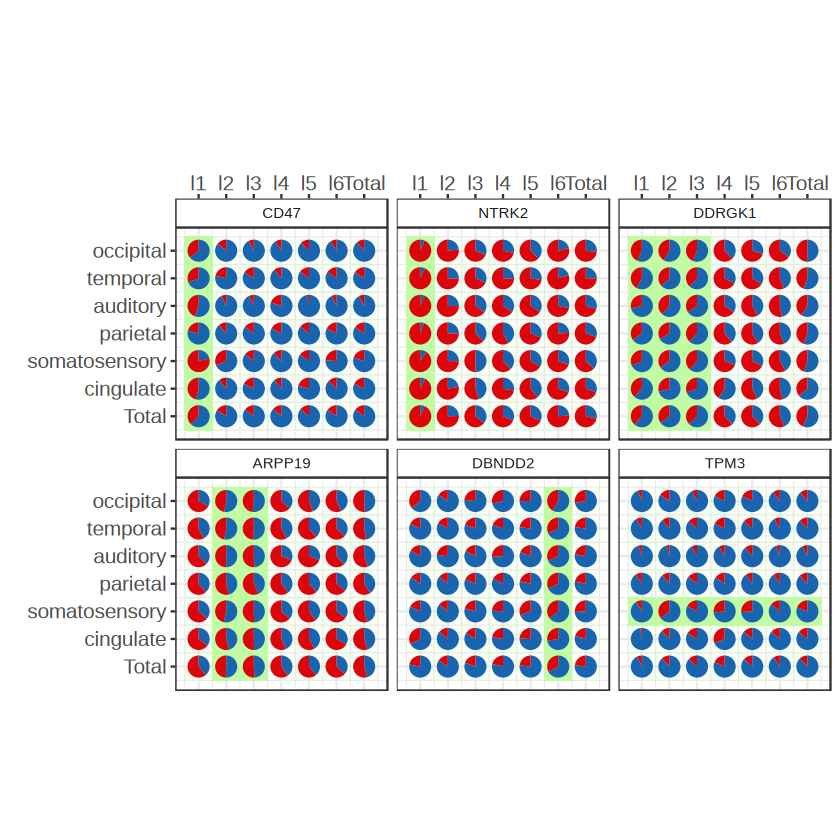

In [36]:
library(patchwork)
library(scatterpie)
#caseg = c("MYL6",'NTRK2',"DBNDD2","DDRGK1","ARPP19","KCNIP4")
mycolors = distinctColorPalette(2)
mycolor =  c('#1864AF','#DC050B','#F7EF55')
mycolors
#names(mycolors) = transname

casectl$gene_id = factor(casectl$gene_id,levels = caseg)
casectl$sig = 'N'
casectl$siggroup = paste0(casectl$gene_id,"-",casectl$layer)
casectl[casectl$siggroup %in% c("CD47-l1","NTRK2-l1","DDRGK1-l1","DDRGK1-l2","DDRGK1-l3",
                                "ARPP19-l2","ARPP19-l3","DBNDD2-l6"),]$sig = "Y"
casectl$siggroup = paste0(casectl$gene_id,"-",casectl$lobe)
casectl[casectl$siggroup %in% c("TPM3-somatosensory"),]$sig = "Y"
casectl$alpha = 0
casectl[casectl$sig == "Y",]$alpha = 0.3
#casectl
# isosigi = isosigls$layer
# isosigi = isosigi[isosigi$sig != "N",]
# casectl[paste0(casectl$layer,casectl$gene_id) %in% paste0(isosigi$areatr,isosigi$gene_id),]$sig = "Y"

plt = ggplot(data = casectl,aes(x = layerid, y = lobeid)) + 
      geom_tile(aes(alpha = alpha),fill = "#c1fba4") +
      geom_scatterpie(data = casectl,aes(x = layerid, y = lobeid,group = group,r = 0.4),color=NA,
                      cols=colnames(casectl)[4:5]) + 
      facet_wrap(~gene_id,nrow = 2) +
      # geom_histogram(data = root_sprn,aes(mean.model),bins = 100) +
      coord_fixed() +
      scale_x_continuous(breaks = c(1:7),labels = c(paste0("l",1:6),"Total"),position = "top")+
      scale_y_continuous(breaks = c(1:7),labels = c("Total",lobeorder)) +
      # geom_smooth(data = tem2, aes(x=x, y=y), se = F, method = 'loess',color = "black") +
      scale_fill_manual(values = mycolor) +
      #scale_fill_manual(values = mycolors) +
      #annotate("text", x = 8, y = 7, label = caseg[i], hjust = 1.1, vjust = 1.1, size = 5, angle = 90) +
      ylab("") + xlab("") +
      theme_bw() + theme(legend.position="none",axis.text = element_text(size = 12),
                        strip.background =element_rect(fill="white"))
plt
ggexport(plt,filename = "result/figure2/case_layer_isoform_rate_stat_pie_25_11_25.pdf",width = 9,height = 4)

In [24]:
casectl

layer lobe          gene_id 1          2         
1   l1    auditory      ARPP19  0.35593220 0.59322034
2   l1    auditory      CD47    0.50000000 0.40000000
3   l1    auditory      DBNDD2  0.70000000 0.13333333
4   l1    auditory      DDRGK1  0.71186441 0.28813559
5   l1    auditory      NTRK2   0.05357143 0.81250000
6   l1    auditory      TPM3    0.66666667 0.03508772
7   l1    cingulate     ARPP19  0.33132530 0.61445783
8   l1    cingulate     CD47    0.50000000 0.42307692
9   l1    cingulate     DBNDD2  0.53932584 0.25842697
10  l1    cingulate     DDRGK1  0.61807580 0.38192420
11  l1    cingulate     NTRK2   0.05899705 0.74336283
12  l1    cingulate     TPM3    0.75700935 0.01869159
13  l1    occipital     ARPP19  0.30392157 0.61764706
14  l1    occipital     CD47    0.64285714 0.35714286
15  l1    occipital     DBNDD2  0.56140351 0.31578947
16  l1    occipital     DDRGK1  0.56818182 0.43181818
17  l1    occipital     NTRK2   0.05376344 0.76881720
18  l1    occipital     TPM3    0.77450980 0.04901961
19  l1    parietal      ARPP19  0.35057471 0.55747126
20  l1    parietal      CD47    0.70370370 0.18518519
21  l1    parietal      DBNDD2  0.79687500 0.14062500
22  l1    parietal      DDRGK1  0.65000000 0.35000000
23  l1    parietal      NTRK2   0.04285714 0.72857143
24  l1    parietal      TPM3    0.56976744 0.05813953
25  l1    somatosensory ARPP19  0.35227273 0.61363636
26  l1    somatosensory CD47    0.21428571 0.78571429
27  l1    somatosensory DBNDD2  0.78723404 0.17021277
28  l1    somatosensory DDRGK1  0.68456376 0.31543624
29  l1    somatosensory NTRK2   0.06818182 0.64772727
30  l1    somatosensory TPM3    0.63636364 0.06060606
⋮   ⋮     ⋮             ⋮       ⋮          ⋮         
265 Total occipital     ARPP19  0.4648986  0.48299532
266 Total occipital     CD47    0.8674419  0.10930233
267 Total occipital     DBNDD2  0.6316872  0.24348422
268 Total occipital     DDRGK1  0.5051233  0.49487666
269 Total occipital     NTRK2   0.2024867  0.55772647
270 Total occipital     TPM3    0.5987090  0.07315761
271 Total parietal      ARPP19  0.3876077  0.55640456
272 Total parietal      CD47    0.8253968  0.14814815
273 Total parietal      DBNDD2  0.6810794  0.19165900
274 Total parietal      DDRGK1  0.5589025  0.44109752
275 Total parietal      NTRK2   0.2211356  0.51073078
276 Total parietal      TPM3    0.5934550  0.07950493
277 Total somatosensory ARPP19  0.4333454  0.51434798
278 Total somatosensory CD47    0.7905605  0.19764012
279 Total somatosensory DBNDD2  0.6500701  0.22650771
280 Total somatosensory DDRGK1  0.5486911  0.45130890
281 Total somatosensory NTRK2   0.2795600  0.47662695
282 Total somatosensory TPM3    0.4698243  0.11000764
283 Total temporal      ARPP19  0.4500778  0.50123185
284 Total temporal      CD47    0.8146479  0.15492958
285 Total temporal      DBNDD2  0.6651008  0.19654493
286 Total temporal      DDRGK1  0.5549160  0.44508397
287 Total temporal      NTRK2   0.1962443  0.57110092
288 Total temporal      TPM3    0.5697768  0.07727533
289 Total Total         ARPP19  0.4337439  0.51642907
290 Total Total         CD47    0.8259620  0.14772225
291 Total Total         DBNDD2  0.6678002  0.20069317
292 Total Total         DDRGK1  0.5652024  0.43479758
293 Total Total         NTRK2   0.2142270  0.53949994
294 Total Total         TPM3    0.5706438  0.07869121
    group                      layerid lobeid sig siggroup             alpha
1   l1-auditory-ARPP19         1       5      N   ARPP19-auditory      0.0  
2   l1-auditory-CD47           1       5      Y   CD47-auditory        0.3  
3   l1-auditory-DBNDD2         1       5      N   DBNDD2-auditory      0.0  
4   l1-auditory-DDRGK1         1       5      Y   DDRGK1-auditory      0.3  
5   l1-auditory-NTRK2          1       5      Y   NTRK2-auditory       0.3  
6   l1-auditory-TPM3           1       5      N   TPM3-auditory        0.0  
7   l1-cingulate-ARPP19        1       2      N   ARPP19-cingulate     0.0  
8   l1-cingulate-CD47          1       2

In [33]:
colnames(casectl)[4:6]

[1] "1"     "2"     "group"

#### DTU clone analysis of layers

In [58]:
isosigi = isosigls$layer
hubtrans = unique(isosigi[isosigi$sig %in% c("Up","Down"),]$transcript_id)
isosigf2 = isosigi[isosigi$transcript_id %in% hubtrans,]
isosigf2$dr2 = isosigf2$relative - isosigf2$meanrelative
print(length(unique(isosigf2$transcript_id)))
isosigf2 = isosigf2 %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
isosigf2$dr2 = isosigf2$relative - isosigf2$meanrelative
print(length(unique(isosigf2$gene_id)))
isosigf.mx1 = dcast(isosigf2,transcript_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigf.mx1) = isosigf.mx1$transcript_id;isosigf.mx1 = isosigf.mx1[-1]
head(isosigf.mx1)

[1] 981
[1] 576


l1          l2           l3          l4           l5          
APOM-FS-2      -0.19906815 -0.008215757 -0.01840881  0.283676135  0.044581226
ARMCX5-FS-1     0.00000000  0.030395709  0.01335025 -0.168678365 -0.004421642
ASGR1-FS-3      0.15144928 -0.109420290  0.03115942 -0.135507246 -0.135507246
BIN1-FS-1       0.21244500 -0.022129465 -0.18992342 -0.038745473 -0.096801573
C15H9orf9-FS-1 -0.15842724 -0.014240779  0.07118922  0.001812125  0.017677510
C4H6orf52-FS-2  0.05482992  0.118494515 -0.01171143 -0.112312938 -0.019606171
               l6         
APOM-FS-2      -0.10256465
ARMCX5-FS-1     0.12935404
ASGR1-FS-3      0.19782609
BIN1-FS-1       0.13515493
C15H9orf9-FS-1  0.08198916
C4H6orf52-FS-2 -0.02969389

DDRGK1-FS-1 
          9

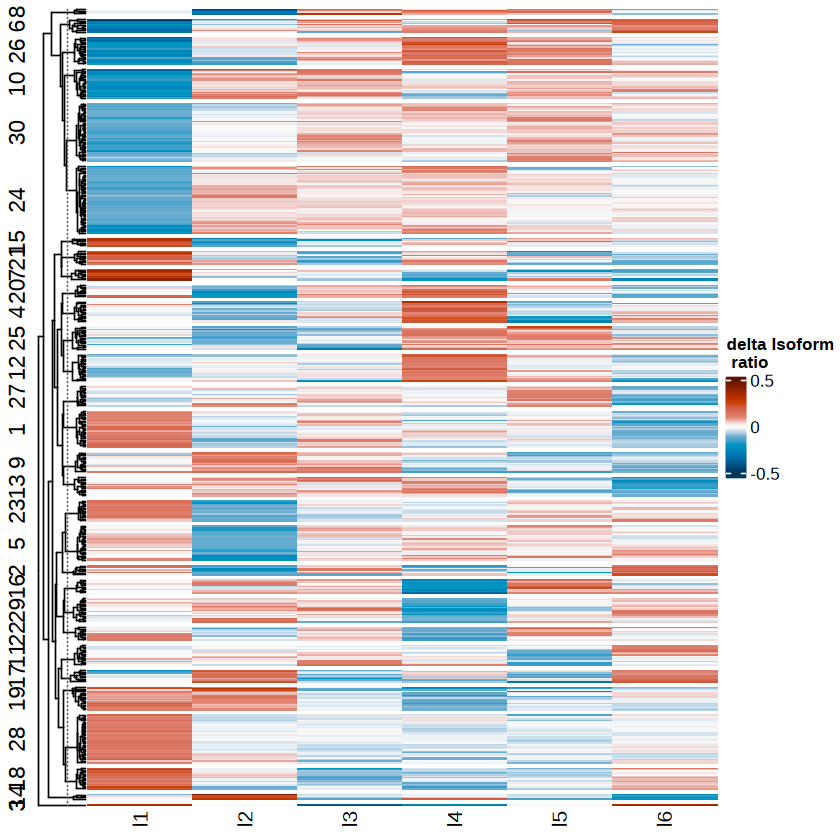

In [80]:
n = 30
isosigf.mx1f = isosigf.mx1[rowSums(isosigf.mx1 != 0) > 4,]
#isosigf.mx1fc = isosigf.mx1f
# isosigf.mx1fc[isosigf.mx1fc>0] = 1
# isosigf.mx1fc[isosigf.mx1fc<0] = -1
fit = kmeans(isosigf.mx1f,n)
fit$cluster["DDRGK1-FS-1"]
split <- factor(as.character(fit$cluster), levels=as.character(c(1:n)))
# 计算距离矩阵
# distances <- dist(isosigf.mx1)
# fit <- hclust(distances, method="ward.D2") # 你可以选择其他方法，如 "average", "single", "ward.D2" 等
# clusters <- cutree(fit, k=n)
# split <- factor(as.character(clusters), levels=as.character(c(1:n)))
library(circlize)
col_fun = colorRamp2(c(-0.5, -0.1, 0, 0.1, 0.5), hcl_palette = "RdBu",reverse = T)
isosigf.mx1f = as.matrix(isosigf.mx1f)
pcloneht1 = Heatmap(isosigf.mx1f,show_row_names = F,row_split = split,cluster_columns = F,
                    name = "delta Isoform\n ratio",col = col_fun)
pcloneht1

In [81]:
fit$cluster[fit$cluster == 9]

DDRGK1-FS-1 LOC102130709-FS-6 LOC102132317-FS-7      MICALL1-FS-2 
                9                 9                 9                 9 
        NEK3-FS-3    NM_001283415.1    NM_001284102.1         SSH2-FS-1 
                9                 9                 9                 9 
   XM_005546454.1    XM_005556303.2    XM_005572641.2    XM_005576671.2 
                9                 9                 9                 9 
   XM_005591352.2    XM_015446463.1       ZNF629-FS-1 
                9                 9                 9

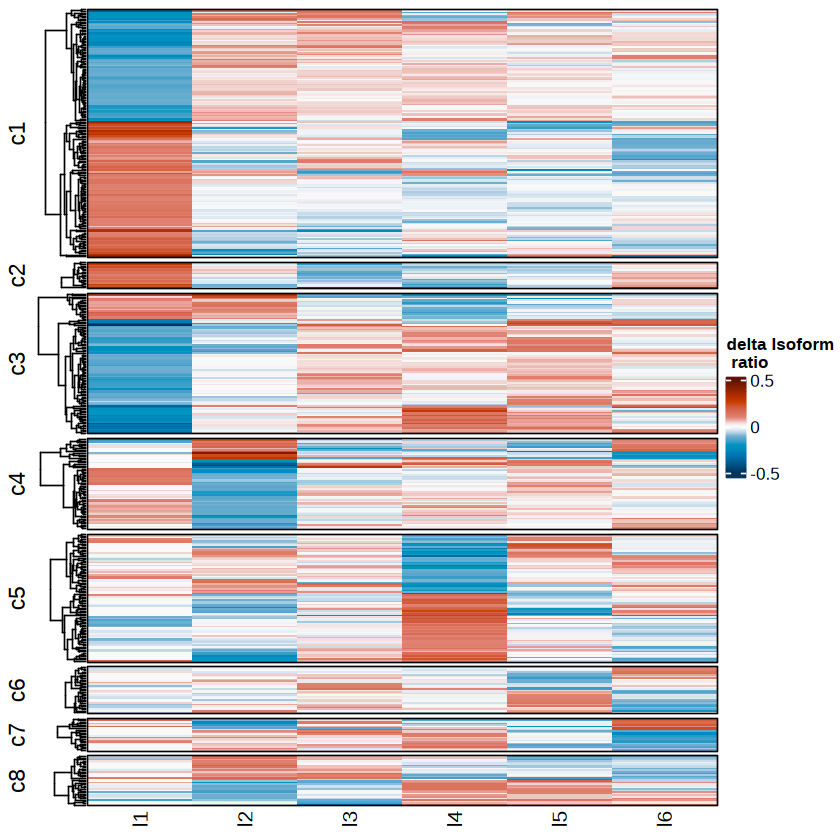

In [88]:
clist = list(c1 = c(24,28,7,10,1,15,21),
             c2 = c(18,3),
             c3 = c(30,26,6,19),
             c4 = c(17,14,5,23,8),
             c5 = c(12,4,20,16,22,29),
             c6 = c(27,11),
             c7 = c(13,2),
             c8 = c(25,9))
split <- fit$cluster
for (i in 1:length(clist)) {
    split[which(split %in% clist[[i]])] = names(clist)[i]
}
  
split <- factor(as.character(split), levels=names(clist))
names(split) = names(fit$cluster)
col_fun = colorRamp2(c(-0.5, -0.1, 0, 0.1, 0.5), hcl_palette = "RdBu",reverse = T)
pcloneht2 = Heatmap(isosigf.mx1f,show_row_names = F,row_split = split,
                    cluster_columns = F,cluster_row_slices = F,
                    border = T,
                    name = "delta Isoform\n ratio",col = col_fun)
pcloneht2

In [92]:
ggexport(pcloneht2,filename = "result/figure2/layer_sig_iso_clone_heatmap_25_10_11.pdf",width = 4,height = 6)

file saved to result/figure2/layer_sig_iso_clone_heatmap_25_10_11.pdf



In [91]:
clusteran = data.frame("cluster" = split,"transcript_id" = rownames(isosigf.mx1f))
isosigf2$cluster = clusteran[match(isosigf2$transcript_id,clusteran$transcript_id),]$cluster
clusteran = unique(isosigf2[,c("gene_id","transcript_id","cluster")])
clusteran[clusteran$gene_id %in% c("DDRGK1","ARPP21","ARPP19"),]
#write.csv(clusteran,file = "result/figure2/sigiso_layer_transcript_dr_cluster_tab_08_25.csv",row.names = F, quote = F)

gene_id transcript_id  cluster
1 ARPP19  NM_001283415.1 c8     
2 DDRGK1  DDRGK1-FS-1    c8

[1] 627
[1] 358


auditory    cingulate    occipital    parietal    somatosensory
ACBD7-FS-1      -0.07103819 -0.046933057 -0.005188976  0.01704365  0.1268804   
ANKRD65-FS-2     0.31615923 -0.087408219  0.000000000 -0.26954792  0.0000000   
ATG7-FS-1        0.12710575 -0.006111854 -0.146169326  0.03508383  0.0697446   
BIN1-FS-1        0.20076957 -0.180310218  0.072250780  0.04608927 -0.1332145   
C15H9orf85-FS-1 -0.02084790 -0.092930519 -0.045490760 -0.07884182  0.1420092   
CCDC146-FS-3     0.05690605  0.132984485  0.117646794 -0.10017728 -0.2078559   
                temporal     
ACBD7-FS-1      -0.0207637955
ANKRD65-FS-2     0.0407969092
ATG7-FS-1       -0.0796529933
BIN1-FS-1       -0.0055849431
C15H9orf85-FS-1  0.0961017665
CCDC146-FS-3     0.0004957973

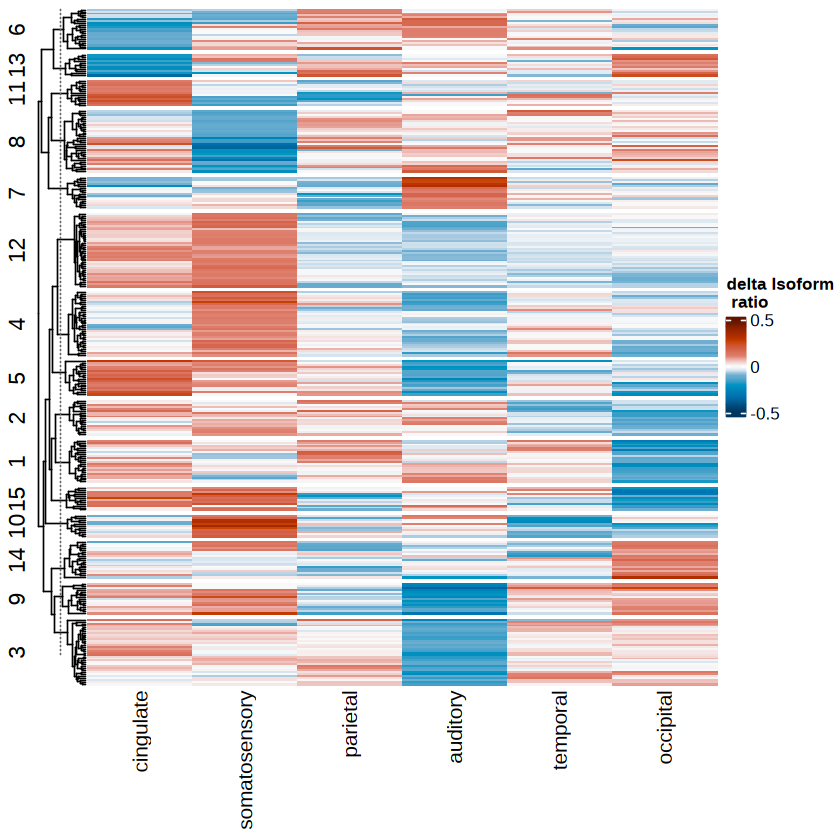

In [95]:
isosigi = isosigls$lobe
hubtrans = unique(isosigi[isosigi$sig %in% c("Up","Down"),]$transcript_id)
isosigf2 = isosigi[isosigi$transcript_id %in% hubtrans,]
isosigf2$dr2 = isosigf2$relative - isosigf2$meanrelative
print(length(unique(isosigf2$transcript_id)))
isosigf2 = isosigf2 %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
isosigf2$dr2 = isosigf2$relative - isosigf2$meanrelative
print(length(unique(isosigf2$gene_id)))
isosigf.mx1 = dcast(isosigf2,transcript_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigf.mx1) = isosigf.mx1$transcript_id;isosigf.mx1 = isosigf.mx1[-1]
head(isosigf.mx1)
n = 15
isosigf.mx1f = isosigf.mx1[rowSums(isosigf.mx1 != 0) > 4,]
fit = kmeans(isosigf.mx1f,n)
split <- factor(as.character(fit$cluster), levels=as.character(c(1:n)))
isosigf.mx1f = isosigf.mx1f[,lobeorder]
# 计算距离矩阵
# distances <- dist(isosigf.mx1)
# fit <- hclust(distances, method="ward.D2") # 你可以选择其他方法，如 "average", "single", "ward.D2" 等
# clusters <- cutree(fit, k=n)
# split <- factor(as.character(clusters), levels=as.character(c(1:n)))

library(circlize)
col_fun = colorRamp2(c(-0.5, -0.1, 0, 0.1, 0.5), hcl_palette = "RdBu",reverse = T)
isosigf.mx1f = as.matrix(isosigf.mx1f)
pcloneht1 = Heatmap(isosigf.mx1f,show_row_names = F,row_split = split,cluster_columns = F,name = "delta Isoform\n ratio",col = col_fun)
pcloneht1

file saved to result/figure2/lobe_sig_iso_clone_heatmap_25_10_11.pdf



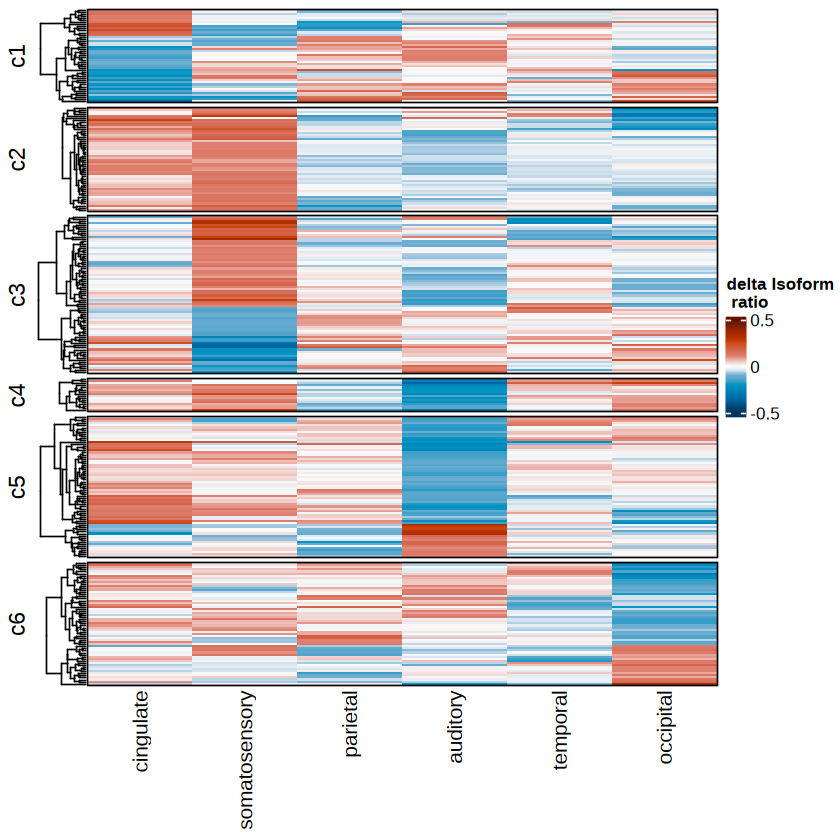

In [97]:
clist = list(c1 = c(11,6,13),
             c2 = c(12,15),
             c3 = c(8,4,10),
             c4 = c(9),
             c5 = c(5,3,7),
             c6 = c(2,14,1))
split <- fit$cluster
for (i in 1:length(clist)) {
    split[which(split %in% clist[[i]])] = names(clist)[i]
}
  
split <- factor(as.character(split), levels=names(clist))
names(split) = names(fit$cluster)
col_fun = colorRamp2(c(-0.5, -0.1, 0, 0.1, 0.5), hcl_palette = "RdBu",reverse = T)
pcloneht2 = Heatmap(isosigf.mx1f,show_row_names = F,row_split = split,
                    cluster_columns = F,cluster_row_slices = F,
                    border = T,
                    name = "delta Isoform\n ratio",col = col_fun)
pcloneht2
ggexport(pcloneht2,filename = "result/figure2/lobe_sig_iso_clone_heatmap_25_10_11.pdf",width = 3.7,height = 6)

In [98]:
#clusteran = read.csv("result/figure2/sigiso_layer_transcript_dr_cluster_tab_08_25.csv")
clusteran = data.frame("cluster" = split,"transcript_id" = rownames(isosigf.mx1f))
isosigf2$cluster = clusteran[match(isosigf2$transcript_id,clusteran$transcript_id),]$cluster
clusteran = unique(isosigf2[,c("gene_id","transcript_id","cluster")])
unique(clusteran[clusteran$cluster == "c2",]$gene_id)
write.csv(clusteran,file = "result/figure2/sigiso_lobe_transcript_dr_cluster_tab_25_10_11.csv",row.names = F, quote = F)

[1] "AAGAB"        NA             "BCLAF1"       "CCNL1"        "COG2"        
 [6] "COLEC11"      "CORO1C"       "DPYSL4"       "DYNC1I1"      "EDEM3"       
[11] "FAM217B"      "FBXO8"        "FXYD5"        "GPATCH8"      "GRIN2B"      
[16] "HP1BP3"       "HTR1E"        "LOC102114773" "LOC107126456" "LOC107126752"
[21] "LRRN2"        "PARP11"       "PEX19"        "PGGT1B"       "PLA2G5"      
[26] "PPP2R2B"      "PSMD12"       "RAB3C"        "RUFY2"        "SETD9"       
[31] "SFXN5"        "SLC38A6"      "SMU1"         "SPATA6"       "SPATS2"      
[36] "STOX2"        "TBCE"         "TNFRSF19"     "TNPO2"        "TRNT1"       
[41] "TSPAN9"       "TTC19"        "TXNDC16"      "TXNL4B"       "UBA3"        
[46] "WAPL"         "XIAP"         "YPEL5"        "ZNF184"       "ZNF346"      
[51] "ZNF717"

In [99]:
#GO analysis
#try GO analysis
library(ggsci)
library(gprofiler2)
MyGOPlot = function(hubgenei,ni,mytitle,mycolor = NULL){
    goi = gost(query = hubgenei,
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(gene_ratio) %>% 
    top_n(wt = gene_ratio,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    if(is.null(mycolor)){
        mycolor = pal_flatui("default")(length(unique(godfi$source)))
    }
    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]
    if(nrow(godfi) > 0){
        pgi = ggplot(godfi,
               aes(x = gene_ratio, y=term_name,fill = source)) + 
        geom_point(aes(size = intersection_size),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank()) +
        ggtitle(mytitle)
    }
    return(pgi)
    
}

MyGOCal = function(hubgenei,ni){
    goi = gost(query = hubgenei,sources = c("GO","KEGG","REAC","WP","TF","HPA","HP"),
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    if(is.null(godfi)) return(NULL)
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    
    godfi = godfi[godfi$intersection_size > 2,]
    
    godfi = godfi %>% group_by(source) %>% arrange(gene_ratio) %>% 
    top_n(wt = gene_ratio,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]

    return(godfi)
    
}


#ggexport(pgi,filename = "result/figure3/sigiso_class_transcript_dr_cluster_heatmap_NN_GO_24_04_21.pdf",width = 4,height = 8)
nrow(clusteran)
clusteran = clusteran[!is.na(clusteran$cluster),]
nrow(clusteran)
clusterid = unique(clusteran$cluster)
mycolor = pal_flatui("default")(5)
names(mycolor) = c("GO:BP","GO:MF","GO:CC","HP","KEGG")

pgls = list()
godft = NULL
for(i in 1:length(clusterid)){
    hubgenei = unique(clusteran[as.character(clusteran$cluster) == clusterid[i],]$gene_id)
    godfi = MyGOCal(hubgenei,5)
    godfi$group = clusterid[i]
    godft = rbind(godft,godfi)
}



[1] 358

[1] 314

ERROR: Error in function (type, msg, asError = TRUE) : Failed to connect to biit.cs.ut.ee port 80 after 255276 ms: Couldn't connect to server


In [100]:
hubgenei = unique(clusteran$gene_id)
#hubgenei
godfi = MyGOCal(hubgenei,5)
#godfi
pgi = ggplot(godfi,
               aes(x = gene_ratio, y=term_name,fill = source)) + 
        geom_point(aes(size = intersection_size),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank())
pgi

ERROR: Error in function (type, msg, asError = TRUE) : Failed to connect to biit.cs.ut.ee port 80 after 254534 ms: Couldn't connect to server


In [ ]:
pgot = ggplot(data = godft[godft$source != "GO:BP",]) + 
     # geom_rect(data = unique(godft[,c("term_name","source")]),
     #                               aes(ymin = as.numeric(term_name)-0.5,ymax = as.numeric(term_name)+0.5,
     #                                                        xmin = -Inf,xmax = Inf,fill = source),
     #            alpha = 0.2) +
    geom_point(aes(x = group,y = term_name,size = intersection_size,fill = source),shape = 21,color = "black") +
    geom_text(aes(y = term_name,label = term_name,x = 0,color = source),hjust = -0.01,vjust = -0.5) +
        #scale_fill_manual(values = mycolor) + 
    #scale_color_manual(values = mycolor) +
#    facet_grid(group~.,scales = "free",space = "free") +
    theme_bw() +
    theme(axis.text.y = element_blank(),
       axis.ticks.y = element_blank(),
      panel.spacing = unit(0,'lines'),
      panel.grid.major = element_blank(),
      #panel.grid.minor = element_blank(),
      panel.border = element_rect(fill = NA)) + xlab("")
pgot

[1] 928

[1] 33


file saved to result/figure2/sigiso_layer_transcript_dr_GO_24_09_10.pdf



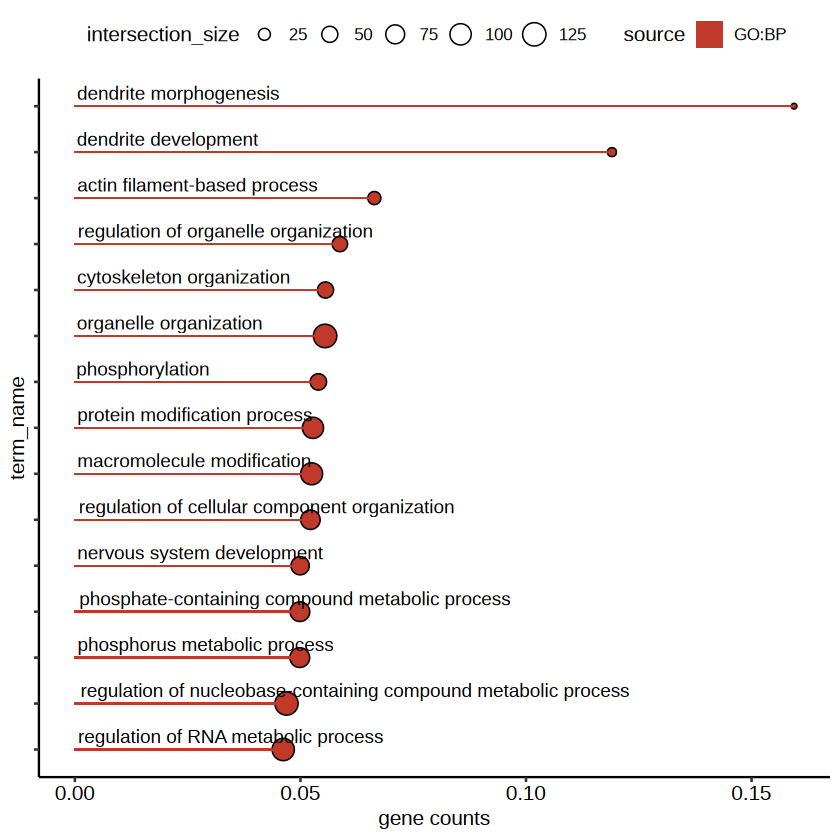

In [395]:
#hubgenei = unique(isosigi.mx[abs(isosigi.mx$dr) > 0.1 & isosigi.mx$pvalue < 0.05,]$gene_id)
#length(hubgenei)
#godft = MyGOCal(hubgenei,5)
#godft
isosigi = isosigls$layer
isosighubi = isosigi[!isosigi$sig %in% "N",]
hubgenest = unique(isosighubi$gene_id)
write.csv(isosighubi,file = "result/figure2/layer_dtu_list_09_09.csv",row.names = F)

length(hubgenest)
godfi = MyGOCal(hubgenest,15)
mycolor = pal_flatui("default")(length(unique(godfi$source)))
pgi = ggplot(godfi[!godfi$source %in% c("GO:CC","GO:MF","HP"),],
               aes(x = gene_ratio, y=term_name,fill = source)) + 
        geom_point(aes(size = intersection_size),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank())
pgi

ggexport(pgi,filename = "result/figure2/sigiso_layer_transcript_dr_GO_24_09_10.pdf",width = 4,height = 5)

[1] 760

[1] 40


file saved to result/figure2/sigiso_lobe_transcript_dr_GO_24_09_10.pdf



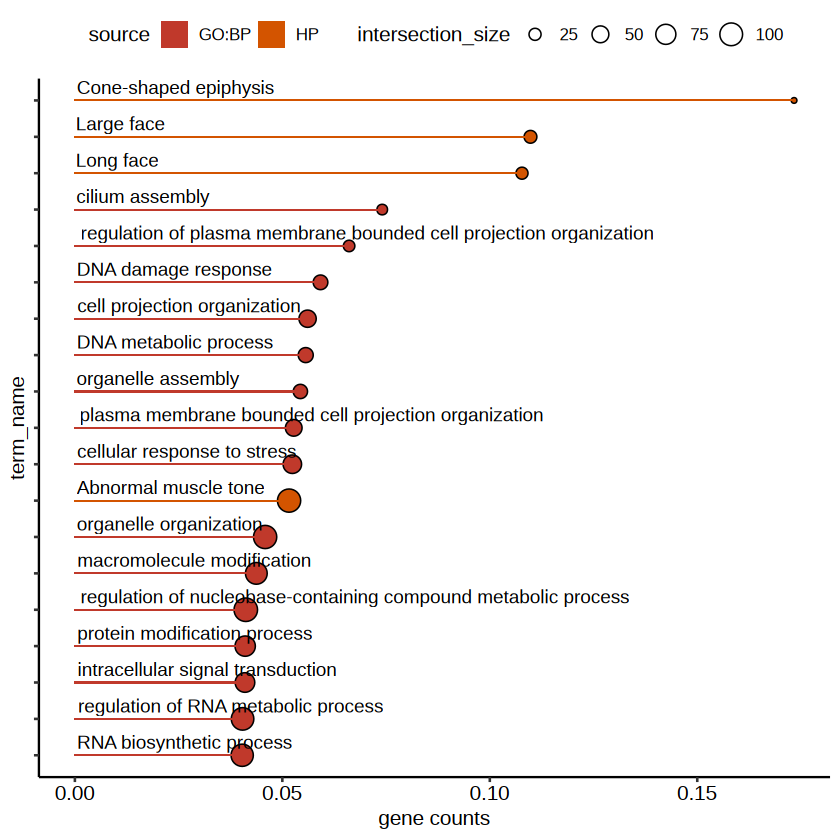

In [397]:
isosigi = isosigls$lobe
isosighubi = isosigi[!isosigi$sig %in% "N",]
hubgenest = unique(isosighubi$gene_id)
write.csv(isosighubi,file = "result/figure2/lobe_dtu_list_09_09.csv",row.names = F)

length(hubgenest)
godfi = MyGOCal(hubgenest,15)
mycolor = pal_flatui("default")(length(unique(godfi$source)))
pgi = ggplot(godfi[!godfi$source %in% c("GO:CC","GO:MF"),],
               aes(x = gene_ratio, y=term_name,fill = source)) + 
        geom_point(aes(size = intersection_size),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank())
pgi

ggexport(pgi,filename = "result/figure2/sigiso_lobe_transcript_dr_GO_24_09_10.pdf",width = 4,height = 5)

[1] 2613
[1] 1463


file saved to result/figure2/region_sig_iso_clone_heatmap_25_10_11.pdf



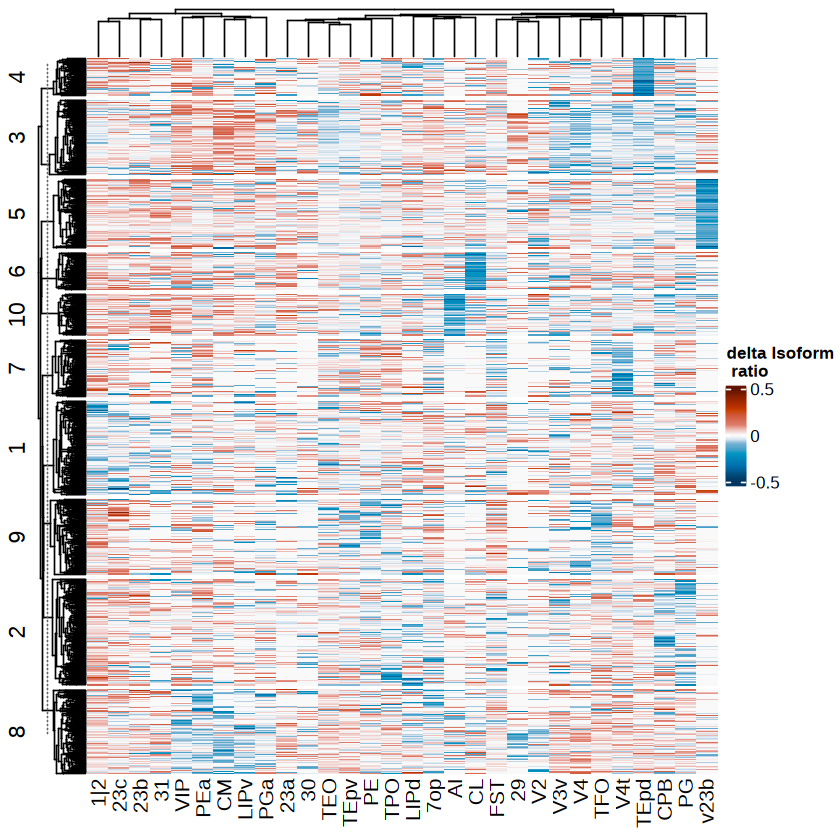

In [101]:
isosigi = isosigls$region
hubtrans = unique(isosigi[isosigi$sig %in% c("Up","Down"),]$transcript_id)
isosigf2 = isosigi[isosigi$transcript_id %in% hubtrans,]
isosigf2$dr2 = isosigf2$relative - isosigf2$meanrelative
print(length(unique(isosigf2$transcript_id)))
isosigf2 = isosigf2 %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
isosigf2$dr2 = isosigf2$relative - isosigf2$meanrelative
print(length(unique(isosigf2$gene_id)))
isosigf.mx1 = dcast(isosigf2,transcript_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigf.mx1) = isosigf.mx1$transcript_id;isosigf.mx1 = isosigf.mx1[-1]
#head(isosigf.mx1)
n = 10
isosigf.mx1f = isosigf.mx1[rowSums(isosigf.mx1 != 0) > 4,]
fit = kmeans(isosigf.mx1f,n)
split <- factor(as.character(fit$cluster), levels=as.character(c(1:n)))
isosigf.mx1f = isosigf.mx1f[,regionorder]
# 计算距离矩阵
# distances <- dist(isosigf.mx1)
# fit <- hclust(distances, method="ward.D2") # 你可以选择其他方法，如 "average", "single", "ward.D2" 等
# clusters <- cutree(fit, k=n)
# split <- factor(as.character(clusters), levels=as.character(c(1:n)))

library(circlize)
col_fun = colorRamp2(c(-0.5, -0.1, 0, 0.1, 0.5), hcl_palette = "RdBu",reverse = T)
isosigf.mx1f = as.matrix(isosigf.mx1f)
pcloneht1 = Heatmap(isosigf.mx1f,show_row_names = F,row_split = split,cluster_columns = T,
                    name = "delta Isoform\n ratio",col = col_fun)
pcloneht1
ggexport(pcloneht1,filename = "result/figure2/region_sig_iso_clone_heatmap_25_10_11.pdf",width = 5,height = 5)

### DTU case Plot

#### Spatial case plot

In [102]:
isosigi = isosigls$layer
isosigi[isosigi$gene_id %in% c("DBNDD2","DDRGK1","ARPP19"),]

gene_id transcript_id  areatr count genecount relative   meanrelative
2349  ARPP19  NM_001283415.1 l1      389   1044     0.37260536 0.40593614  
2350  ARPP19  NM_001283415.1 l2     1947   3921     0.49655700 0.40593614  
2351  ARPP19  NM_001283415.1 l3     8633  18109     0.47672428 0.40593614  
2352  ARPP19  NM_001283415.1 l4      697   1848     0.37716450 0.40593614  
2353  ARPP19  NM_001283415.1 l5     1602   4350     0.36827586 0.40593614  
2354  ARPP19  NM_001283415.1 l6     1435   4168     0.34428983 0.40593614  
2355  ARPP19  XM_015452431.1 l1       68   1044     0.06513410 0.05952962  
2356  ARPP19  XM_015452431.1 l2      139   3921     0.03545014 0.05952962  
2357  ARPP19  XM_015452431.1 l3      709  18109     0.03915180 0.05952962  
2358  ARPP19  XM_015452431.1 l4      134   1848     0.07251082 0.05952962  
2359  ARPP19  XM_015452431.1 l5      309   4350     0.07103448 0.05952962  
2360  ARPP19  XM_015452431.1 l6      308   4168     0.07389635 0.05952962  
2361  ARPP19  XM_015452432.1 l1      585   1044     0.56034483 0.53342368  
2362  ARPP19  XM_015452432.1 l2     1833   3921     0.46748279 0.53342368  
2363  ARPP19  XM_015452432.1 l3     8751  18109     0.48324038 0.53342368  
2364  ARPP19  XM_015452432.1 l4     1013   1848     0.54816017 0.53342368  
2365  ARPP19  XM_015452432.1 l5     2438   4350     0.56045977 0.53342368  
2366  ARPP19  XM_015452432.1 l6     2421   4168     0.58085413 0.53342368  
9976  DBNDD2  DBNDD2-FS-1    l1       29    455     0.06373626 0.06868538  
9977  DBNDD2  DBNDD2-FS-1    l2       79    949     0.08324552 0.06868538  
9978  DBNDD2  DBNDD2-FS-1    l3      424   5812     0.07295251 0.06868538  
9979  DBNDD2  DBNDD2-FS-1    l4       62   1141     0.05433830 0.06868538  
9980  DBNDD2  DBNDD2-FS-1    l5      159   2388     0.06658291 0.06868538  
9981  DBNDD2  DBNDD2-FS-1    l6      237   3326     0.07125676 0.06868538  
9982  DBNDD2  XM_005569136.2 l1      306    455     0.67252747 0.67568807  
9983  DBNDD2  XM_005569136.2 l2      698    949     0.73551106 0.67568807  
9984  DBNDD2  XM_005569136.2 l3     4044   5812     0.69580179 0.67568807  
9985  DBNDD2  XM_005569136.2 l4      799   1141     0.70026293 0.67568807  
9986  DBNDD2  XM_005569136.2 l5     1585   2388     0.66373534 0.67568807  
9987  DBNDD2  XM_005569136.2 l6     1950   3326     0.58628984 0.67568807  
9988  DBNDD2  XM_015429879.1 l1       87    455     0.19120879 0.19691178  
9989  DBNDD2  XM_015429879.1 l2      130    949     0.13698630 0.19691178  
9990  DBNDD2  XM_015429879.1 l3      976   5812     0.16792842 0.19691178  
9991  DBNDD2  XM_015429879.1 l4      216   1141     0.18930762 0.19691178  
9992  DBNDD2  XM_015429879.1 l5      496   2388     0.20770519 0.19691178  
9993  DBNDD2  XM_015429879.1 l6      959   3326     0.28833434 0.19691178  
10319 DDRGK1  DDRGK1-FS-1    l1     1097   1787     0.61387801 0.51439102  
10320 DDRGK1  DDRGK1-FS-1    l2     2723   4160     0.65456731 0.51439102  
10321 DDRGK1  DDRGK1-FS-1    l3     9546  15246     0.62613144 0.51439102  
10322 DDRGK1  DDRGK1-FS-1    l4      723   1893     0.38193344 0.51439102  
10323 DDRGK1  DDRGK1-FS-1    l5     1164   3112     0.37403599 0.51439102  
10324 DDRGK1  DDRGK1-FS-1    l6     1490   3419     0.43579994 0.51439102  
10325 DDRGK1  XM_005568473.2 l1      690   1787     0.38612199 0.48560898  
10326 DDRGK1  XM_005568473.2 l2     1437   4160     0.34543269 0.48560898  
10327 DDRGK1  XM_005568473.2 l3     5700  15246     0.37386856 0.48560898  
10328 DDRGK1  XM_005568473.2 l4     1170   1893     0.61806656 0.48560898  
10329 DDRGK1  XM_005568473.2 l5     1948   3112     0.62596401 0.48560898  
10330 DDRGK1  XM_005568473.2 l6     1929   3419     0.56420006 0.48560898  
      otherrelative dr           sig  pvalue        padj         
2349  0.41260229    -0.039996931 N    9.877953e-108 1.479059e-104
2350  0.38781197     0.108745034 Up   9.877953e-108 1.479059e-104
2351  0.39177851     0.084945769 N    9.877953e-108 1.479059e-104
2352  0.41169047  

In [9]:
pref = qread("../ref/area_figure_an.qs")
edgesdf = pref$areaedges

In [7]:
SpCasePlot = function(fsraw.cor,geneex,hubtrans,backpt,ptsize = 1,backsize = 0.05){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex,]
    mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
    mkdf = mkdf[order(as.numeric(factor(mkdf$transcript_id,levels = hubtrans))),]
    mycolor = distinctColorPalette(length(hubtrans))
    #mkdf = mkdf[order(mkdf$transcript_id),]
    pmkpti1 = ggplot() +
      scattermore::geom_scattermore(
        data = backpt,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = backsize
      ) +
      geom_point(data = mkdf,
                 aes(x,y,fill = transcript_id,stroke.size = NA),shape = 21,size = ptsize,stroke = NA) + 
      # geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2,color = areatr),
      #            size = 0.5,alpha = 0.75) + 
     # scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~layer,nrow = 2) 
      theme_void() +
      scale_fill_discreterainbow() +
      #scale_fill_manual(values = mycolor) +
      #scale_color_flatui() +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 18)) +
      guides(color = guide_legend(override.aes = list(size=8),nrow = 3),
            fill = guide_legend(override.aes = list(size=8),nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse()
    return(pmkpti1)
}

file saved to result/figure2/DBNDD2_layer_case_bin1_24_10_23.pdf



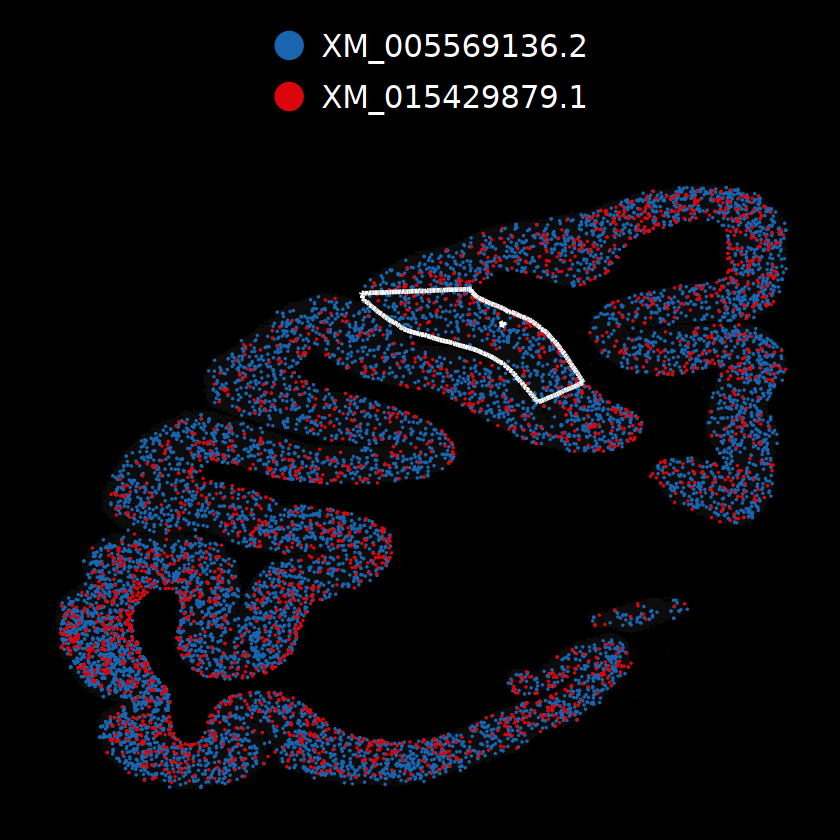

file saved to result/figure2/DBNDD2_layer_case_bin1_zoom_24_10_23.pdf



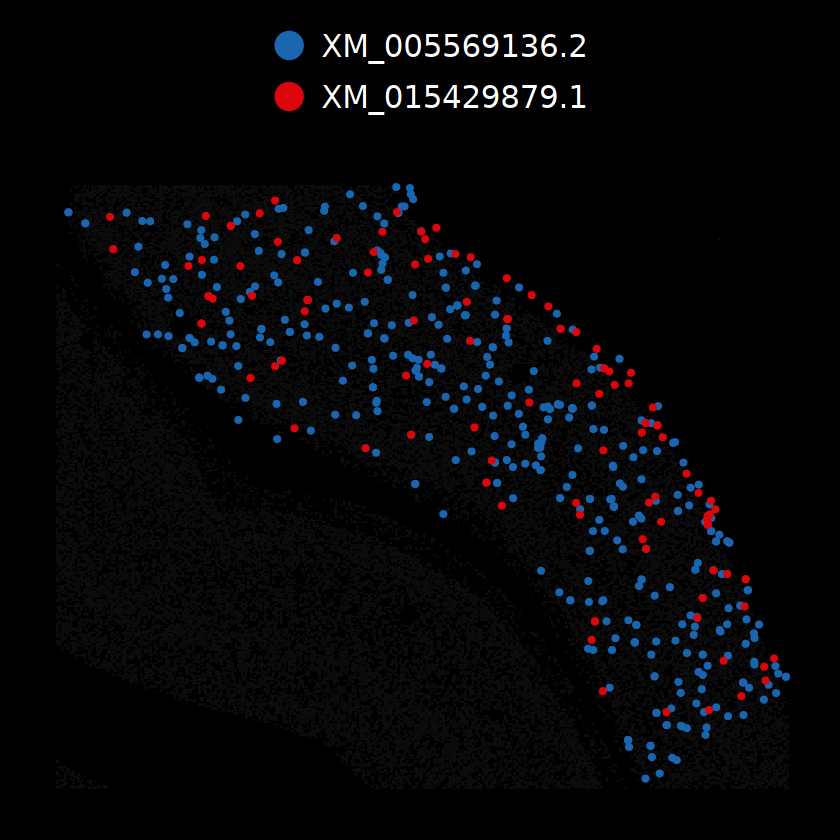

In [96]:
geneex = "DBNDD2"
transid = c("XM_005569136.2","XM_015429879.1")
edgesdf.zoom = edgesdf[edgesdf$areaid %in% "PEa",]
pc1 = SpCasePlot(fsraw.cor,geneex,transid,backpt,0.7)
pc1 = pc1 + geom_segment(data = edgesdf.zoom, 
                   aes(x = x1, y = y1, xend = x2, yend = y2),
                   size = 1,alpha = 1,
                   color = "white")
pc1
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_24_10_23.pdf")
ggexport(pc1,filename = fileid,width = 4,height = 6)

fsraw.cor.zoom = fsraw.cor[fsraw.cor$region == "PEa",]
backpt.zoom = backpt[backpt$x < max(fsraw.cor.zoom$x) & backpt$x > min(fsraw.cor.zoom$x) &
                     backpt$y < max(fsraw.cor.zoom$y) & backpt$y > min(fsraw.cor.zoom$y),]
pc1.zoom = SpCasePlot(fsraw.cor.zoom,geneex,transid,backpt.zoom,2)
pc1.zoom
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_zoom_24_10_23.pdf")
ggexport(pc1.zoom,filename = fileid,width = 4,height = 6)

# isosigi = isosigls$layer
# fsraw.cor$areatr = fsraw.cor$layer
# fsraw.cor$chunk = fsraw.cor$lobe

# pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid)
# pcr
# pcc = CaseCountPlotBox(fsraw.cor,geneex,transid,NULL)
# pcc
# fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_24_08_24.pdf")
# ggexport(pcr,filename = fileid,width = 4,height = 6)
# fileid = paste0("result/figure2/",geneex,"_layer_case_boxstat_24_08_24.pdf")
# ggexport(pcc,filename = fileid,width = 4,height = 4)

file saved to result/figure2/DDRGK1_layer_case_bin1_24_11_29.pdf



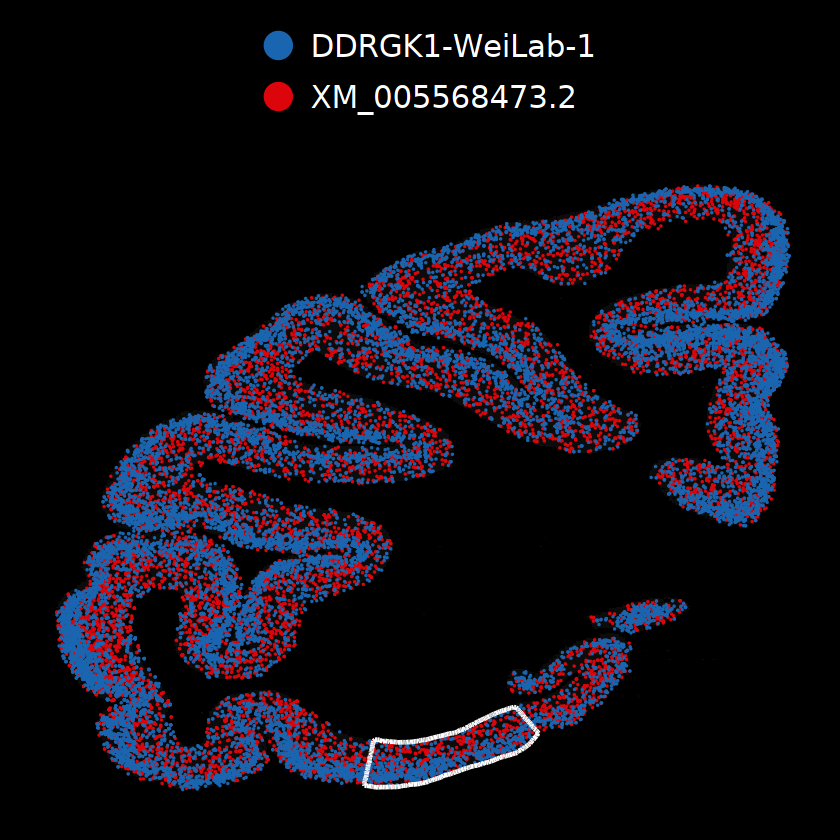

file saved to result/figure2/DDRGK1_layer_case_bin1_zoom_24_11_29.pdf



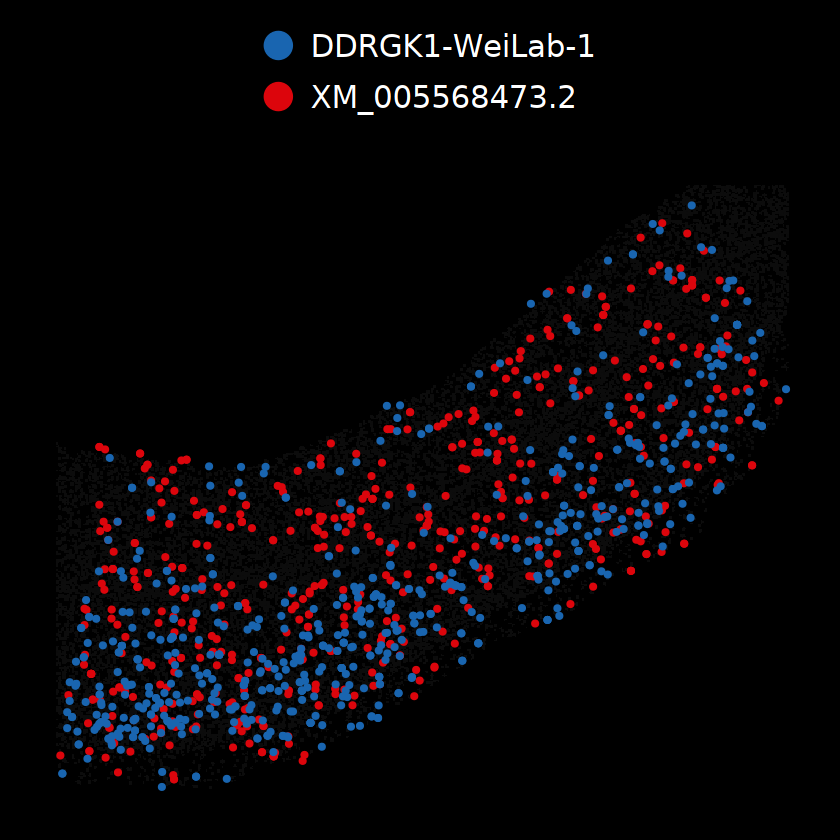

In [97]:
geneex = "DDRGK1"
transid = c("XM_005568473.2","DDRGK1-WeiLab-1")
edgesdf.zoom = edgesdf[edgesdf$areaid %in% "TFO",]
pc1 = SpCasePlot(fsraw.cor,geneex,transid,backpt,0.7)
pc1 = pc1 + geom_segment(data = edgesdf.zoom, 
                   aes(x = x1, y = y1, xend = x2, yend = y2),
                   size = 1,alpha = 1,
                   color = "white")
pc1
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_24_11_29.pdf")
ggexport(pc1,filename = fileid,width = 4,height = 6)

fsraw.cor.zoom = fsraw.cor[fsraw.cor$region == "TFO",]
backpt.zoom = backpt[backpt$x < max(fsraw.cor.zoom$x) & backpt$x > min(fsraw.cor.zoom$x) &
                     backpt$y < max(fsraw.cor.zoom$y) & backpt$y > min(fsraw.cor.zoom$y),]
pc1.zoom = SpCasePlot(fsraw.cor.zoom,geneex,transid,backpt.zoom,2)
pc1.zoom
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_zoom_24_11_29.pdf")
ggexport(pc1.zoom,filename = fileid,width = 4,height = 6)


file saved to result/figure2/ARPP19_layer_case_bin1_24_11_29.pdf



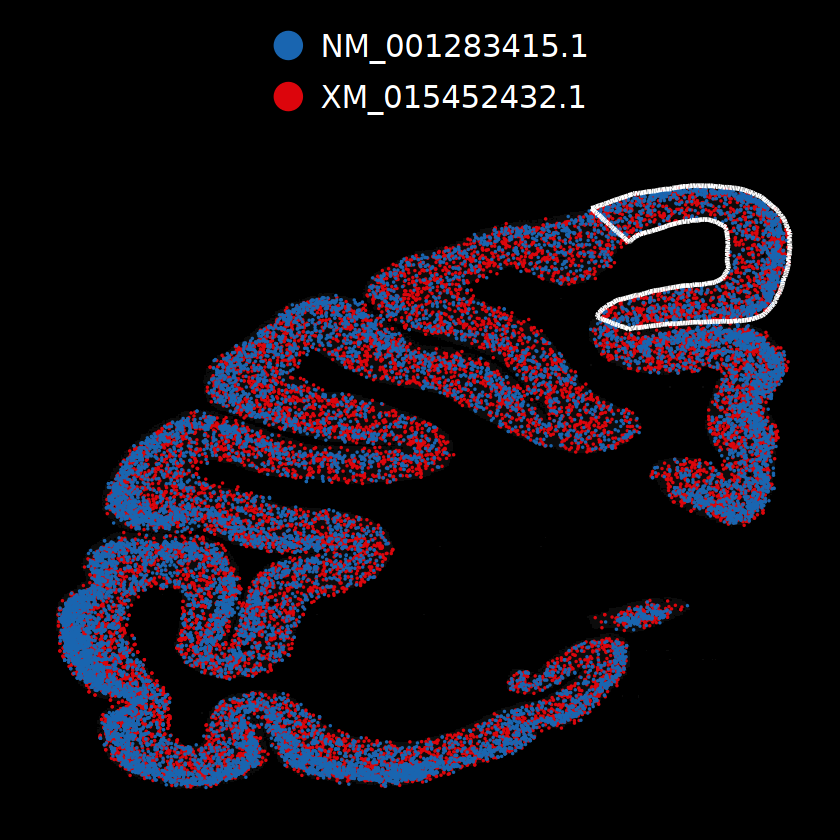

file saved to result/figure2/ARPP19_layer_case_bin1_zoom_24_11_29.pdf



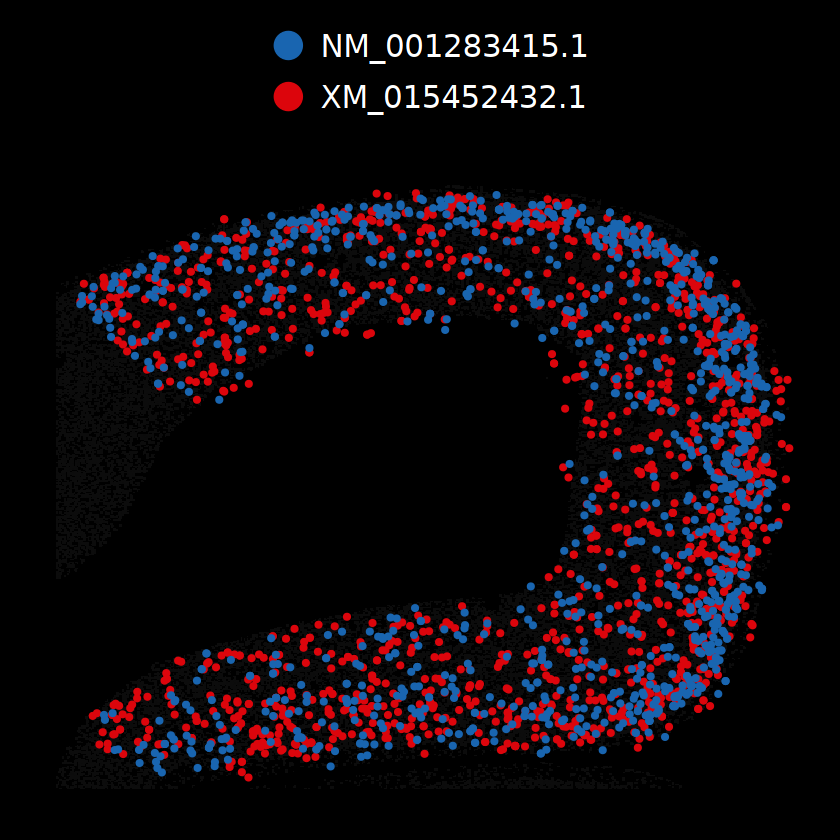

In [99]:
geneex = "ARPP19"
transid = c("XM_015452432.1","NM_001283415.1")
edgesdf.zoom = edgesdf[edgesdf$areaid %in% "1/2",]
pc1 = SpCasePlot(fsraw.cor,geneex,transid,backpt,0.7)
pc1 = pc1 + geom_segment(data = edgesdf.zoom, 
                   aes(x = x1, y = y1, xend = x2, yend = y2),
                   size = 1,alpha = 1,
                   color = "white")
pc1
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_24_11_29.pdf")
ggexport(pc1,filename = fileid,width = 4,height = 6)

fsraw.cor.zoom = fsraw.cor[fsraw.cor$region == "1|2",]
backpt.zoom = backpt[backpt$x < max(fsraw.cor.zoom$x) & backpt$x > min(fsraw.cor.zoom$x) &
                     backpt$y < max(fsraw.cor.zoom$y) & backpt$y > min(fsraw.cor.zoom$y),]
pc1.zoom = SpCasePlot(fsraw.cor.zoom,geneex,transid,backpt.zoom,2)
pc1.zoom
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_zoom_24_11_29.pdf")
ggexport(pc1.zoom,filename = fileid,width = 4,height = 6)


Warning message in geom_point(data = mkdf, aes(x, y, fill = transcript_id, stroke.size = NA), :
"Ignoring unknown aesthetics: stroke.size"
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to result/figure2/ARPP21_layer_case_bin1_26_01_05.pdf



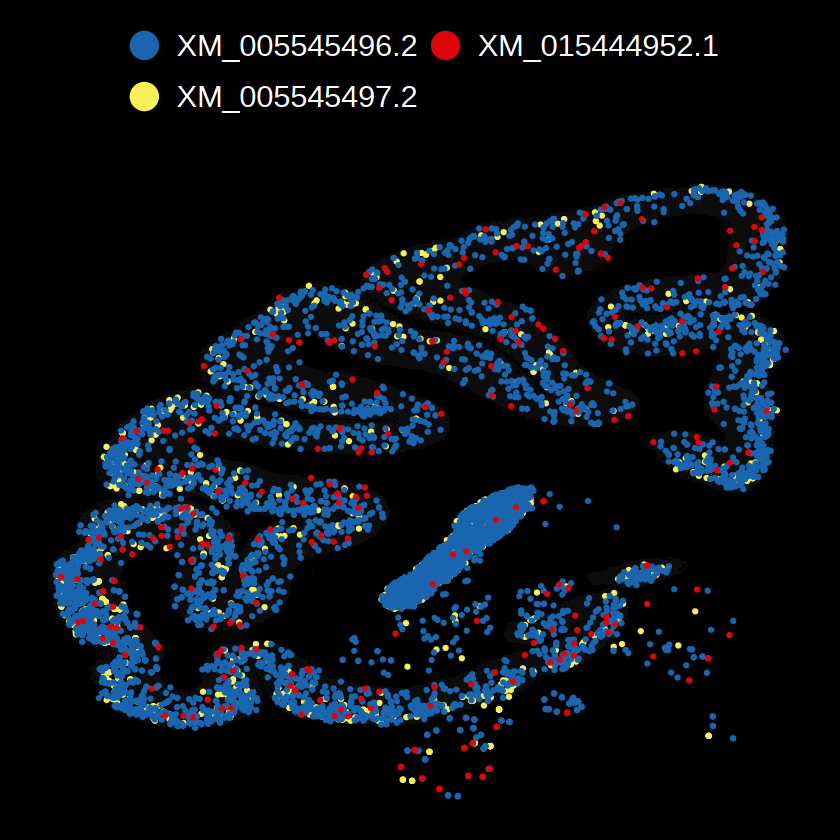

In [13]:
geneex = "ARPP21"
transid = c('XM_005545497.2','XM_005545496.2','XM_015444952.1')
# pc1 = SpCasePlot(fsraw.cor[fsraw.cor$subcortical == "Cortex",],geneex,transid,backpt,0.5)
pc1 = SpCasePlot(fsraw.cor,geneex,transid,backpt,1.5)
pc1
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_26_01_05.pdf")
ggexport(pc1,filename = fileid,width = 6,height = 9)

#fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_zoom_24_10_23.pdf")
#ggexport(pc1.zoom,filename = fileid,width = 6,height = 9)


#### fullscope case splced reads plot

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 462 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 329 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 20 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 76 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 11 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 15 rows containing missing values or values outside the scale range
(

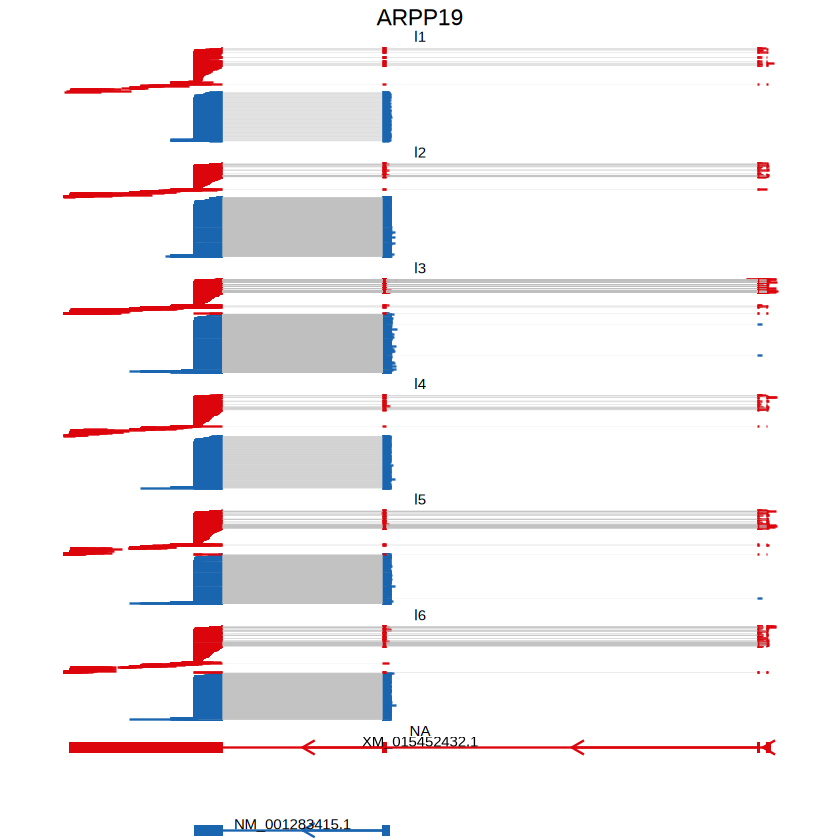

In [264]:
geneex = "ARPP19"
transid = c("XM_015452432.1","NM_001283415.1")
isosigi = isosigls$layer
mycolor = c('#DC050C','#1965B0')
names(mycolor) = transid
fsraw.cor$areatr = fsraw.cor$layer
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE,mycolor)
pcr
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_fullscope_24_10_23.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

# isosigi = isosigls$layer
# fsraw.cor$areatr = fsraw.cor$layer
# fsraw.cor$chunk = fsraw.cor$lobe
# pcc = CaseCountPlotBox(fsraw.cor,geneex,transid,NULL)
# pcc
# fileid = paste0("result/figure2/",geneex,"_layer_case_boxstat_24_08_24.pdf")
# ggexport(pcc,filename = fileid,width = 4,height = 4)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 266 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 218 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 8 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 18 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 9 rows containing missing values or values outside the scale range
(`geo

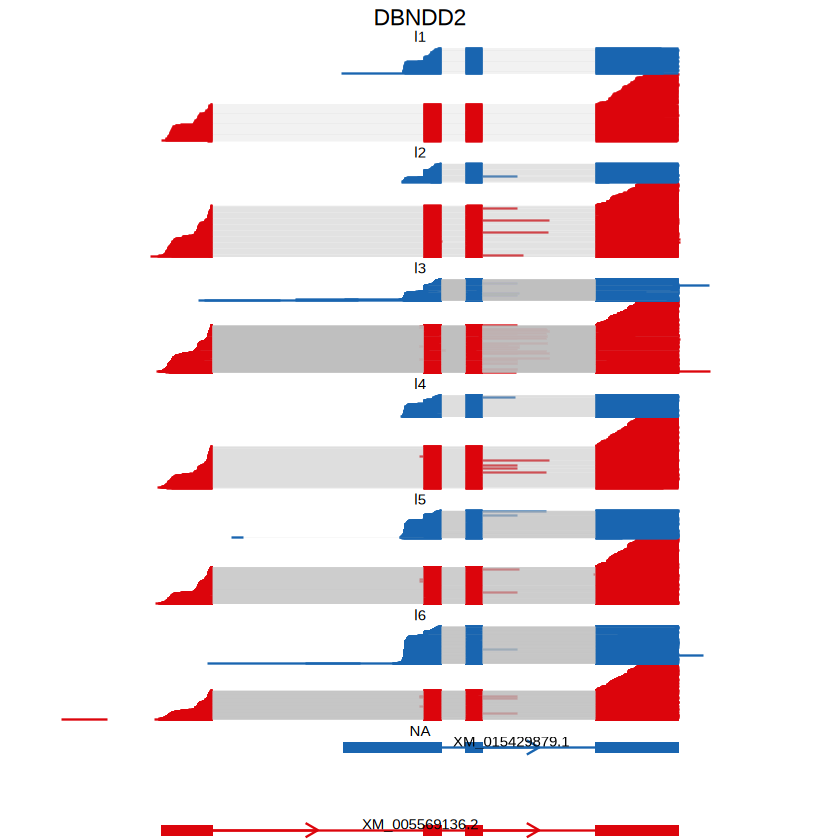

In [266]:
geneex = "DBNDD2"
transid = c("XM_005569136.2","XM_015429879.1")
isosigi = isosigls$layer
mycolor = c('#DC050C','#1965B0')
names(mycolor) = transid
fsraw.cor$areatr = fsraw.cor$layer
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE,mycolor)
pcr
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_fullscope_24_10_23.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 38 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 36 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 38 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 36 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
file saved to result/figure2/TPM3_layer_case_readsplice_fullscope_24_12_05.pdf



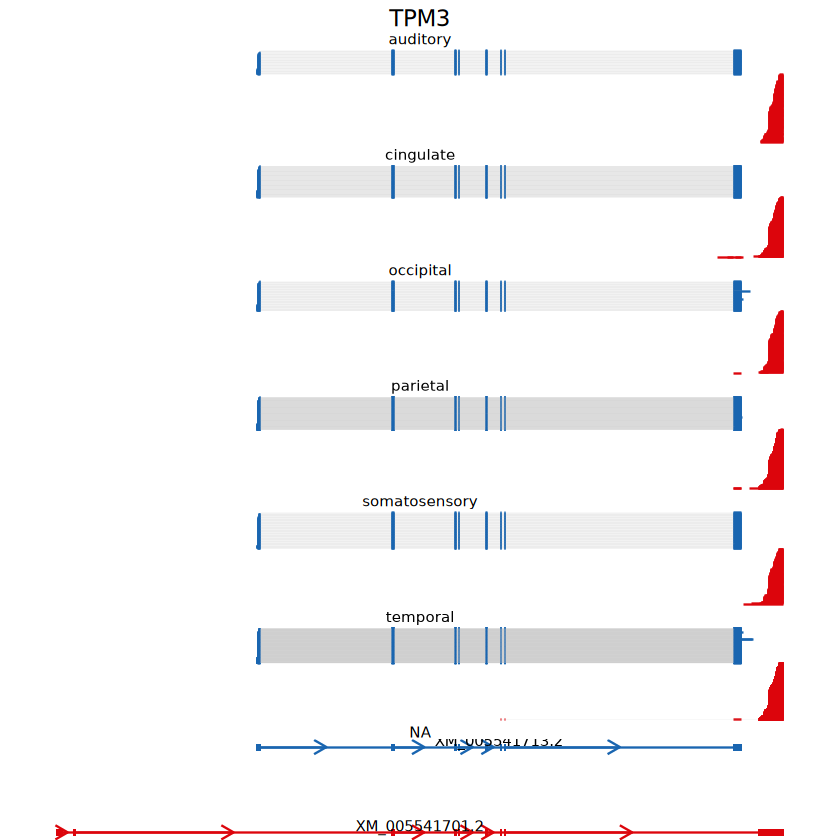

In [129]:
geneex = "TPM3"
transid = c("XM_005541701.2","XM_005541713.2")
isosigi = isosigls$lobe
mycolor = c('#DC050C','#1965B0')
names(mycolor) = transid
fsraw.cor$areatr = fsraw.cor$lobe
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE,mycolor)
pcr
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_fullscope_24_12_05.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 40 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 38 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 40 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 38 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_se

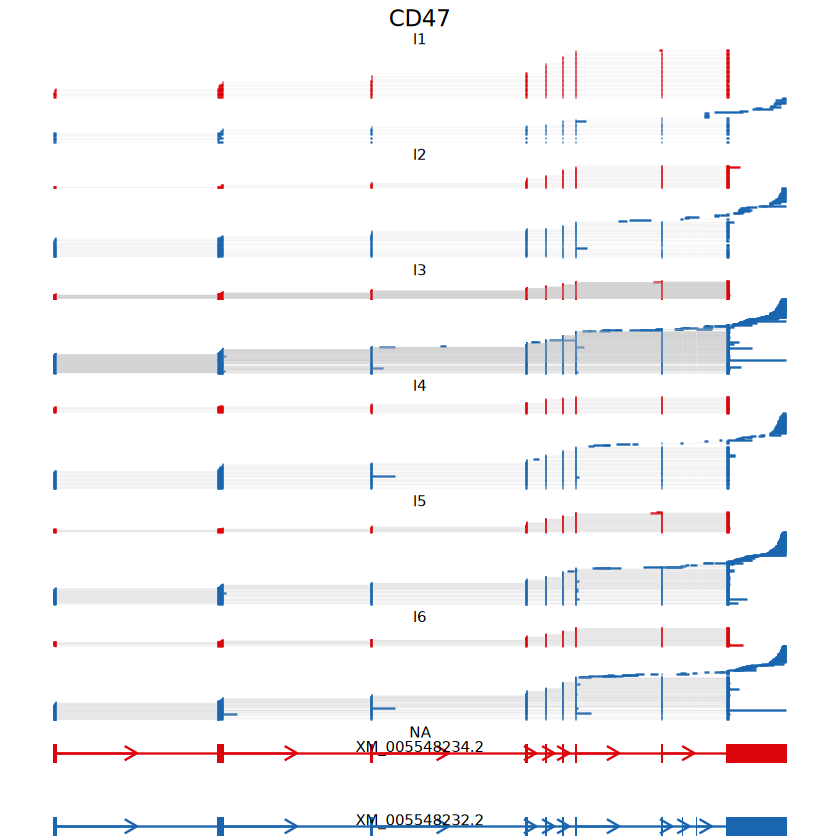

In [133]:
geneex = "CD47"
transid = c('XM_005548234.2','XM_005548232.2')
isosigi = isosigls$layer
mycolor = c('#DC050C','#1965B0')
names(mycolor) = transid
fsraw.cor$areatr = fsraw.cor$layer
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE,mycolor)
pcr
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_fullscope_24_12_05.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 39 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 24 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 39 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 24 rows containing missing values or values outside the scale range
(`geom

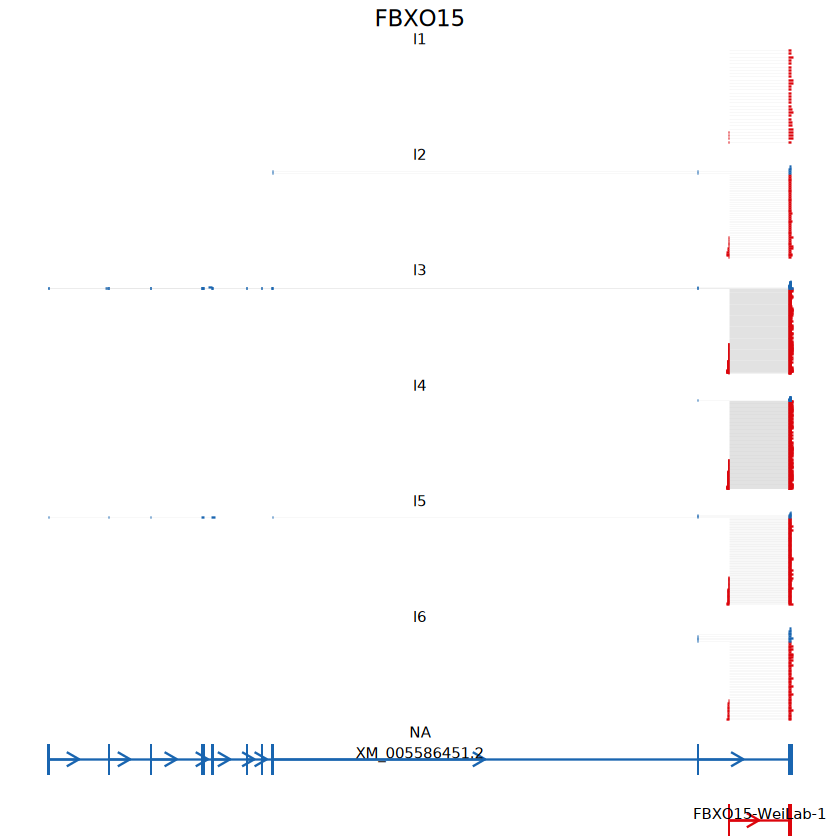

In [134]:
geneex = "FBXO15"
transid = c('FBXO15-WeiLab-1','XM_005586451.2')
isosigi = isosigls$layer
mycolor = c('#DC050C','#1965B0')
names(mycolor) = transid
fsraw.cor$areatr = fsraw.cor$layer
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE,mycolor)
pcr
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_fullscope_24_12_05.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 5 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 5 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
file saved to result/figure2/SMYD2_layer_case_readsplice_fullscope_24_12_05.pdf



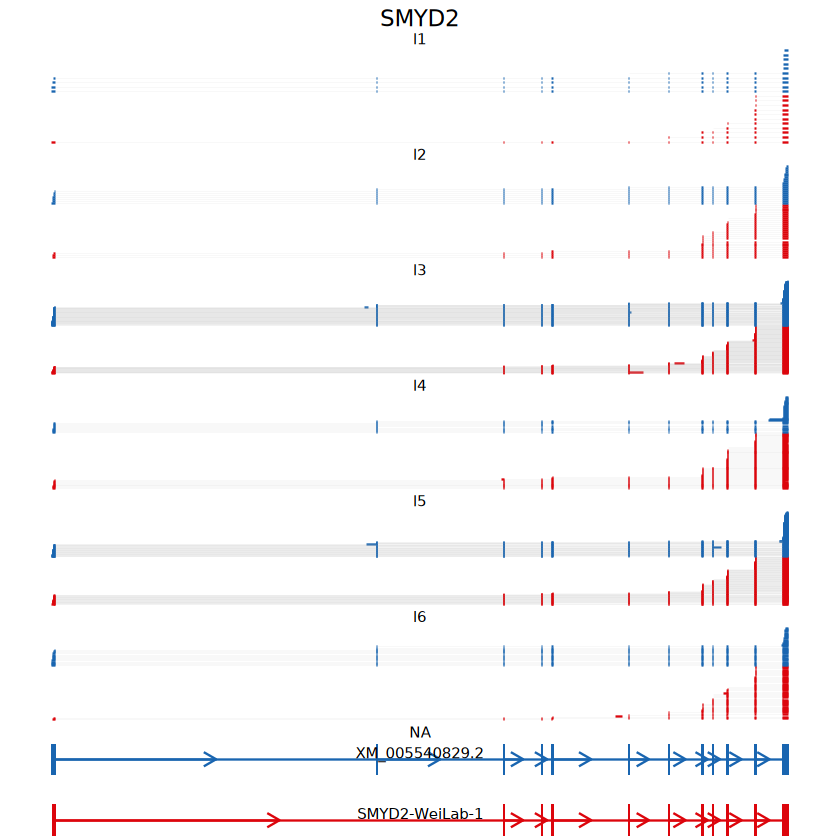

In [135]:
geneex = "SMYD2"
transid = c('SMYD2-WeiLab-1','XM_005540829.2')
isosigi = isosigls$layer
mycolor = c('#DC050C','#1965B0')
names(mycolor) = transid
fsraw.cor$areatr = fsraw.cor$layer
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE,mycolor)
pcr
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_fullscope_24_12_05.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 76 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 28 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 14 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 7 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 12 rows containing missing values or values outside the scale range
(`geo

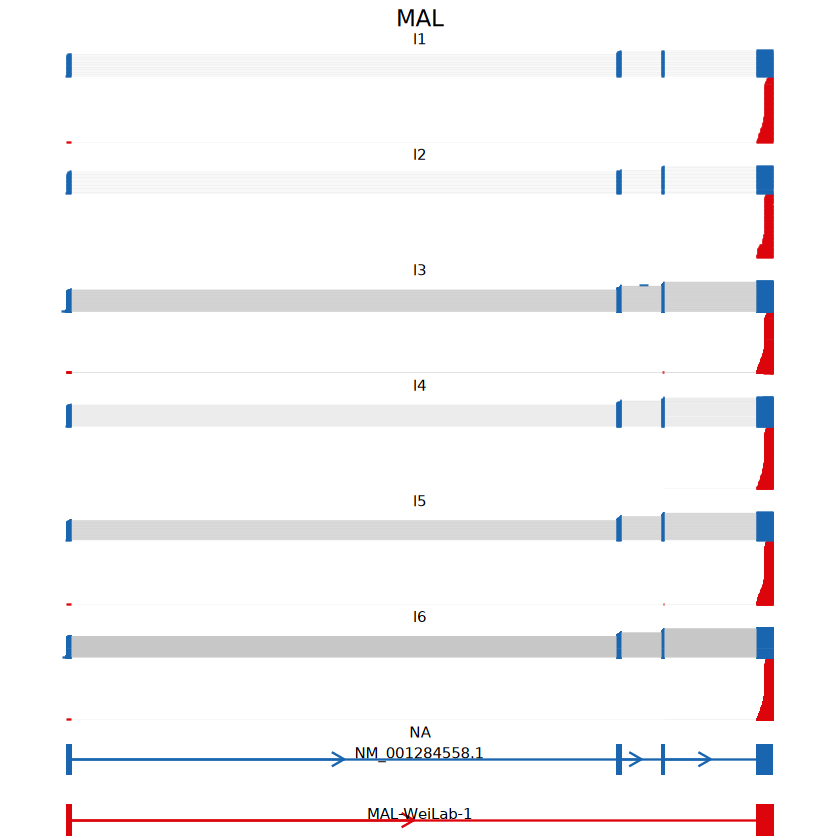

In [136]:
geneex = "MAL"
transid = c('MAL-WeiLab-1','NM_001284558.1')
isosigi = isosigls$layer
mycolor = c('#DC050C','#1965B0')
names(mycolor) = transid
fsraw.cor$areatr = fsraw.cor$layer
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE,mycolor)
pcr
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_fullscope_24_12_05.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

In [266]:
geneex = "NTRK2"
transid = c("XM_005582045.2","XM_005582051.2")
fsraw.cor.zoom = fsraw.cor[fsraw.cor$region == "1|2",]
backpt.zoom = backpt[backpt$x < max(fsraw.cor.zoom$x) & backpt$x > min(fsraw.cor.zoom$x) &
                     backpt$y < max(fsraw.cor.zoom$y) & backpt$y > min(fsraw.cor.zoom$y),]
pc1 = MarkerSpPlotBin1(fsraw.cor.zoom,backpt.zoom,geneex,NULL,transid,0.3)
pc1
fileid = paste0("result/figure2/",geneex,"_layer_case_bin1_zoom_24_09_06.pdf")
# ggexport(pc1,filename = fileid,width = 6,height = 9)
#pc2 = MarkerSpPlotBin1(fsraw.cor,backpt,geneex,NULL,transid,0.3)
#pc2
ggexport(pc1,filename = fileid,width = 6,height = 9)
isosigi = isosigls$layer
fsraw.cor$areatr = fsraw.cor$layer
fsraw.cor$chunk = fsraw.cor$lobe
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,transid,TRUE)
pcr
pcc = CaseCountPlotBox(fsraw.cor,geneex,transid,NULL)
pcc
fileid = paste0("result/figure2/",geneex,"_layer_case_readsplice_24_09_10.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)
fileid = paste0("result/figure2/",geneex,"_layer_case_boxstat_24_09_10.pdf")
ggexport(pcc,filename = fileid,width = 4,height = 4)

`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmpo61LC0/pdf13df7d0503a3' for compression (reason: No space left on device); compression has been turned off for this device"
file saved to result/figure2/NTRK2_layer_case_bin1_zoom_24_09_06.pdf

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 118 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 89 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the s

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

`summarise()` has grouped output by 'areatr', 'chunk'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `dplyr::mutate()`:
! Can't transform a data frame with duplicate names."


ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmpo61LC0/pdf13df7203a927a' for compression (reason: No space left on device); compression has been turned off for this device"
Warning message:
"Removed 118 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 89 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."
fi

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

#### DDRGK1 NGS case compare

In [241]:
longbedngs = import("data/reads_full_anotation/ngs_bed_file/DDRGK1_ngs.bed", format = "BED")
head(longbedngs)
#qsave(longbed,"ref/long_read_mapping_total_rawnano_pac2_24_03_29.qs")

GRanges object with 6 ranges and 2 metadata columns:
         seqnames            ranges strand |                   name     score
            <Rle>         <IRanges>  <Rle> |            <character> <numeric>
  [1] NC_022281.1 58561264-59376369      + | FP200002078L1C035R02..         0
  [2] NC_022281.1 58602518-59604441      + | FP200002078L1C061R03..       255
  [3] NC_022281.1 58603983-59454413      - | FP200002078L1C027R03..         0
  [4] NC_022281.1 58603983-59454413      - | FP200002078L1C010R03..         0
  [5] NC_022281.1 58604835-59323690      - | FP200002078L1C082R00..       255
  [6] NC_022281.1 58604835-59323690      - | FP200002078L1C008R00..       255
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

In [281]:
refdf = qread("/cluster/home/liuhengxin/P1_brain_nanopore/ref/T44_dedup_with_cellan_23_03_23.qs")
head(refdf)

x     y     cell_label gene_area rx    ry    CBZ              origin_name
1 10204 26115 0          0         56131 12632 CB:Z:10204_26115 background 
2 10205 26115 0          0         56130 12632 CB:Z:10205_26115 background 
3 10206 26116 0          0         56129 12633 CB:Z:10206_26116 background 
4 10199 26117 0          0         56136 12634 CB:Z:10199_26117 background 
5 10201 26117 0          0         56134 12634 CB:Z:10201_26117 background 
6 10203 26117 0          0         56132 12634 CB:Z:10203_26117 background 
  global_region_id no cell_id cell_type_id cell_type subclass class
1 0                NA NA      NA                                   
2 0                NA NA      NA                                   
3 0                NA NA      NA                                   
4 0                NA NA      NA                                   
5 0                NA NA      NA                                   
6 0                NA NA      NA                                   
  cell_type_color
1                
2                
3                
4                
5                
6

In [284]:
longbedngs$CBZ = MySplit(longbedngs$name,"\\|\\|\\|",3)
longbedngs$origin_name = refdf[match(longbedngs$CBZ,refdf$CBZ),]$origin_name
length(longbedngs)

[1] 1102474

In [287]:
longbedngs = longbedngs[!is.na(longbedngs$origin_name)]
length(longbedngs)
longbedngs = longbedngs[longbedngs$origin_name != "background"]
length(longbedngs)
longbedngs$layer = MySplit(longbedngs$origin_name,"-",3)
longbedngs = longbedngs[longbedngs$layer %in% paste0("l",1:6)]
head(longbedngs)
length(longbedngs)
qsave(longbedngs,"data/reads_full_anotation/ngs_bed_file/DDRGK1_ngs_withan_fil.qs")

[1] 836709

[1] 675009

GRanges object with 6 ranges and 5 metadata columns:
         seqnames            ranges strand |                   name     score
            <Rle>         <IRanges>  <Rle> |            <character> <numeric>
  [1] NC_022281.1 58603983-59454413      - | FP200002078L1C010R03..         0
  [2] NC_022281.1 58604835-59323690      - | FP200002078L1C082R00..       255
  [3] NC_022281.1 58604835-59323690      - | FP200002078L1C008R00..       255
  [4] NC_022281.1 58679679-59435274      - | FP200002078L1C004R03..         3
  [5] NC_022281.1 58717539-59378520      - | FP200002078L1C044R05..         3
  [6] NC_022281.1 58744220-59343395      - | FP200002078L1C026R02..       255
                   CBZ origin_name       layer
           <character> <character> <character>
  [1]  CB:Z:8063_52027    L-23b-l5          l5
  [2] CB:Z:41617_90243   L-TEpv-l2          l2
  [3] CB:Z:41617_90243   L-TEpv-l2          l2
  [4] CB:Z:53388_76552    L-TEO-l2          l2
  [5] CB:Z:48325_58836    L-CPB-l4       

[1] 585667

In [242]:
longbedngs = qread("data/reads_full_anotation/ngs_bed_file/DDRGK1_ngs_withan_fil.qs")

In [293]:
gtfhub = gtf[gtf$gene_id == "DDRGK1",]
gtfhub = gtfhub[gtfhub$type == "exon",]
overlaps = findOverlaps(query = longbedngs, subject = gtfhub)
readgroup = data.frame(
  readid = longbedngs[queryHits(overlaps)]$name,
  transcript_id = gtfhub[subjectHits(overlaps)]$transcript_id
)
readgroup$gene_id = "DDRGK1"


readid                                                                                                            
1 FP200002078L1C022R00603795428|||CB:S:TAGGGATCGTTTGCTTTCTTATCCT|||CB:Z:43619_89188|||UR:Z:TAGCATTATT|||UY:Z:CCGIAGF
2 FP200002078L1C022R00603795428|||CB:S:TAGGGATCGTTTGCTTTCTTATCCT|||CB:Z:43619_89188|||UR:Z:TAGCATTATT|||UY:Z:CCGIAGF
3 FP200002078L1C022R00603795428|||CB:S:TAGGGATCGTTTGCTTTCTTATCCT|||CB:Z:43619_89188|||UR:Z:TAGCATTATT|||UY:Z:CCGIAGF
4 FP200002078L1C022R00603795428|||CB:S:TAGGGATCGTTTGCTTTCTTATCCT|||CB:Z:43619_89188|||UR:Z:TAGCATTATT|||UY:Z:CCGIAGF
5 FP200002078L1C022R00603795428|||CB:S:TAGGGATCGTTTGCTTTCTTATCCT|||CB:Z:43619_89188|||UR:Z:TAGCATTATT|||UY:Z:CCGIAGF
6 FP200002078L1C022R00603795428|||CB:S:TAGGGATCGTTTGCTTTCTTATCCT|||CB:Z:43619_89188|||UR:Z:TAGCATTATT|||UY:Z:CCGIAGF
  transcript_id   gene_id
1 XM_005568473.2  DDRGK1 
2 XM_005568473.2  DDRGK1 
3 XM_005568473.2  DDRGK1 
4 XM_005568473.2  DDRGK1 
5 DDRGK1-WeiLab-1 DDRGK1 
6 DDRGK1-WeiLab-1 DDRGK1

[1] 1441623

In [299]:
readgroup = readgroup %>% group_by(readid) %>% mutate(transnum = length(unique(transcript_id)))
readgroup_rm = readgroup
readgroup_rm[readgroup_rm$transnum > 1,]$transcript_id = "ambitious"
readgroup_rm = unique(readgroup_rm)
nrow(readgroup_rm)

[1] 574774

In [300]:
readgroup_rm$CBZ = MySplit(readgroup_rm$readid,"\\|\\|\\|",3)
readgroup_rm$origin_name = refdf[match(readgroup_rm$CBZ,refdf$CBZ),]$origin_name
readgroup_rm = readgroup_rm[!is.na(readgroup_rm$origin_name),]
readgroup_rm = readgroup_rm[readgroup_rm$origin_name != "background",]
readgroup_rm$layer = MySplit(readgroup_rm$origin_name,"-",3)
readgroup_rm = readgroup_rm[readgroup_rm$layer %in% paste0("l",1:6),]
readgroup_rm$areatr = readgroup_rm$layer
qsave(readgroup_rm,"data/reads_full_anotation/ngs_bed_file/DDRGK1_ngs_readgroup.qs")

In [245]:
readgroup_rm = qread("data/reads_full_anotation/ngs_bed_file/DDRGK1_ngs_readgroup.qs")
readgroup_rm$transcript_id = "unknown"

In [257]:
IsoformReadPlotTotal

function(fsraw,isosigi,longbed,gtf,geneex,hubtrans = NULL,onlyhub = F){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    mycolors = distinctColorPalette(length(transname))
    names(mycolors) = transname
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub,mycolors)
    pci1
    return(pci1)
}
<bytecode: 0x55bd12e4eb38>

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 816 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 112 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 254 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 965 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 128 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 191 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 268 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 357 rows containing missing values or values outside the scale

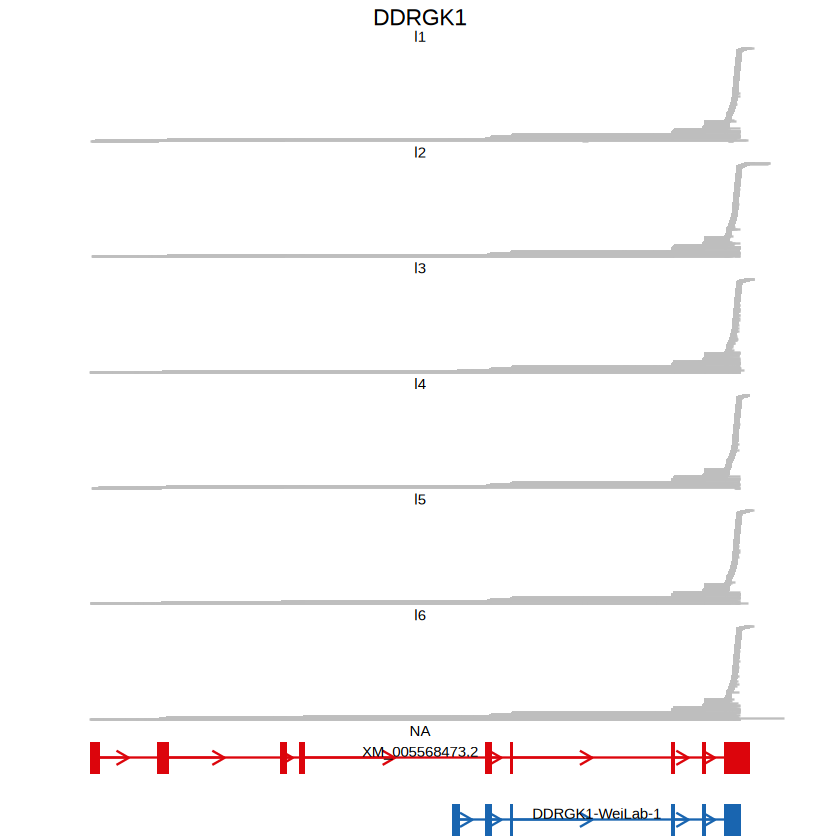

In [259]:
isosig_ngs = data.frame("gene_id" = rep("DDRGK1",3),"transcript_id" = c("DDRGK1-WeiLab-1","XM_005568473.2","unknown"))
mycolor = c('#DC050C','#1965B0','grey')
names(mycolor) = c("XM_005568473.2","DDRGK1-WeiLab-1","unknown")
pcngs = IsoformReadPlotTotal(readgroup_rm,isosig_ngs,longbedngs,gtf,"DDRGK1",NULL,FALSE,mycolor)
pcngs

In [260]:
fileid = paste0("result/figure2/","DDRGK1","_layer_case_readsplice_ngs_24_10_23.pdf")
ggexport(pcngs,filename = fileid,width = 4,height = 6)

Warning message:
"Removed 816 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 112 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 254 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 965 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 128 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 191 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 268 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 357 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values out

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 387 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 289 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 13 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 53 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 12 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 10 rows containing missing values or values outside the scale range
(

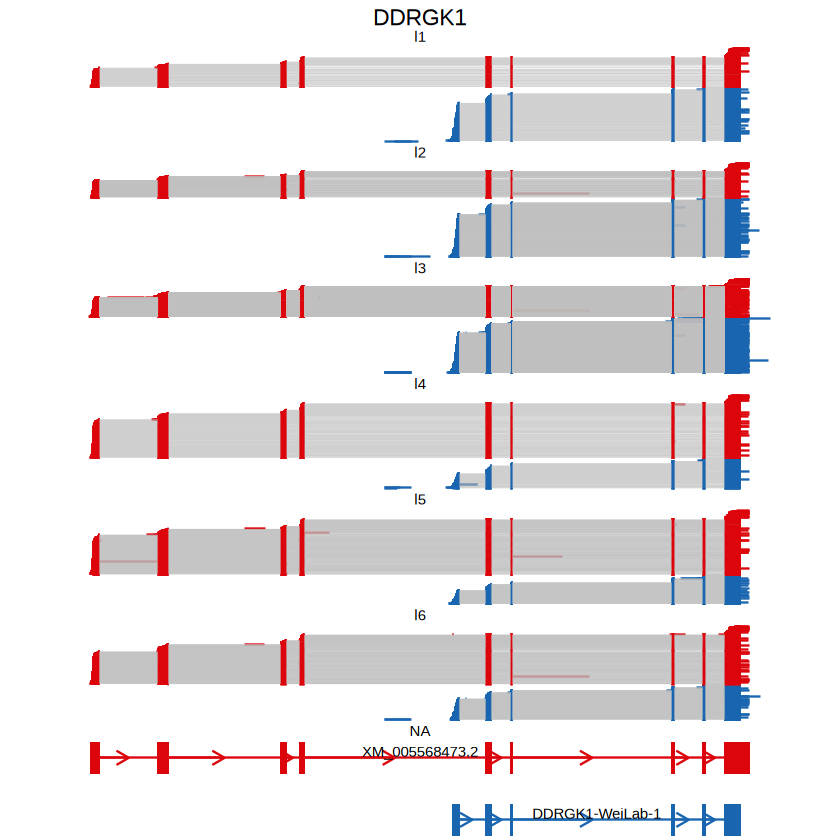

In [265]:
isosigi = isosigls$layer
mycolor = c('#DC050C','#1965B0')
names(mycolor) = c("XM_005568473.2","DDRGK1-WeiLab-1")
fsraw.cor$areatr = fsraw.cor$layer
pcr = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,"DDRGK1",c("XM_005568473.2","DDRGK1-WeiLab-1"),FALSE,mycolor)
pcr
fileid = paste0("result/figure2/","DDRGK1","_layer_case_readsplice_fullscope_24_10_23.pdf")
ggexport(pcr,filename = fileid,width = 4,height = 6)

#### DTU Case list plot

### PCA Analysis

In [103]:
regioncst = fsraw.cor[fsraw.cor$class != "",] %>% group_by(region,class,subclass) %>% summarise(cellnum = length(unique(cell_id)))
regioncst = regioncst %>% group_by(region) %>% mutate(cellprop = cellnum/sum(cellnum))
head(regioncst)

`summarise()` has grouped output by 'region', 'class'. You can override using
the `.groups` argument.


region class subclass cellnum cellprop   
1 1|2    GABA  LAMP5     347    0.010940505
2 1|2    GABA  PVALB    1521    0.047955355
3 1|2    GABA  PV_CHC     96    0.003026768
4 1|2    GABA  RELN      496    0.015638301
5 1|2    GABA  SST      1578    0.049752499
6 1|2    GABA  VIP       272    0.008575843

In [104]:
#celltype
asl2 = dcast(regioncst,region~subclass)
asl2[is.na(asl2)] = 0
asl2 = merge(asl2, areaan, by.x = "region",by.y = "area")
rownames(asl2) = asl2$region;asl2 = asl2[-1]
colnames(asl2)[ncol(asl2)] = "group"


#isoform
exonsigmx = isosigls$region
#sigtrans = exonsigmx[exonsigmx$sig != "N",]$transcript_id
#exonsigmx = exonsigmx[exonsigmx$transcript_id %in% sigtrans,]
exonsigmx = dcast(exonsigmx, areatr~transcript_id,
                      value.var = "relative",fun.aggregate = sum)
exonsigmx[is.na(exonsigmx)] = 0
exonsigmx = merge(exonsigmx,areaan,by.x = "areatr",by.y = "area")
rownames(exonsigmx) = exonsigmx$areatr;exonsigmx = exonsigmx[-1]
colnames(exonsigmx)[ncol(exonsigmx)] = "group"
exonsigmxf = exonsigmx[-ncol(exonsigmx)]
exonsigmxf = exonsigmxf[,colSums(exonsigmxf > 0) > 29]
#exonsigmxf = exonsigmxf[,colSums(exonsigmxf == 1) != colSums(exonsigmxf > 0)]
exonsigmxf$group = exonsigmx$group
dim(exonsigmxf)
#gene
    # genexp = qread("ref/area_cell_gene_st_23_05_17.qs")
genexp = isosigls$region
genexp = genexp %>% group_by(areatr,gene_id) %>% 
      summarise(genecount = unique(genecount))
    # genexp = genexp[genexp$genecount > 100,]
    # genexp = genexp %>% group_by(areaid) %>% 
    # mutate(genenorm = rescale(genecount))
genexpmx = dcast(genexp, areatr~gene_id,
                     value.var = "genecount",fun.aggregate = sum)
genexpmx[is.na(genexpmx)] = 0
rownames(genexpmx) = genexpmx$areatr;genexpmx = genexpmx[-1]
    # genexpmxf = genexpmx[,colSums(genexpmx > 0) > 29]
library(Seurat)
genesrt = CreateSeuratObject(t(genexpmx))
#genesrt = ScaleData(genesrt)
genesrt = NormalizeData(genesrt)
genesrt = FindVariableFeatures(genesrt)
genexpmxf = as.data.frame(t(as.matrix(GetAssayData(genesrt, assay = "RNA"))))
genexpmxf = genexpmxf[,colSums(genexpmxf > 0) > 29]
genexpmxf = merge(genexpmxf,areaan,by.x = "row.names",by = "area")
rownames(genexpmxf) = genexpmxf$Row.names;genexpmxf = genexpmxf[-1]
colnames(genexpmxf)[ncol(genexpmxf)] = "group"
#genexpmxf = genexpmxf[,c(VariableFeatures(genesrt),"group")]
dim(genexpmxf)
    
armxls = list("cell" = asl2,"gene" = genexpmxf,"isoform" = exonsigmxf)
qsave(armxls,file = "result/figure2/areaid_matrix_for_pca_list_09_09.qs")

Using cellprop as value column: use value.var to override.



[1]   30 2263

`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.
Normalizing layer: counts

Finding variable features for layer counts



[1]   30 1028

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

`summarise()` has grouped output by 'true'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'true'. You can override using the
`.groups` argument.


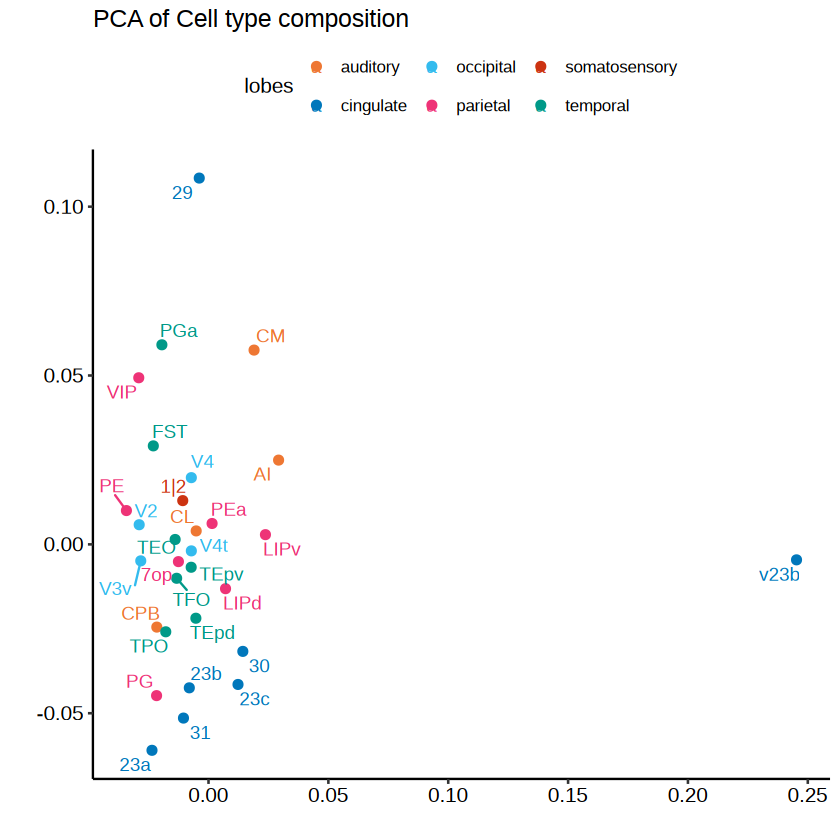

`summarise()` has grouped output by 'true'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'true'. You can override using the
`.groups` argument.


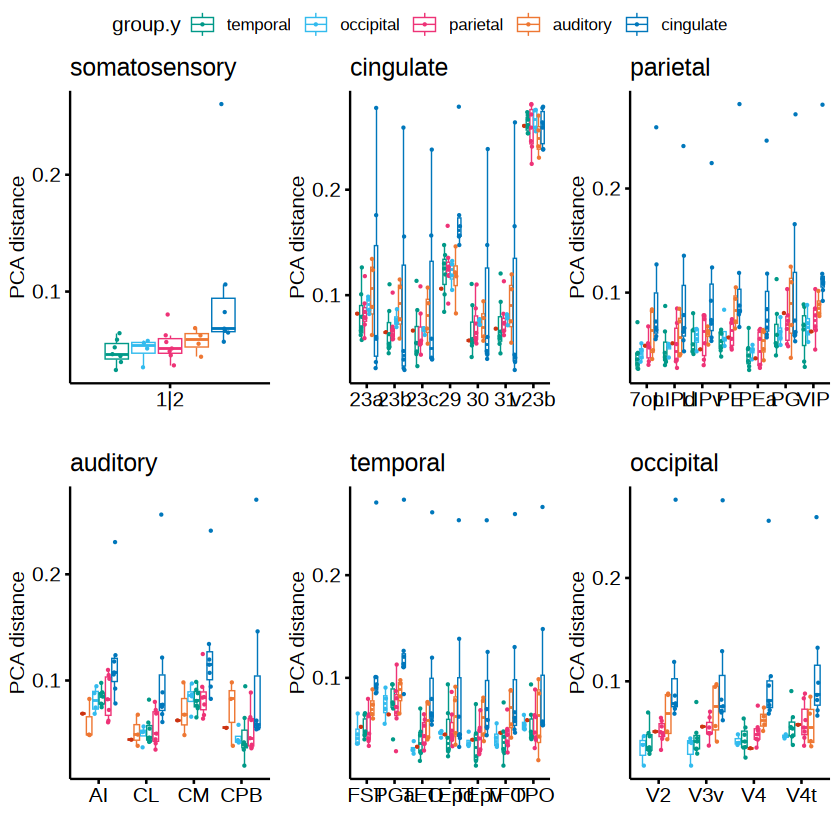

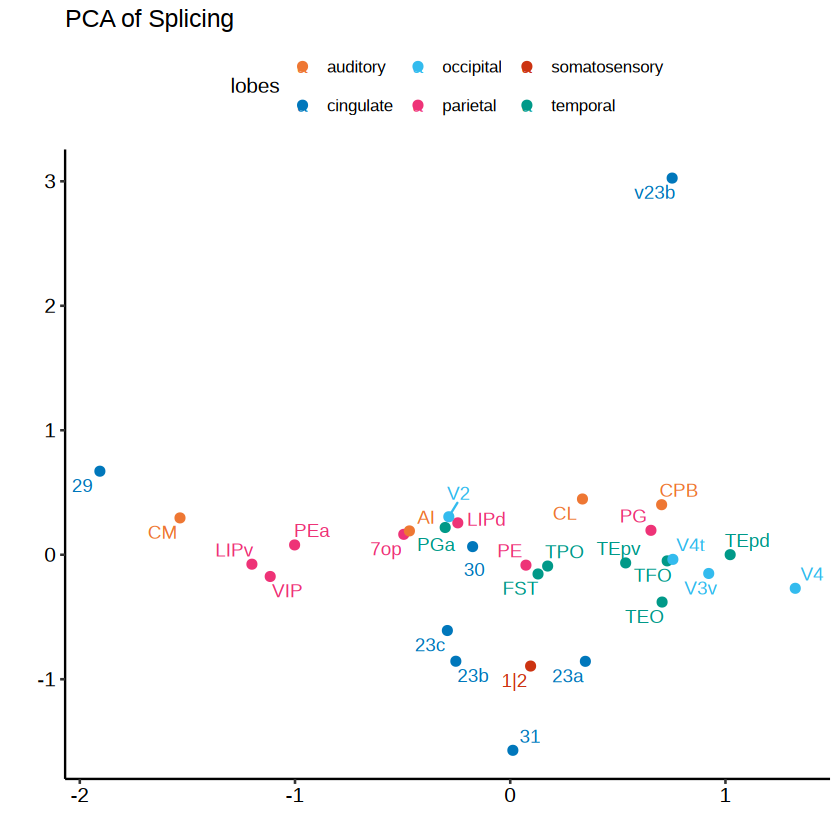

`summarise()` has grouped output by 'true'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'true'. You can override using the
`.groups` argument.


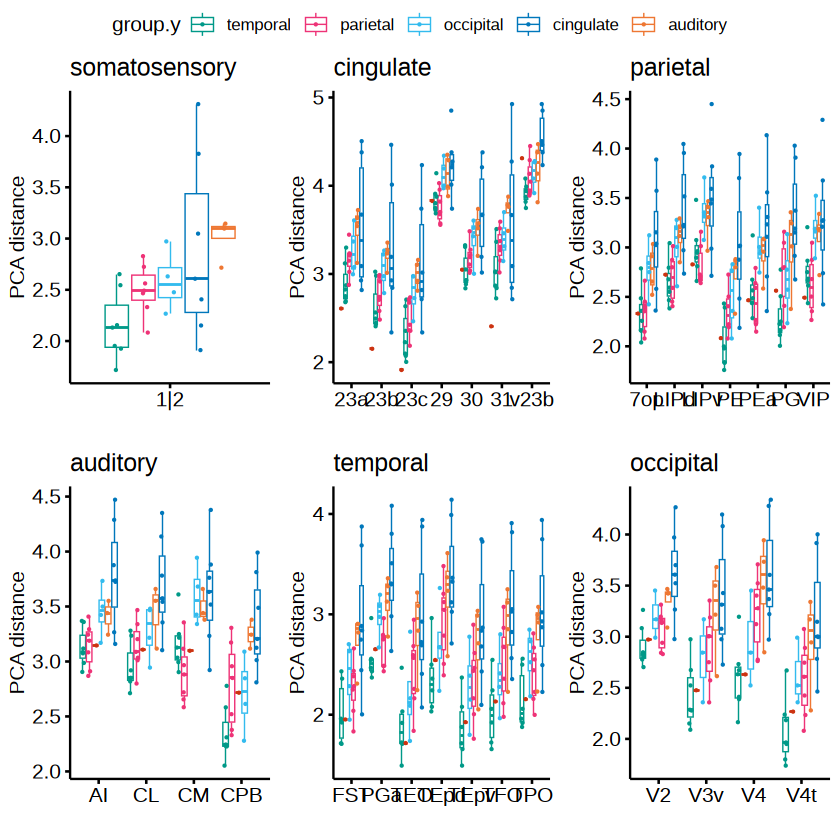

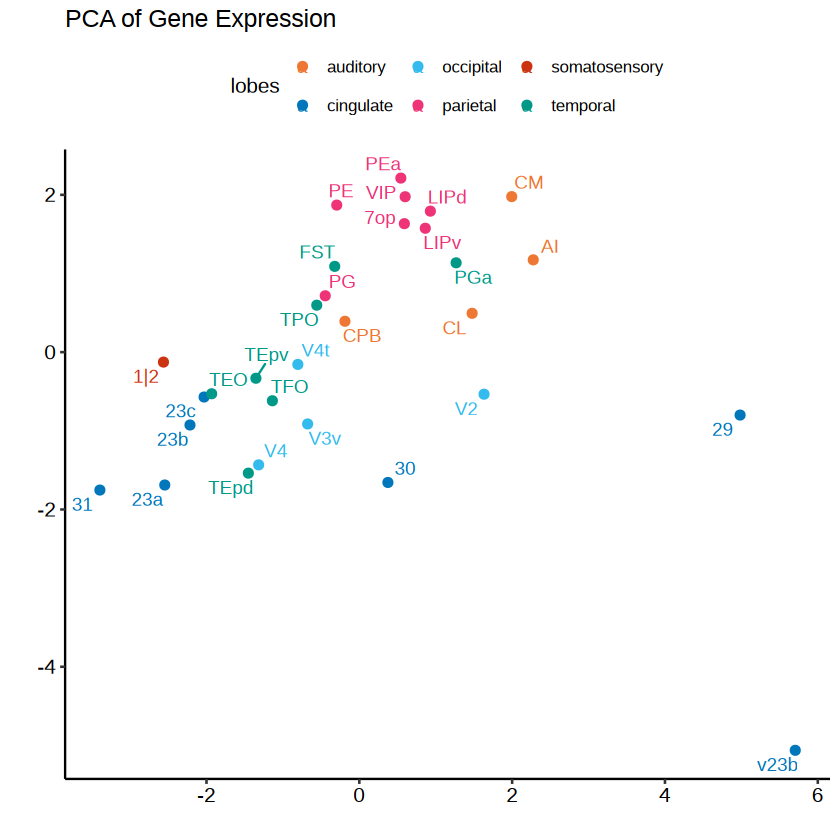

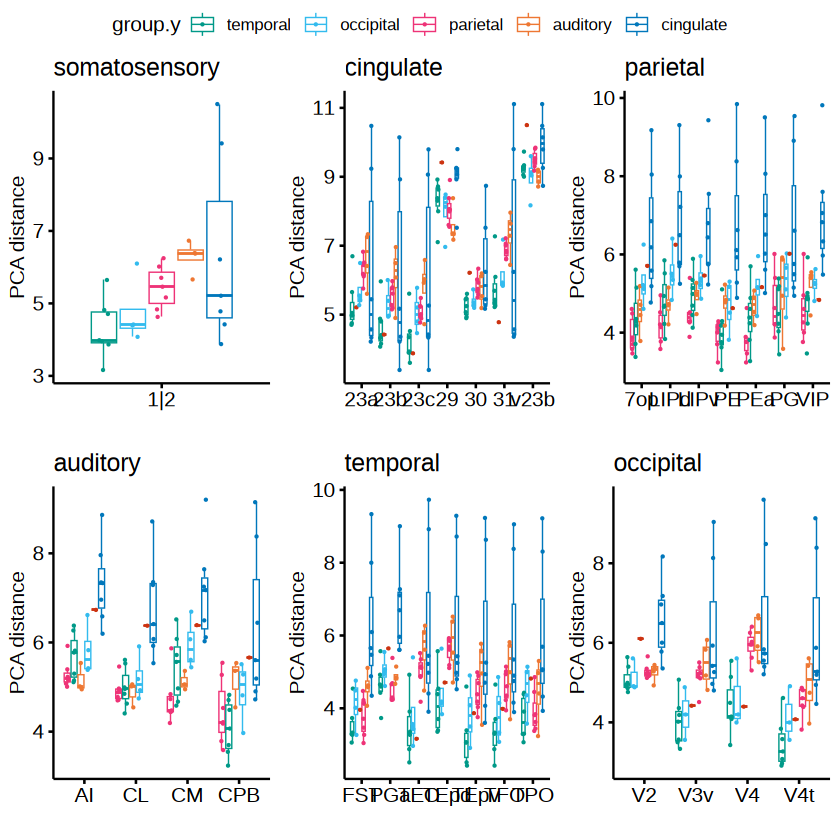

In [105]:
library(factoextra)
library(cluster)
library(mclust)
library(reshape2)
mycolor = c("auditory" = "#EE7733",
              "cingulate" = "#0077BB",
              "occipital" = "#33BBEE",
              "parietal" = "#EE3377",
              "somatosensory" = "#CC3311",
              "temporal" = "#009988")
  
  #build cell gene exon matrix
  MyPCAVerify = function(asl,mytitle){
    res.pca = prcomp(asl[-ncol(asl)])
    
    # res.pam = pam(asl[-ncol(asl)], 5,  metric = "euclidean", stand = FALSE)
    # fviz_cluster(res.pam, data = asl[-ncol(asl)],star.plot = TRUE,
    #              ellipse.type = "euclid",
    #              repel = TRUE)
    # fviz_silhouette(res.pam, palette = "jco", ggtheme = theme_classic())
    
    cl_pred = kmeans(asl[-ncol(asl)], centers=length(unique(asl$group)))$cluster
    cl_true = as.factor(asl$group)
    ShannonIndex = function(x){
      # return(-sum(x*log(x)))
      return(1/sum(x^2))
    }
    clscore = data.frame("pred" = cl_pred, "true" = cl_true)
    clscore1 = clscore %>% group_by(true,pred) %>% summarise(count = n()) 
    clscore1 = clscore1 %>% group_by(true) %>% summarise(prop = count/sum(count))
    clscore1 = clscore1 %>% group_by(true) %>% summarise(disp = ShannonIndex(prop))
    ari1 = adjustedRandIndex(cl_pred, cl_true)
    
    cormx = cor(t(asl[-ncol(asl)]))
    cormxl = melt(cormx)
    classid = unique(asl$group)
    classmx = data.frame("tr" = rownames(asl),"group" = asl$group)
    corst = NULL
    cormxl = cormxl[cormxl$Var1 != cormxl$Var2,]
    for (classg in classid) {
      classi = classmx[classmx$group == classg, ]$tr
      cori = cormxl[cormxl$Var1 %in% classi & cormxl$Var2 %in% classi, ]
      coro = cormxl[(cormxl$Var1 %in% classi & !(cormxl$Var2 %in% classi)) | 
                      (cormxl$Var2 %in% classi & !(cormxl$Var1 %in% classi)), ]
      # cori$group = "in"
      # coro$group = "out"
      # cort = rbind(cori,coro)
      # ggplot(cort,aes(x = group,y = value)) + geom_boxplot()
      # mean(cori$value)/mean(cort$value)
      corst = rbind(corst, 
                    data.frame("group" = classg, 
                               "corv" = mean(cori$value) - mean(coro$value)))
      
    }
    
    # kmerdata = as.data.frame(res.pca$x)
    # kmerdata$group = as.character(as.vector(cl_pred))
    # kmerdata$lobes = asl$group
    # ppca1 = ggplot(kmerdata,aes(x = PC1,y = PC2,color = lobes)) + geom_point() +
    #   stat_ellipse(aes(x = PC1,y = PC2,color = group,group=group)) + theme_pubr() +
    #   scale_color_discreterainbow()
    
    kmergroup = as.character(cl_pred)
    
    ppca1 = fviz_pca_ind(res.pca,
                         # col.ind = kmergroup,
                         fill.ind = asl$group,
                         pointshape = 21, pointsize = 2,
                         # habillage = cl_pred,
                         addEllipses = TRUE,ellipse.type = "convex",
                         repel = TRUE) + theme_pubr() +
      ggtitle(mytitle) +
      scale_color_viridis(discrete = T) +
      scale_fill_discreterainbow()
    
    ppca1 = fviz_pca_ind(res.pca,
                         # col.ind = kmergroup,
                         fill.ind = asl$group,
                         pointshape = 21, pointsize = 2,
                         # habillage = cl_pred,
                         addEllipses = TRUE,ellipse.type = "convex",
                         repel = TRUE) + theme_pubr() +
      ggtitle(mytitle) +
      scale_color_viridis(discrete = T) +
      scale_fill_discreterainbow()
    
    return(list("pcaf" = ppca1, "clscore" = clscore1,"corst" = corst,
                "ari" = ari1))
  }
  MyPCAVerify2 = function(asl,mytitle,mycolor = mycolor){
    cl_true = asl$group
    res.pca = prcomp(asl[-ncol(asl)])
    res.ds = dist(as.data.frame(res.pca$x))
    classid = unique(asl$group)
    classmx = data.frame("tr" = rownames(asl),"group" = asl$group)
    pcadis = melt(as.matrix(res.ds))
    pcadis = pcadis[pcadis$Var1 != pcadis$Var2,]
    pcadis = merge(pcadis,classmx,by.x = "Var1",by.y = "tr")
    pcadis = merge(pcadis,classmx,by.x = "Var2",by.y = "tr")
    corst = NULL
    
    pdisls = list()
    i = 1
    for (classg in classid) {
      cori = classmx[classmx$group %in% classg, ]
      corst = pcadis[(pcadis$Var1 %in% cori$tr),]
      corst = corst %>% group_by(group.x,group.y) %>% 
        mutate(meandis = mean(value))
      corst = corst[order(corst$meandis),]
      corst$group.y = factor(corst$group.y,levels = unique(corst$group.y))
      
      pdisls[[i]] = ggboxplot(
        corst, x = "Var1", y = "value", size = 0.3,
        add = c("jitter"),add.params = list(size = 0.1),
        color = "group.y"
      ) + 
        xlab("") + ylab("PCA distance") +
        ggtitle(classg) +
        scale_color_manual(values = mycolor) + theme(legend.position = "none")
      i = i +1 
    }
    
    pca.facet = ggarrange(plotlist = pdisls, 
                          nrow = 2,ncol = 3,common.legend = T)
    pca.facet
    
    # ppca1 = ggplot(umapdf,aes(x = x,y = y, color = group)) +
    #   geom_point() +
    #   ggtitle(mytitle) +
    #   theme_pubr() +
    #   scale_color_manual(values = mycolor)
    cl_pred = kmeans(res.pca$x, centers=length(unique(asl$group)))$cluster
    kmergroup = as.character(cl_pred)
    library(cluster)
    pcabasic = fviz_pca_ind(res.pca,label = "none") + 
      ggtitle(mytitle)
    
    pcabasic = pcabasic$data
    pcabasic$lobes = asl$group
    pcabasic$clusters = kmergroup
    pcabasic$name = as.character(pcabasic$name)
    ppca1 = ggplot(pcabasic,aes(x = x,y = y, color = lobes)) + 
      geom_point(size = 2) + 
      ggrepel::geom_text_repel(aes(label = name)) +
      theme_pubr() +
      ggtitle(mytitle) + xlab("") + ylab("") +
      scale_color_manual(values = mycolor)
    
    ShannonIndex = function(x){
      # return(-sum(x*log(x)))
      return(1/sum(x^2))
    }
    clscore = data.frame("pred" = cl_pred, "true" = cl_true)
    clscore1 = clscore %>% group_by(true,pred) %>% summarise(count = n()) 
    clscore1 = clscore1 %>% group_by(true) %>% summarise(prop = count/sum(count))
    clscore1 = clscore1 %>% group_by(true) %>% summarise(disp = ShannonIndex(prop))
    pcadist = pcadis %>% group_by(Var1) %>%
      summarise(disore = mean(value[group.x == group.y])/mean(value[group.x != group.y]),
                lobes = unique(group.x))
    
    return(list("pcaf" = ppca1, "pcafacet" = pca.facet,
                "pcadis" = pcadis,"shscore" = clscore1,
                "pcadist" = pcadist))
  }
  library(umap)
  library(ggpubr)
  asl = armxls$cell
  areaPcac = MyPCAVerify2(armxls$cell,"PCA of Cell type composition",mycolor = mycolor)
  areaPcac$pcaf
  areaPcac$pcafacet
  
  #PCA analysis for exon jaccard or gene express
  areaPcae = MyPCAVerify2(armxls$isoform,"PCA of Splicing",mycolor)
  areaPcae$pcaf
  areaPcae$pcafacet
  
  #for gene express
  areaPcag = MyPCAVerify2(armxls$gene,"PCA of Gene Expression",mycolor)
  areaPcag$pcaf
  areaPcag$pcafacet
  
  library(ggpubr)

  # fviz_cluster(genexpmx_cl, data = res.pca3$x[,1:2],shape = 16) +
  #   geom_point(aes(shape = genexpmx$L0), alpha = 0.5) + theme_nature()
  areapcals = list("cell" = areaPcac,
                   "gene" = areaPcag,
                   "exon" = areaPcae)
qsave(areapcals,file = "result/figure2/areaid_PCA_total_ls_09_09.qs")

In [106]:
#isoform
fsraw.cor$areatri = paste0(fsraw.cor$region,"-",fsraw.cor$layer)
isodf = fsraw.cor %>% group_by(areatri,gene_id) %>% mutate(genecount = length(readid)) %>%
group_by(areatri,gene_id,transcript_id) %>% summarise(count = length(readid),rate = count/genecount[1])
isomx = dcast(isodf, areatri~transcript_id,
                      value.var = "rate",fun.aggregate = sum)
isomx[is.na(isomx)] = 0
rownames(isomx) = isomx$areatri;isomx = isomx[-1]
head(isodf)
isomx = isomx[,colSums(isomx > 0) > 29]

`summarise()` has grouped output by 'areatri', 'gene_id'. You can override
using the `.groups` argument.


areatri gene_id transcript_id  count rate
1 1|2-l1  A4GALT  XM_015457101.1  2    1.00
2 1|2-l1  AAAS    AAAS-FS-1       1    0.25
3 1|2-l1  AAAS    XM_005571000.2  3    0.75
4 1|2-l1  AACS    NM_001284010.1 10    1.00
5 1|2-l1  AADAT   AADAT-FS-1      1    0.50
6 1|2-l1  AADAT   XM_005556303.2  1    0.50

file saved to result/figure2/f5b.areaid_PCA_total_25_10_11.pdf



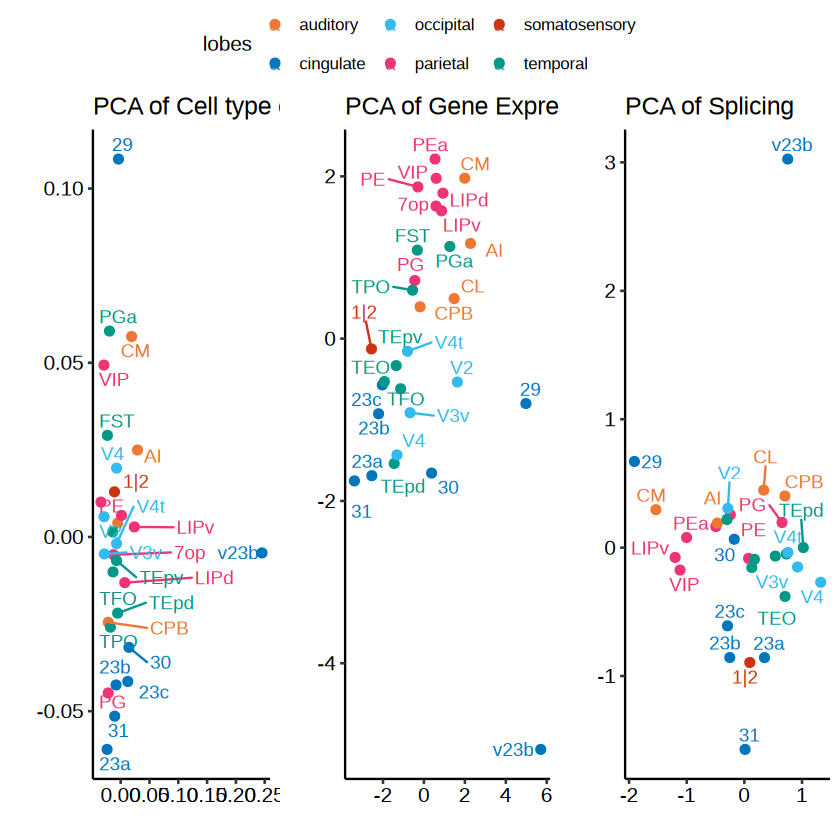

In [108]:
pt = ggarrange(areaPcac$pcaf, areaPcag$pcaf,areaPcae$pcaf,nrow = 1,common.legend = T)
pt
ggexport(pt,filename = "result/figure2/f5b.areaid_PCA_total_25_10_11.pdf",width = 10,height = 4)